# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [37]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 10
active_traits = 5


In [38]:
generate_student_name()

'PHUTHY CORE '

In [39]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [40]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.310970050388737
th 3.897611886887864 7.208581937276601
null-task passrate 0.7310585786300049
all-null passrate 0.20881461345923252
worst cmp chance= 0.3981071705534973
best cmp chance= 0.9979919516614258
worst Pr= 0.010000000000000007
best Pr= 0.9900000000000002
limits 0.9477282576298987 0.9477282576298987
[[1 2 3]
 [7 8 9]]
(2, 3)


In [41]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [42]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix

#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        n_c =  numpy.random.choice(range(1,active_traits))
#         n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.betas[c] = random.uniform(min_diff, max_diff)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.thetas[c] = random.uniform(min_a, max_a)  


In [43]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [44]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [45]:
# def create_encounter_keys(volume, n_active):
#     prs = [ uniform(0.01,0.99) for _ in range(volume) ]
# #     print(caius)
#     compons = [ randint(1,n_active) for _ in range(volume) ]
# #     print(compons)
#     comp_ps = [ p**(1/n) for p,n in zip(prs,compons)]
# #     comp_ps = [ p for p,n in zip(prs,compons)]
# #     print(comp_ps)
#     spreads = [ -math.log((1.0/pr)-1.0) for pr in comp_ps ]
    
#     hard_comp_del = min(spreads)
#     easy_comp_del = max(spreads)
#     offset = (easy_comp_del - hard_comp_del)/2
#     baseline = 1
#     beta_min = baseline+0
#     # beta_max = baseline+round(offset,1)
#     # theta_min = baseline+round(easy_comp_del - offset,1)
#     # theta_max = baseline+round(easy_comp_del,1)
#     beta_max = baseline+(offset)
#     theta_min = baseline+(easy_comp_del - offset)
#     theta_max = baseline+(easy_comp_del)

#     print(beta_min, beta_max)
#     print(theta_min, theta_max)

#     ths=[]
#     bs=[]
#     lowest = math.inf
#     for s in spreads:
#         choyce = random.choice(["th","b"])
#         if choyce=="th":
#             th = random.uniform(theta_min, theta_max)
#             b = th-s
#             lowest = b if b < lowest else lowest
#         else:
#             b = random.uniform(beta_min, beta_max)
#             th = b-s
#             lowest = th if th < lowest else lowest
#         ths.append(th)
#         bs.append(b)
    
#     ths = [th-lowest for th in ths]
#     bs = [b-lowest for b in bs]
        
#     plt.hist(ths)
#     plt.show()
#     plt.hist(bs)
#     plt.show()
# #     print(spreads)
#     plt.hist(spreads, bins=25)
#     plt.show()
#     return prs

# create_encounter_keys(1000,5)


In [46]:
def create_qs_from_blobs(n_qs, n_clusters, nt=n_traits):
    from sklearn.datasets.samples_generator import make_blobs
    from sklearn.preprocessing import MinMaxScaler
    
    #beta_min,beta_max
    sc = MinMaxScaler(feature_range=(beta_min, beta_max))
    
    X, y = make_blobs(n_samples=n_qs, centers=n_clusters, n_features=nt, cluster_std=2, random_state=666)
#     baseline = numpy.min(X)
#     X = X - baseline
    X = sc.fit_transform(X)

    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()
    
    qns = []
    for qix, (blob, y) in enumerate(zip(X,y)):
        qn = Question(qix, 0,0, nt=nt, nnw=nnw)
        qn.betas = blob
        qn.group = y
        qns.append(qn)
        
    mags = []
    no_comps = []
    for q in qns:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
        
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    qn_table = BigTable((n_qs, nt),min_w=0, max_w=beta_max)    
    return qns, qn_table

In [47]:
def create_qs(n_qs, nt=n_traits, nnw=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=0, max_w=beta_max)
    
    return master_qs, qn_table

In [48]:
def create_students(n_students, nt=n_traits, nnw=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)
    
    itemz = array([ s.thetas for s in psi_list ])
#     fig.set_size_inches(10, 10)
    ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
    for i, txt in enumerate(itemz):
        ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
    plt.show()
    
    return psi_list, psi_table
    

In [49]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
#     qn_qmx.trainable = True
#     psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)
#     psi_qmx_row = psi_qmx(psi_sel)

#     not_q = Lambda(lambda z: 1.0 / (1.0 + K.exp(10.0*z-5)), name="NOT_GATE")(qn_qmx_row)
#     scale = Lambda(lambda x1: 10.0*x1)
#     scale_sub = Lambda(lambda x2: 10.0*x2 - 5.0)

    
    ####
    # q0,s0 -> 1
    # q0,s1 -> 1
    # q1,s0 -> 0
    # q1,s1 -> cPr
    
#     p = scale_sub(psi_row)
#     not_q = scale(not_q)
#     qmx_selector = add([p, not_q])

    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)
#     q_masque = qn_row
#     s_masque = psi_row

    q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
    q0 = Lambda(lambda q: 1-q)(q_masque)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)

    Prs = multiply([Prs, q1_s1])
    Prs = add([Prs, q0])
    
#     topped_up = Lambda(lambda ps_q:  K.clip(ps_q[0]+(1.0-ps_q[1]), 0,1))([Prs_holed, q_masque])

#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [50]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
                while (not passed) and att<user_patience:
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, passed)
                    attempt_n_map[(q.id,psi.id)] += 1
                    attempts.append(tup)
                    print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                    attempts_by_psi[psi.name].append(tup)
                    attempts_by_q[q].append(tup)
                    att += 1
                if (not pass_to_remove) or (pass_to_remove and passed):
                    qs.remove(qix)
                print("len qs is", len(qs))
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [51]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [52]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 10
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs

    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))

            psi_wgts = s_table.get_weights()[0]
#             psi_qmx_wgts = s_qmx_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
#                 masque = psi_qmx_wgts[s.id]
                spred = psi_wgts[s.id] #* masque
                sreal = s.thetas
                err = numpy.abs(numpy.sort(spred) - numpy.sort(sreal))
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
#             qn_qmx_wgts = q_qmx_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
#                 masque = qn_qmx_wgts[q.id]
#                 print("masque =", masque)
                qpred = numpy.sort(qn_wgts[q.id])
                print("qpred =", qpred)
                qreal = numpy.sort(q.betas)
                print("qreal =", qreal)
                err = numpy.abs(qpred - qreal)
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
            av_rmse =(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            print("av RMSE=",av_rmse)
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [53]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

Q:0, difficulty=2.51 across 1 components
Q:1, difficulty=3.99 across 1 components
Q:2, difficulty=3.61 across 2 components
Q:3, difficulty=5.74 across 3 components
Q:4, difficulty=5.51 across 4 components
Q:5, difficulty=5.92 across 3 components
Q:6, difficulty=5.70 across 4 components
Q:7, difficulty=4.05 across 1 components
Q:8, difficulty=3.85 across 2 components
Q:9, difficulty=4.29 across 2 components
Q:10, difficulty=1.29 across 1 components
Q:11, difficulty=5.56 across 3 components
Q:12, difficulty=5.18 across 4 components
Q:13, difficulty=5.34 across 4 components
Q:14, difficulty=5.01 across 4 components
Q:15, difficulty=3.76 across 3 components
Q:16, difficulty=6.52 across 3 components
Q:17, difficulty=6.55 across 4 components
Q:18, difficulty=5.90 across 2 components
Q:19, difficulty=6.58 across 4 components
Q:20, difficulty=5.85 across 4 components
Q:21, difficulty=2.67 across 1 components
Q:22, difficulty=5.23 across 3 components
Q:23, difficulty=4.32 across 4 components
Q:

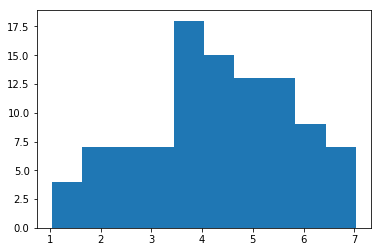

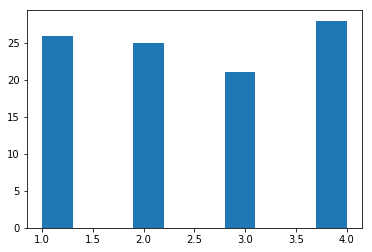

qid 0 [0, 0, 0, 0, 0, 2.5101984971565656, 0, 0, 0, 0]
qid 1 [0, 0, 0, 3.9908759086513483, 0, 0, 0, 0, 0, 0]
qid 2 [0, 2.438204260629469, 0, 2.657559979636604, 0, 0, 0, 0, 0, 0]
qid 3 [0, 0, 0, 2.8331971792828448, 0, 0, 3.357989328310622, 0, 3.6863869519682155, 0]
qid 4 [0, 2.2763580066313045, 3.082964235313818, 0, 0, 3.6976451707487756, 0, 1.4077197844715144, 0, 0]
qid 5 [0, 0, 1.0555089285925308, 0, 4.2739462130441614, 3.952808142233556, 0, 0, 0, 0]
qid 6 [0, 1.3290450545217896, 0, 0, 0, 0, 4.203217619253647, 0, 1.5621063602152172, 3.256601545615975]
qid 7 [4.051585238749421, 0, 0, 0, 0, 0, 0, 0, 0, 0]
qid 8 [0, 0, 0, 3.0213890685932925, 0, 0, 2.390824766984986, 0, 0, 0]
qid 9 [0, 0, 0, 2.711927802180143, 0, 0, 0, 3.3260033151673483, 0, 0]
qid 10 [0, 0, 0, 0, 0, 0, 0, 0, 1.2859320150253666, 0]
qid 11 [0, 0, 0, 0, 4.1789194610983085, 0, 2.030217363515868, 3.0535963213357733, 0, 0]
qid 12 [0, 1.4311972978519223, 0, 0, 0, 0, 1.168333949129022, 3.9839311077484614, 2.749886370868249, 0]
qi

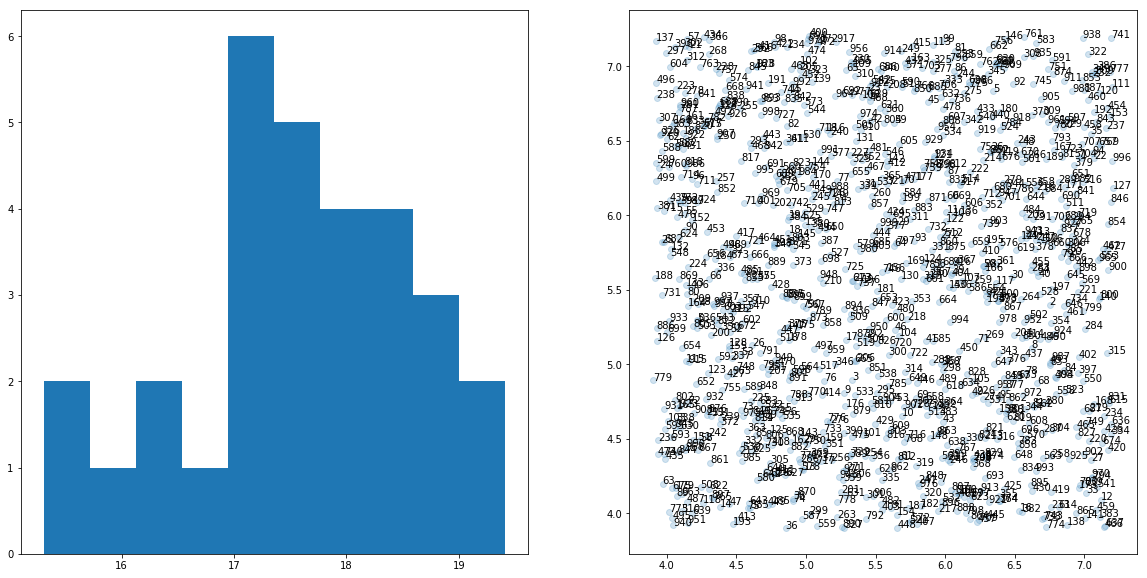

----0

p_pass was 0.9230591113559999 = 1
len qs is 99
p_pass was 0.9269544402031025 = 1
len qs is 98
p_pass was 0.8455998706465786 = 1
len qs is 97
p_pass was 0.8266429253112225 = 1
len qs is 96
p_pass was 0.765689607911722 = 1
len qs is 95
p_pass was 0.7669278996704488 = 1
len qs is 94
p_pass was 0.6122372256500929 = 1
len qs is 93
p_pass was 0.6987772689060741 = 0
p_pass was 0.6987772689060741 = 1
len qs is 92
p_pass was 0.5069522941225175 = 0
p_pass was 0.5069522941225175 = 0
p_pass was 0.5069522941225175 = 0
p_pass was 0.5069522941225175 = 1
len qs is 91
p_pass was 0.822311841088213 = 1
len qs is 90
p_pass was 0.6051781669524676 = 0
p_pass was 0.6051781669524676 = 1
len qs is 89
p_pass was 0.9821440269138803 = 1
len qs is 88
p_pass was 0.8093661068323711 = 1
len qs is 87
p_pass was 0.779793438533217 = 1
len qs is 86
p_pass was 0.4943041691883269 = 1
len qs is 85
p_pass was 0.991087664277974 = 1
len qs is 84
p_pass was 0.8347534916598589 = 1
len qs is 83
p_pass was 0.862338740474545

p_pass was 0.8415908994264722 = 1
len qs is 58
p_pass was 0.9165427366199141 = 0
p_pass was 0.9165427366199141 = 0
p_pass was 0.9165427366199141 = 1
len qs is 57
p_pass was 0.8968355448229587 = 1
len qs is 56
p_pass was 0.7551749392127052 = 1
len qs is 55
p_pass was 0.6108023928545243 = 0
p_pass was 0.6108023928545243 = 1
len qs is 54
p_pass was 0.9504294879057701 = 1
len qs is 53
p_pass was 0.8664079393788926 = 1
len qs is 52
p_pass was 0.7049962306642701 = 1
len qs is 51
p_pass was 0.34073972784023937 = 0
p_pass was 0.34073972784023937 = 1
len qs is 50
p_pass was 0.5268815886547641 = 1
len qs is 49
p_pass was 0.5378977805109427 = 0
p_pass was 0.5378977805109427 = 0
p_pass was 0.5378977805109427 = 1
len qs is 48
p_pass was 0.7950924963319181 = 1
len qs is 47
p_pass was 0.860452512584121 = 0
p_pass was 0.860452512584121 = 0
p_pass was 0.860452512584121 = 1
len qs is 46
p_pass was 0.9298451487121793 = 1
len qs is 45
p_pass was 0.7828350363340334 = 1
len qs is 44
p_pass was 0.86038104689

p_pass was 0.758606482159781 = 1
len qs is 17
p_pass was 0.7689055127277982 = 1
len qs is 16
p_pass was 0.8841925586853254 = 1
len qs is 15
p_pass was 0.8347740625283161 = 1
len qs is 14
p_pass was 0.9277534169131829 = 1
len qs is 13
p_pass was 0.959974738651964 = 1
len qs is 12
p_pass was 0.8004234369725352 = 1
len qs is 11
p_pass was 0.511014792035877 = 1
len qs is 10
p_pass was 0.7707603318634509 = 0
p_pass was 0.7707603318634509 = 1
len qs is 9
p_pass was 0.9210416030768946 = 1
len qs is 8
p_pass was 0.6769074363734802 = 1
len qs is 7
p_pass was 0.6336065909444177 = 1
len qs is 6
p_pass was 0.8066883946211314 = 1
len qs is 5
p_pass was 0.6175187397069197 = 1
len qs is 4
p_pass was 0.6088486017650632 = 1
len qs is 3
p_pass was 0.6910337246839507 = 1
len qs is 2
p_pass was 0.8157645475179651 = 1
len qs is 1
p_pass was 0.8564081540741127 = 1
len qs is 0
p_pass was 0.7250113803042304 = 1
len qs is 99
p_pass was 0.7980457816565422 = 0
p_pass was 0.7980457816565422 = 1
len qs is 98
p_pas

p_pass was 0.5792656636723066 = 0
p_pass was 0.5792656636723066 = 1
len qs is 67
p_pass was 0.40403700859366987 = 0
p_pass was 0.40403700859366987 = 0
p_pass was 0.40403700859366987 = 1
len qs is 66
p_pass was 0.7514836279636647 = 0
p_pass was 0.7514836279636647 = 1
len qs is 65
p_pass was 0.63809400289042 = 0
p_pass was 0.63809400289042 = 1
len qs is 64
p_pass was 0.8621396468255752 = 1
len qs is 63
p_pass was 0.5743137139699006 = 1
len qs is 62
p_pass was 0.2773289182664985 = 0
p_pass was 0.2773289182664985 = 1
len qs is 61
p_pass was 0.4690184977055534 = 1
len qs is 60
p_pass was 0.20804013894813864 = 1
len qs is 59
p_pass was 0.8286016348275006 = 0
p_pass was 0.8286016348275006 = 1
len qs is 58
p_pass was 0.6448365903825556 = 1
len qs is 57
p_pass was 0.9160866427121642 = 1
len qs is 56
p_pass was 0.2617136062179542 = 0
p_pass was 0.2617136062179542 = 1
len qs is 55
p_pass was 0.3605125524856898 = 1
len qs is 54
p_pass was 0.9585648264110197 = 1
len qs is 53
p_pass was 0.6296986854

p_pass was 0.8099905373257824 = 1
len qs is 41
p_pass was 0.6009349350653173 = 0
p_pass was 0.6009349350653173 = 0
p_pass was 0.6009349350653173 = 0
p_pass was 0.6009349350653173 = 1
len qs is 40
p_pass was 0.8879830990242933 = 1
len qs is 39
p_pass was 0.8333415508842744 = 1
len qs is 38
p_pass was 0.3128475543445847 = 1
len qs is 37
p_pass was 0.827176561522533 = 0
p_pass was 0.827176561522533 = 1
len qs is 36
p_pass was 0.8916350128900496 = 1
len qs is 35
p_pass was 0.8194638138368597 = 1
len qs is 34
p_pass was 0.7666966683573196 = 1
len qs is 33
p_pass was 0.6299082142528092 = 1
len qs is 32
p_pass was 0.9385257510327059 = 1
len qs is 31
p_pass was 0.7949835083878398 = 1
len qs is 30
p_pass was 0.5090849271510054 = 0
p_pass was 0.5090849271510054 = 0
p_pass was 0.5090849271510054 = 0
p_pass was 0.5090849271510054 = 0
p_pass was 0.5090849271510054 = 1
len qs is 29
p_pass was 0.8739650761650253 = 1
len qs is 28
p_pass was 0.8825048890781603 = 1
len qs is 27
p_pass was 0.698233608082

len qs is 38
p_pass was 0.5604191718805922 = 0
p_pass was 0.5604191718805922 = 0
p_pass was 0.5604191718805922 = 1
len qs is 37
p_pass was 0.7994937487838215 = 1
len qs is 36
p_pass was 0.6775897014012324 = 1
len qs is 35
p_pass was 0.5058072052337031 = 1
len qs is 34
p_pass was 0.7579163880004536 = 0
p_pass was 0.7579163880004536 = 1
len qs is 33
p_pass was 0.37844819090890347 = 0
p_pass was 0.37844819090890347 = 0
p_pass was 0.37844819090890347 = 0
p_pass was 0.37844819090890347 = 0
p_pass was 0.37844819090890347 = 1
len qs is 32
p_pass was 0.8494441527961011 = 1
len qs is 31
p_pass was 0.7574313527476649 = 1
len qs is 30
p_pass was 0.6837585114506521 = 1
len qs is 29
p_pass was 0.8463785213480287 = 1
len qs is 28
p_pass was 0.8250796150427677 = 1
len qs is 27
p_pass was 0.4013143537834909 = 0
p_pass was 0.4013143537834909 = 1
len qs is 26
p_pass was 0.931597299030732 = 1
len qs is 25
p_pass was 0.7150177763759994 = 1
len qs is 24
p_pass was 0.6787509832002507 = 1
len qs is 23
p_pass

p_pass was 0.44731608579285903 = 0
p_pass was 0.44731608579285903 = 1
len qs is 34
p_pass was 0.6039219892918739 = 0
p_pass was 0.6039219892918739 = 0
p_pass was 0.6039219892918739 = 0
p_pass was 0.6039219892918739 = 1
len qs is 33
p_pass was 0.5730706661318985 = 1
len qs is 32
p_pass was 0.5339589759772989 = 0
p_pass was 0.5339589759772989 = 1
len qs is 31
p_pass was 0.7836776527828223 = 1
len qs is 30
p_pass was 0.8877011078114255 = 0
p_pass was 0.8877011078114255 = 1
len qs is 29
p_pass was 0.9040714331987607 = 1
len qs is 28
p_pass was 0.4809214773560735 = 0
p_pass was 0.4809214773560735 = 0
p_pass was 0.4809214773560735 = 1
len qs is 27
p_pass was 0.383794562992696 = 1
len qs is 26
p_pass was 0.6431978231044784 = 1
len qs is 25
p_pass was 0.9805429405988918 = 1
len qs is 24
p_pass was 0.9299579055333894 = 1
len qs is 23
p_pass was 0.8328876834550897 = 1
len qs is 22
p_pass was 0.8584474512820611 = 1
len qs is 21
p_pass was 0.8316433417842756 = 1
len qs is 20
p_pass was 0.527583283

p_pass was 0.7919780950356969 = 1
len qs is 60
p_pass was 0.8345073925810438 = 1
len qs is 59
p_pass was 0.9608789972921096 = 0
p_pass was 0.9608789972921096 = 1
len qs is 58
p_pass was 0.9922851634144232 = 1
len qs is 57
p_pass was 0.9248112829290501 = 1
len qs is 56
p_pass was 0.9602240576893978 = 1
len qs is 55
p_pass was 0.8688364019523103 = 1
len qs is 54
p_pass was 0.762982508950483 = 1
len qs is 53
p_pass was 0.7875336350223292 = 1
len qs is 52
p_pass was 0.41136573609214233 = 0
p_pass was 0.41136573609214233 = 0
p_pass was 0.41136573609214233 = 0
p_pass was 0.41136573609214233 = 1
len qs is 51
p_pass was 0.9321919470919455 = 1
len qs is 50
p_pass was 0.4239757996588752 = 1
len qs is 49
p_pass was 0.8220901495800335 = 1
len qs is 48
p_pass was 0.8995012028895994 = 1
len qs is 47
p_pass was 0.9182058990614139 = 1
len qs is 46
p_pass was 0.4776045560403725 = 0
p_pass was 0.4776045560403725 = 0
p_pass was 0.4776045560403725 = 1
len qs is 45
p_pass was 0.9456262748702652 = 1
len qs 

p_pass was 0.5748798536816973 = 1
len qs is 82
p_pass was 0.34547800988609584 = 0
p_pass was 0.34547800988609584 = 0
p_pass was 0.34547800988609584 = 1
len qs is 81
p_pass was 0.5223224396351726 = 1
len qs is 80
p_pass was 0.8479743157796384 = 1
len qs is 79
p_pass was 0.8671587379386055 = 1
len qs is 78
p_pass was 0.9210158884950406 = 1
len qs is 77
p_pass was 0.6436413713334452 = 1
len qs is 76
p_pass was 0.9600870562117453 = 1
len qs is 75
p_pass was 0.6563367775885336 = 1
len qs is 74
p_pass was 0.9545543450312931 = 1
len qs is 73
p_pass was 0.7004319212086363 = 1
len qs is 72
p_pass was 0.653503054565118 = 1
len qs is 71
p_pass was 0.8629167741565383 = 1
len qs is 70
p_pass was 0.9025715351775601 = 1
len qs is 69
p_pass was 0.9528836112939884 = 1
len qs is 68
p_pass was 0.5519511643796998 = 0
p_pass was 0.5519511643796998 = 0
p_pass was 0.5519511643796998 = 1
len qs is 67
p_pass was 0.8434805147376915 = 1
len qs is 66
p_pass was 0.9907928726219286 = 1
len qs is 65
p_pass was 0.936

p_pass was 0.90244388617653 = 1
len qs is 52
p_pass was 0.743585903000109 = 1
len qs is 51
p_pass was 0.795049873672858 = 1
len qs is 50
p_pass was 0.9338314049817511 = 1
len qs is 49
p_pass was 0.6933790537883878 = 1
len qs is 48
p_pass was 0.8430004640081514 = 1
len qs is 47
p_pass was 0.9799629411302448 = 1
len qs is 46
p_pass was 0.8024955320915554 = 0
p_pass was 0.8024955320915554 = 1
len qs is 45
p_pass was 0.5056918912302023 = 1
len qs is 44
p_pass was 0.7485515247788679 = 1
len qs is 43
p_pass was 0.697833539494799 = 1
len qs is 42
p_pass was 0.9167989409191609 = 1
len qs is 41
p_pass was 0.8905577603959048 = 1
len qs is 40
p_pass was 0.9195801531451331 = 1
len qs is 39
p_pass was 0.6692765639642265 = 1
len qs is 38
p_pass was 0.8571041911707372 = 0
p_pass was 0.8571041911707372 = 1
len qs is 37
p_pass was 0.8962215730895866 = 1
len qs is 36
p_pass was 0.8731379413393259 = 1
len qs is 35
p_pass was 0.9611688696595623 = 1
len qs is 34
p_pass was 0.9861358707960968 = 1
len qs is 

p_pass was 0.7707644399609525 = 0
p_pass was 0.7707644399609525 = 1
len qs is 51
p_pass was 0.9420006708264329 = 1
len qs is 50
p_pass was 0.8505301269799672 = 1
len qs is 49
p_pass was 0.476657513652149 = 0
p_pass was 0.476657513652149 = 0
p_pass was 0.476657513652149 = 1
len qs is 48
p_pass was 0.886819424515008 = 1
len qs is 47
p_pass was 0.8876110603168071 = 1
len qs is 46
p_pass was 0.6524518326513064 = 1
len qs is 45
p_pass was 0.6853196982944539 = 0
p_pass was 0.6853196982944539 = 1
len qs is 44
p_pass was 0.9954314996740171 = 1
len qs is 43
p_pass was 0.9955155991283787 = 1
len qs is 42
p_pass was 0.9357594274986064 = 1
len qs is 41
p_pass was 0.8131079722740293 = 1
len qs is 40
p_pass was 0.8834147691288416 = 0
p_pass was 0.8834147691288416 = 1
len qs is 39
p_pass was 0.7656845472595135 = 0
p_pass was 0.7656845472595135 = 1
len qs is 38
p_pass was 0.6582168332765587 = 1
len qs is 37
p_pass was 0.8523534925333331 = 1
len qs is 36
p_pass was 0.9950739494469745 = 1
len qs is 35
p

p_pass was 0.9841486075945851 = 1
len qs is 52
p_pass was 0.9648705998245541 = 1
len qs is 51
p_pass was 0.785504029683917 = 1
len qs is 50
p_pass was 0.8103392252906096 = 1
len qs is 49
p_pass was 0.9445502296835933 = 1
len qs is 48
p_pass was 0.8638581796693722 = 1
len qs is 47
p_pass was 0.9455866679585295 = 1
len qs is 46
p_pass was 0.9464970821380745 = 1
len qs is 45
p_pass was 0.8555614966307714 = 1
len qs is 44
p_pass was 0.9952127749751659 = 1
len qs is 43
p_pass was 0.8673056951992503 = 1
len qs is 42
p_pass was 0.9350031940157729 = 1
len qs is 41
p_pass was 0.8494522270431993 = 1
len qs is 40
p_pass was 0.8809823569378137 = 1
len qs is 39
p_pass was 0.9741848811576428 = 1
len qs is 38
p_pass was 0.9586128466996157 = 1
len qs is 37
p_pass was 0.9459460389776274 = 1
len qs is 36
p_pass was 0.8084518503756104 = 1
len qs is 35
p_pass was 0.6690289179074508 = 1
len qs is 34
p_pass was 0.832461164916261 = 1
len qs is 33
p_pass was 0.9664118674750942 = 1
len qs is 32
p_pass was 0.65

p_pass was 0.9395201801209067 = 1
len qs is 37
p_pass was 0.5290795028141246 = 0
p_pass was 0.5290795028141246 = 0
p_pass was 0.5290795028141246 = 0
p_pass was 0.5290795028141246 = 1
len qs is 36
p_pass was 0.9550171266424732 = 1
len qs is 35
p_pass was 0.88517622007623 = 1
len qs is 34
p_pass was 0.9541722478550867 = 1
len qs is 33
p_pass was 0.6629330605836868 = 1
len qs is 32
p_pass was 0.8585927462473155 = 1
len qs is 31
p_pass was 0.7619325499062083 = 1
len qs is 30
p_pass was 0.6558037328588086 = 0
p_pass was 0.6558037328588086 = 1
len qs is 29
p_pass was 0.9464377508290837 = 1
len qs is 28
p_pass was 0.9908235020881323 = 1
len qs is 27
p_pass was 0.9273900577566486 = 1
len qs is 26
p_pass was 0.712928007442278 = 0
p_pass was 0.712928007442278 = 0
p_pass was 0.712928007442278 = 1
len qs is 25
p_pass was 0.9052440598147321 = 1
len qs is 24
p_pass was 0.45557011810941245 = 1
len qs is 23
p_pass was 0.8647631744749553 = 1
len qs is 22
p_pass was 0.8881977441255541 = 1
len qs is 21
p

p_pass was 0.5463780329105871 = 1
len qs is 40
p_pass was 0.5623258797539092 = 0
p_pass was 0.5623258797539092 = 0
p_pass was 0.5623258797539092 = 1
len qs is 39
p_pass was 0.44114030695046114 = 1
len qs is 38
p_pass was 0.7725306146367009 = 1
len qs is 37
p_pass was 0.42547695244656986 = 1
len qs is 36
p_pass was 0.6828934127047904 = 1
len qs is 35
p_pass was 0.8331631110644306 = 1
len qs is 34
p_pass was 0.8054190283832906 = 1
len qs is 33
p_pass was 0.959612021848833 = 1
len qs is 32
p_pass was 0.835650273694733 = 1
len qs is 31
p_pass was 0.8024026831167901 = 1
len qs is 30
p_pass was 0.8243238899099746 = 1
len qs is 29
p_pass was 0.6814094809983354 = 1
len qs is 28
p_pass was 0.9519497691579578 = 1
len qs is 27
p_pass was 0.8011481030274231 = 1
len qs is 26
p_pass was 0.9786244517079022 = 1
len qs is 25
p_pass was 0.645829498542913 = 1
len qs is 24
p_pass was 0.8476517045675213 = 0
p_pass was 0.8476517045675213 = 0
p_pass was 0.8476517045675213 = 1
len qs is 23
p_pass was 0.856324

p_pass was 0.6672067662699384 = 0
p_pass was 0.6672067662699384 = 1
len qs is 31
p_pass was 0.9572210263037881 = 1
len qs is 30
p_pass was 0.491055084688015 = 1
len qs is 29
p_pass was 0.9154402913576583 = 0
p_pass was 0.9154402913576583 = 1
len qs is 28
p_pass was 0.6182632352060884 = 0
p_pass was 0.6182632352060884 = 1
len qs is 27
p_pass was 0.8755451160210079 = 0
p_pass was 0.8755451160210079 = 1
len qs is 26
p_pass was 0.9364219983039587 = 1
len qs is 25
p_pass was 0.6551288153278868 = 1
len qs is 24
p_pass was 0.9949189245180986 = 1
len qs is 23
p_pass was 0.9284078663646509 = 1
len qs is 22
p_pass was 0.8839193396773798 = 1
len qs is 21
p_pass was 0.5655310733868657 = 1
len qs is 20
p_pass was 0.8505630751920554 = 1
len qs is 19
p_pass was 0.8581540053920005 = 1
len qs is 18
p_pass was 0.7326762714041353 = 0
p_pass was 0.7326762714041353 = 0
p_pass was 0.7326762714041353 = 1
len qs is 17
p_pass was 0.9217762635968167 = 1
len qs is 16
p_pass was 0.6920115511800803 = 1
len qs is 1

p_pass was 0.7090103715042778 = 0
p_pass was 0.7090103715042778 = 1
len qs is 15
p_pass was 0.8282915344934506 = 1
len qs is 14
p_pass was 0.6529364692518923 = 1
len qs is 13
p_pass was 0.9135053672316799 = 1
len qs is 12
p_pass was 0.8357220059019316 = 1
len qs is 11
p_pass was 0.9858276417786093 = 1
len qs is 10
p_pass was 0.6875712777834996 = 1
len qs is 9
p_pass was 0.7827932695631772 = 1
len qs is 8
p_pass was 0.7617769186465064 = 1
len qs is 7
p_pass was 0.8717919998953826 = 1
len qs is 6
p_pass was 0.9664210351648853 = 1
len qs is 5
p_pass was 0.949986552367567 = 1
len qs is 4
p_pass was 0.8054745394722477 = 1
len qs is 3
p_pass was 0.9199830672700546 = 1
len qs is 2
p_pass was 0.9004552035208547 = 1
len qs is 1
p_pass was 0.816651520514119 = 1
len qs is 0
p_pass was 0.9152532975876069 = 1
len qs is 99
p_pass was 0.4421894714146223 = 0
p_pass was 0.4421894714146223 = 0
p_pass was 0.4421894714146223 = 1
len qs is 98
p_pass was 0.9398420793923014 = 1
len qs is 97
p_pass was 0.9935

p_pass was 0.9774846879714828 = 1
len qs is 32
p_pass was 0.762371668768546 = 0
p_pass was 0.762371668768546 = 1
len qs is 31
p_pass was 0.6908108898141413 = 1
len qs is 30
p_pass was 0.9668266901459149 = 1
len qs is 29
p_pass was 0.8459228810357604 = 1
len qs is 28
p_pass was 0.7712257867483183 = 1
len qs is 27
p_pass was 0.45836949880021105 = 0
p_pass was 0.45836949880021105 = 1
len qs is 26
p_pass was 0.6782606161045499 = 1
len qs is 25
p_pass was 0.8971563391026838 = 1
len qs is 24
p_pass was 0.6678292472140349 = 1
len qs is 23
p_pass was 0.5566196171672231 = 0
p_pass was 0.5566196171672231 = 1
len qs is 22
p_pass was 0.6983923870442931 = 0
p_pass was 0.6983923870442931 = 1
len qs is 21
p_pass was 0.4779826704011289 = 0
p_pass was 0.4779826704011289 = 1
len qs is 20
p_pass was 0.8053729057721509 = 0
p_pass was 0.8053729057721509 = 1
len qs is 19
p_pass was 0.38596586629783114 = 0
p_pass was 0.38596586629783114 = 0
p_pass was 0.38596586629783114 = 0
p_pass was 0.38596586629783114 = 

p_pass was 0.43764503783831826 = 0
p_pass was 0.43764503783831826 = 0
p_pass was 0.43764503783831826 = 0
p_pass was 0.43764503783831826 = 0
p_pass was 0.43764503783831826 = 1
len qs is 50
p_pass was 0.7542708939359178 = 1
len qs is 49
p_pass was 0.9609445001332989 = 1
len qs is 48
p_pass was 0.9633127218902481 = 1
len qs is 47
p_pass was 0.7850034656051988 = 0
p_pass was 0.7850034656051988 = 1
len qs is 46
p_pass was 0.8865806678527252 = 1
len qs is 45
p_pass was 0.47932648976950926 = 1
len qs is 44
p_pass was 0.6254104253640332 = 0
p_pass was 0.6254104253640332 = 0
p_pass was 0.6254104253640332 = 1
len qs is 43
p_pass was 0.8967641552019081 = 1
len qs is 42
p_pass was 0.8200657925404619 = 1
len qs is 41
p_pass was 0.9925744219454433 = 1
len qs is 40
p_pass was 0.8080170756000653 = 1
len qs is 39
p_pass was 0.36422857407922316 = 0
p_pass was 0.36422857407922316 = 0
p_pass was 0.36422857407922316 = 1
len qs is 38
p_pass was 0.9077668980555887 = 1
len qs is 37
p_pass was 0.87113076450645

len qs is 47
p_pass was 0.899959862131 = 0
p_pass was 0.899959862131 = 1
len qs is 46
p_pass was 0.987311622735305 = 1
len qs is 45
p_pass was 0.8938730622713968 = 1
len qs is 44
p_pass was 0.9679321142588418 = 1
len qs is 43
p_pass was 0.9135815747889772 = 1
len qs is 42
p_pass was 0.9700908648190562 = 1
len qs is 41
p_pass was 0.5846225529727642 = 1
len qs is 40
p_pass was 0.9949824225777529 = 1
len qs is 39
p_pass was 0.7455189684414029 = 0
p_pass was 0.7455189684414029 = 0
p_pass was 0.7455189684414029 = 0
p_pass was 0.7455189684414029 = 1
len qs is 38
p_pass was 0.7426125107569828 = 1
len qs is 37
p_pass was 0.8204080297717944 = 1
len qs is 36
p_pass was 0.9698541013156644 = 1
len qs is 35
p_pass was 0.6913347126130372 = 0
p_pass was 0.6913347126130372 = 1
len qs is 34
p_pass was 0.861908400263813 = 0
p_pass was 0.861908400263813 = 1
len qs is 33
p_pass was 0.7838865769651491 = 1
len qs is 32
p_pass was 0.6954435936446437 = 1
len qs is 31
p_pass was 0.5860646201004455 = 1
len qs i

p_pass was 0.8689710746603464 = 1
len qs is 55
p_pass was 0.9264932894284132 = 1
len qs is 54
p_pass was 0.9900268219031257 = 1
len qs is 53
p_pass was 0.5879408274882644 = 1
len qs is 52
p_pass was 0.9702523087991726 = 1
len qs is 51
p_pass was 0.9135670618321935 = 1
len qs is 50
p_pass was 0.9051807814042768 = 1
len qs is 49
p_pass was 0.5173877461259667 = 0
p_pass was 0.5173877461259667 = 0
p_pass was 0.5173877461259667 = 1
len qs is 48
p_pass was 0.8003367126999924 = 1
len qs is 47
p_pass was 0.8392936936028508 = 1
len qs is 46
p_pass was 0.9126337604004393 = 1
len qs is 45
p_pass was 0.9128909582136915 = 1
len qs is 44
p_pass was 0.6907206329728607 = 1
len qs is 43
p_pass was 0.8890027973640634 = 0
p_pass was 0.8890027973640634 = 1
len qs is 42
p_pass was 0.9493942954266107 = 1
len qs is 41
p_pass was 0.9153243108617551 = 1
len qs is 40
p_pass was 0.4183059734292665 = 1
len qs is 39
p_pass was 0.9511540919225397 = 1
len qs is 38
p_pass was 0.7607728188696149 = 1
len qs is 37
p_pas

len qs is 67
p_pass was 0.4189936665887306 = 0
p_pass was 0.4189936665887306 = 1
len qs is 66
p_pass was 0.6037215598783044 = 1
len qs is 65
p_pass was 0.6714095372800277 = 1
len qs is 64
p_pass was 0.8773922844922952 = 1
len qs is 63
p_pass was 0.9529457187761677 = 1
len qs is 62
p_pass was 0.5902185910513444 = 1
len qs is 61
p_pass was 0.9703092227869689 = 1
len qs is 60
p_pass was 0.9709603453425781 = 1
len qs is 59
p_pass was 0.9164737241921878 = 1
len qs is 58
p_pass was 0.869189381817886 = 1
len qs is 57
p_pass was 0.859558258075896 = 1
len qs is 56
p_pass was 0.3280368239545331 = 0
p_pass was 0.3280368239545331 = 0
p_pass was 0.3280368239545331 = 1
len qs is 55
p_pass was 0.5597981709821331 = 0
p_pass was 0.5597981709821331 = 0
p_pass was 0.5597981709821331 = 0
p_pass was 0.5597981709821331 = 0
p_pass was 0.5597981709821331 = 1
len qs is 54
p_pass was 0.6003202814938045 = 1
len qs is 53
p_pass was 0.919176985497948 = 1
len qs is 52
p_pass was 0.49248607427898067 = 0
p_pass was 0

p_pass was 0.3316964062096937 = 0
p_pass was 0.3316964062096937 = 1
len qs is 86
p_pass was 0.8637536468618509 = 1
len qs is 85
p_pass was 0.7738505331397115 = 1
len qs is 84
p_pass was 0.649500157422867 = 0
p_pass was 0.649500157422867 = 1
len qs is 83
p_pass was 0.6659150741899345 = 0
p_pass was 0.6659150741899345 = 0
p_pass was 0.6659150741899345 = 0
p_pass was 0.6659150741899345 = 1
len qs is 82
p_pass was 0.6616729649731122 = 1
len qs is 81
p_pass was 0.39722895819127424 = 0
p_pass was 0.39722895819127424 = 0
p_pass was 0.39722895819127424 = 1
len qs is 80
p_pass was 0.5036656030717824 = 0
p_pass was 0.5036656030717824 = 0
p_pass was 0.5036656030717824 = 0
p_pass was 0.5036656030717824 = 1
len qs is 79
p_pass was 0.9417564114036564 = 1
len qs is 78
p_pass was 0.959779556166773 = 1
len qs is 77
p_pass was 0.6232993237437697 = 1
len qs is 76
p_pass was 0.73910676404514 = 1
len qs is 75
p_pass was 0.9846668660913941 = 1
len qs is 74
p_pass was 0.3418108928890486 = 0
p_pass was 0.3418

p_pass was 0.7676320907943065 = 1
len qs is 89
p_pass was 0.8702896974441798 = 1
len qs is 88
p_pass was 0.32431386594804756 = 0
p_pass was 0.32431386594804756 = 1
len qs is 87
p_pass was 0.5275872094188825 = 0
p_pass was 0.5275872094188825 = 0
p_pass was 0.5275872094188825 = 1
len qs is 86
p_pass was 0.5065825022839764 = 1
len qs is 85
p_pass was 0.8420227712452524 = 1
len qs is 84
p_pass was 0.9891578039623466 = 1
len qs is 83
p_pass was 0.9473487285863238 = 1
len qs is 82
p_pass was 0.6548600143990172 = 1
len qs is 81
p_pass was 0.8412569905748718 = 1
len qs is 80
p_pass was 0.7383218523202876 = 1
len qs is 79
p_pass was 0.8210178055576701 = 1
len qs is 78
p_pass was 0.7708429041984186 = 1
len qs is 77
p_pass was 0.9567647096088864 = 1
len qs is 76
p_pass was 0.8483622473240701 = 1
len qs is 75
p_pass was 0.9877465319081149 = 1
len qs is 74
p_pass was 0.9837446854355205 = 1
len qs is 73
p_pass was 0.7326322073841134 = 1
len qs is 72
p_pass was 0.9614761477937468 = 1
len qs is 71
p_p

p_pass was 0.7763852779994612 = 0
p_pass was 0.7763852779994612 = 1
len qs is 81
p_pass was 0.9409720372918361 = 1
len qs is 80
p_pass was 0.9958992587599577 = 1
len qs is 79
p_pass was 0.7680943039418286 = 1
len qs is 78
p_pass was 0.9208553150557862 = 1
len qs is 77
p_pass was 0.9387264923034413 = 1
len qs is 76
p_pass was 0.704039959844644 = 1
len qs is 75
p_pass was 0.8909742113960433 = 1
len qs is 74
p_pass was 0.5299911578756785 = 1
len qs is 73
p_pass was 0.9407423616342521 = 1
len qs is 72
p_pass was 0.9265075694544787 = 1
len qs is 71
p_pass was 0.8695328858297634 = 1
len qs is 70
p_pass was 0.7635697299682099 = 0
p_pass was 0.7635697299682099 = 0
p_pass was 0.7635697299682099 = 1
len qs is 69
p_pass was 0.7130551517730715 = 0
p_pass was 0.7130551517730715 = 1
len qs is 68
p_pass was 0.8725528688260473 = 1
len qs is 67
p_pass was 0.8049333738881416 = 1
len qs is 66
p_pass was 0.604543186357195 = 1
len qs is 65
p_pass was 0.9472428942377601 = 1
len qs is 64
p_pass was 0.9744754

p_pass was 0.5333762039875803 = 1
len qs is 68
p_pass was 0.4957487485273571 = 0
p_pass was 0.4957487485273571 = 0
p_pass was 0.4957487485273571 = 1
len qs is 67
p_pass was 0.9746044468510467 = 1
len qs is 66
p_pass was 0.9242551506706304 = 1
len qs is 65
p_pass was 0.6623253212301714 = 0
p_pass was 0.6623253212301714 = 1
len qs is 64
p_pass was 0.9006586110157587 = 1
len qs is 63
p_pass was 0.6854037557432645 = 0
p_pass was 0.6854037557432645 = 1
len qs is 62
p_pass was 0.9353433589701036 = 1
len qs is 61
p_pass was 0.6660157999072616 = 1
len qs is 60
p_pass was 0.5427344504199205 = 1
len qs is 59
p_pass was 0.1590678826178185 = 0
p_pass was 0.1590678826178185 = 1
len qs is 58
p_pass was 0.9164951658272921 = 1
len qs is 57
p_pass was 0.4574265383238666 = 1
len qs is 56
p_pass was 0.8527319794149845 = 1
len qs is 55
p_pass was 0.9753876141249413 = 1
len qs is 54
p_pass was 0.7064507924284236 = 0
p_pass was 0.7064507924284236 = 0
p_pass was 0.7064507924284236 = 1
len qs is 53
p_pass was

p_pass was 0.6936958002056074 = 1
len qs is 74
p_pass was 0.8774208451572918 = 1
len qs is 73
p_pass was 0.8730828477100309 = 1
len qs is 72
p_pass was 0.6956417244123875 = 0
p_pass was 0.6956417244123875 = 1
len qs is 71
p_pass was 0.9724763884893587 = 1
len qs is 70
p_pass was 0.8238064942629655 = 1
len qs is 69
p_pass was 0.7155508585020683 = 1
len qs is 68
p_pass was 0.9582500244637049 = 1
len qs is 67
p_pass was 0.7905214574516867 = 1
len qs is 66
p_pass was 0.6935905989846608 = 1
len qs is 65
p_pass was 0.45726809666832796 = 1
len qs is 64
p_pass was 0.9435974814796517 = 1
len qs is 63
p_pass was 0.992256023639412 = 1
len qs is 62
p_pass was 0.5194345606576212 = 0
p_pass was 0.5194345606576212 = 0
p_pass was 0.5194345606576212 = 0
p_pass was 0.5194345606576212 = 1
len qs is 61
p_pass was 0.9601519542109302 = 1
len qs is 60
p_pass was 0.8970354495264683 = 1
len qs is 59
p_pass was 0.6411312792012901 = 0
p_pass was 0.6411312792012901 = 0
p_pass was 0.6411312792012901 = 0
p_pass was

p_pass was 0.9282568061596902 = 1
len qs is 72
p_pass was 0.8440704553854466 = 1
len qs is 71
p_pass was 0.8028672452791475 = 1
len qs is 70
p_pass was 0.8429048090650745 = 1
len qs is 69
p_pass was 0.5312451588409705 = 0
p_pass was 0.5312451588409705 = 0
p_pass was 0.5312451588409705 = 0
p_pass was 0.5312451588409705 = 0
p_pass was 0.5312451588409705 = 1
len qs is 68
p_pass was 0.5261595671032242 = 0
p_pass was 0.5261595671032242 = 1
len qs is 67
p_pass was 0.9533443933389475 = 1
len qs is 66
p_pass was 0.9509268884553145 = 1
len qs is 65
p_pass was 0.9861447579818644 = 1
len qs is 64
p_pass was 0.261664971372098 = 0
p_pass was 0.261664971372098 = 1
len qs is 63
p_pass was 0.6700138222185644 = 1
len qs is 62
p_pass was 0.8225195348940996 = 1
len qs is 61
p_pass was 0.5484764778938747 = 1
len qs is 60
p_pass was 0.9550619474609943 = 1
len qs is 59
p_pass was 0.8904420591262798 = 1
len qs is 58
p_pass was 0.8077282828990799 = 0
p_pass was 0.8077282828990799 = 1
len qs is 57
p_pass was 0

p_pass was 0.8539963761142279 = 1
len qs is 99
p_pass was 0.8523946382133726 = 1
len qs is 98
p_pass was 0.46151664083354826 = 0
p_pass was 0.46151664083354826 = 0
p_pass was 0.46151664083354826 = 0
p_pass was 0.46151664083354826 = 1
len qs is 97
p_pass was 0.6726635402254699 = 1
len qs is 96
p_pass was 0.5278579686017341 = 0
p_pass was 0.5278579686017341 = 0
p_pass was 0.5278579686017341 = 1
len qs is 95
p_pass was 0.9789383852237831 = 1
len qs is 94
p_pass was 0.7455626032995689 = 0
p_pass was 0.7455626032995689 = 1
len qs is 93
p_pass was 0.8993401119803006 = 1
len qs is 92
p_pass was 0.5370898869604486 = 1
len qs is 91
p_pass was 0.8099847744267638 = 1
len qs is 90
p_pass was 0.7988426178198799 = 1
len qs is 89
p_pass was 0.5952222837541942 = 1
len qs is 88
p_pass was 0.6223597379708748 = 1
len qs is 87
p_pass was 0.5879411442687431 = 1
len qs is 86
p_pass was 0.6608486748027773 = 1
len qs is 85
p_pass was 0.41459102544369353 = 1
len qs is 84
p_pass was 0.7625020453774087 = 0
p_pas

len qs is 17
p_pass was 0.7471404730358109 = 1
len qs is 16
p_pass was 0.784706236643118 = 1
len qs is 15
p_pass was 0.7442672558815915 = 0
p_pass was 0.7442672558815915 = 1
len qs is 14
p_pass was 0.7319092732815058 = 0
p_pass was 0.7319092732815058 = 1
len qs is 13
p_pass was 0.7895632830561906 = 1
len qs is 12
p_pass was 0.7700941826003131 = 1
len qs is 11
p_pass was 0.9911768007840416 = 1
len qs is 10
p_pass was 0.7873897184972453 = 0
p_pass was 0.7873897184972453 = 0
p_pass was 0.7873897184972453 = 1
len qs is 9
p_pass was 0.6940307925627517 = 1
len qs is 8
p_pass was 0.973140230124976 = 1
len qs is 7
p_pass was 0.941188166528191 = 1
len qs is 6
p_pass was 0.8134282682854523 = 0
p_pass was 0.8134282682854523 = 1
len qs is 5
p_pass was 0.6355273490022475 = 1
len qs is 4
p_pass was 0.9893309040636211 = 1
len qs is 3
p_pass was 0.9908333141157251 = 1
len qs is 2
p_pass was 0.4844338178175851 = 0
p_pass was 0.4844338178175851 = 0
p_pass was 0.4844338178175851 = 1
len qs is 1
p_pass wa

len qs is 11
p_pass was 0.6856085385033655 = 1
len qs is 10
p_pass was 0.9385414884605091 = 1
len qs is 9
p_pass was 0.9854658786393584 = 1
len qs is 8
p_pass was 0.8261929159299751 = 1
len qs is 7
p_pass was 0.8762182676266895 = 0
p_pass was 0.8762182676266895 = 0
p_pass was 0.8762182676266895 = 1
len qs is 6
p_pass was 0.8657143964578231 = 1
len qs is 5
p_pass was 0.9778575347484885 = 1
len qs is 4
p_pass was 0.7078708393230928 = 0
p_pass was 0.7078708393230928 = 1
len qs is 3
p_pass was 0.7938282039411293 = 0
p_pass was 0.7938282039411293 = 1
len qs is 2
p_pass was 0.5500200834413054 = 1
len qs is 1
p_pass was 0.8501789988959074 = 1
len qs is 0
p_pass was 0.6939389885445644 = 1
len qs is 99
p_pass was 0.577432234478842 = 0
p_pass was 0.577432234478842 = 1
len qs is 98
p_pass was 0.7046402485399947 = 1
len qs is 97
p_pass was 0.911136916298673 = 1
len qs is 96
p_pass was 0.9204430553973442 = 1
len qs is 95
p_pass was 0.9650857559462168 = 1
len qs is 94
p_pass was 0.8351899734702644 =

p_pass was 0.8655079319766743 = 1
len qs is 97
p_pass was 0.8924404581995964 = 1
len qs is 96
p_pass was 0.9563028191283438 = 1
len qs is 95
p_pass was 0.8652053671575639 = 1
len qs is 94
p_pass was 0.8044654407170825 = 1
len qs is 93
p_pass was 0.9034774359962068 = 1
len qs is 92
p_pass was 0.6233297048074826 = 1
len qs is 91
p_pass was 0.6930966758469549 = 0
p_pass was 0.6930966758469549 = 1
len qs is 90
p_pass was 0.474537976830296 = 0
p_pass was 0.474537976830296 = 0
p_pass was 0.474537976830296 = 0
p_pass was 0.474537976830296 = 0
p_pass was 0.474537976830296 = 1
len qs is 89
p_pass was 0.9507002507899193 = 1
len qs is 88
p_pass was 0.6962894180292375 = 0
p_pass was 0.6962894180292375 = 1
len qs is 87
p_pass was 0.8334737357041213 = 1
len qs is 86
p_pass was 0.8876913086573036 = 1
len qs is 85
p_pass was 0.7542444279427186 = 1
len qs is 84
p_pass was 0.4384254457088882 = 0
p_pass was 0.4384254457088882 = 1
len qs is 83
p_pass was 0.9483360476213615 = 1
len qs is 82
p_pass was 0.78

p_pass was 0.6631264907916159 = 1
len qs is 5
p_pass was 0.9102760452159552 = 1
len qs is 4
p_pass was 0.7097389527993062 = 1
len qs is 3
p_pass was 0.9480883683907751 = 1
len qs is 2
p_pass was 0.8834976298844776 = 1
len qs is 1
p_pass was 0.8928084336907185 = 1
len qs is 0
p_pass was 0.9701792178954467 = 1
len qs is 99
p_pass was 0.9009538263270638 = 1
len qs is 98
p_pass was 0.8539818602927126 = 1
len qs is 97
p_pass was 0.49138684164684604 = 1
len qs is 96
p_pass was 0.9894166832291454 = 1
len qs is 95
p_pass was 0.6832726688663705 = 0
p_pass was 0.6832726688663705 = 0
p_pass was 0.6832726688663705 = 0
p_pass was 0.6832726688663705 = 0
p_pass was 0.6832726688663705 = 1
len qs is 94
p_pass was 0.6473023830500085 = 1
len qs is 93
p_pass was 0.9650944643972537 = 1
len qs is 92
p_pass was 0.78448943789992 = 1
len qs is 91
p_pass was 0.7876208040473334 = 1
len qs is 90
p_pass was 0.7418706882226362 = 0
p_pass was 0.7418706882226362 = 1
len qs is 89
p_pass was 0.6616756997459946 = 1
len 

len qs is 11
p_pass was 0.7811516812332091 = 1
len qs is 10
p_pass was 0.923076582123168 = 1
len qs is 9
p_pass was 0.5967921217824224 = 0
p_pass was 0.5967921217824224 = 0
p_pass was 0.5967921217824224 = 0
p_pass was 0.5967921217824224 = 1
len qs is 8
p_pass was 0.8199233828292376 = 0
p_pass was 0.8199233828292376 = 1
len qs is 7
p_pass was 0.9515234497340536 = 1
len qs is 6
p_pass was 0.5871566987861289 = 1
len qs is 5
p_pass was 0.9323556597595778 = 1
len qs is 4
p_pass was 0.6528353084486104 = 1
len qs is 3
p_pass was 0.6507075318906524 = 1
len qs is 2
p_pass was 0.5716173281260478 = 1
len qs is 1
p_pass was 0.8838983972682616 = 1
len qs is 0
p_pass was 0.9846436163532769 = 1
len qs is 99
p_pass was 0.9051827268265216 = 1
len qs is 98
p_pass was 0.8078259568825181 = 1
len qs is 97
p_pass was 0.8276357913570136 = 1
len qs is 96
p_pass was 0.9508822555864999 = 1
len qs is 95
p_pass was 0.8689897567634884 = 1
len qs is 94
p_pass was 0.8600798329823431 = 0
p_pass was 0.8600798329823431

p_pass was 0.8780366210712569 = 1
len qs is 55
p_pass was 0.9958487790823087 = 1
len qs is 54
p_pass was 0.8912410967223684 = 1
len qs is 53
p_pass was 0.6482670484129524 = 0
p_pass was 0.6482670484129524 = 1
len qs is 52
p_pass was 0.41588821496812095 = 1
len qs is 51
p_pass was 0.4546895004575857 = 1
len qs is 50
p_pass was 0.6304394722464813 = 0
p_pass was 0.6304394722464813 = 1
len qs is 49
p_pass was 0.662480953173756 = 1
len qs is 48
p_pass was 0.8495177938607399 = 1
len qs is 47
p_pass was 0.3578132776424119 = 1
len qs is 46
p_pass was 0.9494941997414034 = 1
len qs is 45
p_pass was 0.7730302275235892 = 0
p_pass was 0.7730302275235892 = 1
len qs is 44
p_pass was 0.7692118112523952 = 0
p_pass was 0.7692118112523952 = 0
p_pass was 0.7692118112523952 = 1
len qs is 43
p_pass was 0.8643874109184859 = 0
p_pass was 0.8643874109184859 = 1
len qs is 42
p_pass was 0.8402103155048058 = 1
len qs is 41
p_pass was 0.7894174873912355 = 0
p_pass was 0.7894174873912355 = 1
len qs is 40
p_pass was

p_pass was 0.6483825632217546 = 1
len qs is 59
p_pass was 0.41852195823769534 = 0
p_pass was 0.41852195823769534 = 0
p_pass was 0.41852195823769534 = 0
p_pass was 0.41852195823769534 = 0
p_pass was 0.41852195823769534 = 0
p_pass was 0.41852195823769534 = 0
p_pass was 0.41852195823769534 = 1
len qs is 58
p_pass was 0.657672309459101 = 1
len qs is 57
p_pass was 0.6523317121942293 = 1
len qs is 56
p_pass was 0.6284366268461737 = 1
len qs is 55
p_pass was 0.7077547366244346 = 1
len qs is 54
p_pass was 0.38430768142315525 = 1
len qs is 53
p_pass was 0.6212003306381064 = 0
p_pass was 0.6212003306381064 = 1
len qs is 52
p_pass was 0.7658321640753374 = 1
len qs is 51
p_pass was 0.9401217503729765 = 1
len qs is 50
p_pass was 0.9250989342828294 = 1
len qs is 49
p_pass was 0.6999561799928701 = 1
len qs is 48
p_pass was 0.9887638204319333 = 1
len qs is 47
p_pass was 0.7869605445892579 = 1
len qs is 46
p_pass was 0.5290809202346571 = 1
len qs is 45
p_pass was 0.9485676338443478 = 1
len qs is 44
p_p

len qs is 67
p_pass was 0.7400994558390293 = 1
len qs is 66
p_pass was 0.6024624701204392 = 1
len qs is 65
p_pass was 0.7565458263323822 = 1
len qs is 64
p_pass was 0.9521847701008463 = 1
len qs is 63
p_pass was 0.9677203891214483 = 1
len qs is 62
p_pass was 0.8001595731534364 = 0
p_pass was 0.8001595731534364 = 1
len qs is 61
p_pass was 0.9531186323392103 = 0
p_pass was 0.9531186323392103 = 1
len qs is 60
p_pass was 0.8049391331640143 = 1
len qs is 59
p_pass was 0.6220796985095769 = 0
p_pass was 0.6220796985095769 = 0
p_pass was 0.6220796985095769 = 0
p_pass was 0.6220796985095769 = 1
len qs is 58
p_pass was 0.5778363329471755 = 1
len qs is 57
p_pass was 0.47914102897924965 = 1
len qs is 56
p_pass was 0.6655706021190088 = 1
len qs is 55
p_pass was 0.9252724249851768 = 1
len qs is 54
p_pass was 0.9442436024758397 = 1
len qs is 53
p_pass was 0.6159069077006161 = 0
p_pass was 0.6159069077006161 = 1
len qs is 52
p_pass was 0.987885777605962 = 1
len qs is 51
p_pass was 0.8213810360637175 =

p_pass was 0.8278487295102898 = 1
len qs is 45
p_pass was 0.665698436816732 = 1
len qs is 44
p_pass was 0.8683783784743724 = 0
p_pass was 0.8683783784743724 = 1
len qs is 43
p_pass was 0.6901201562821679 = 0
p_pass was 0.6901201562821679 = 1
len qs is 42
p_pass was 0.9587129269182892 = 1
len qs is 41
p_pass was 0.7302651663694878 = 1
len qs is 40
p_pass was 0.9319386783963375 = 1
len qs is 39
p_pass was 0.41053412444123843 = 0
p_pass was 0.41053412444123843 = 1
len qs is 38
p_pass was 0.7680259585454868 = 1
len qs is 37
p_pass was 0.6900234497935929 = 0
p_pass was 0.6900234497935929 = 0
p_pass was 0.6900234497935929 = 0
p_pass was 0.6900234497935929 = 0
p_pass was 0.6900234497935929 = 0
p_pass was 0.6900234497935929 = 0
p_pass was 0.6900234497935929 = 1
len qs is 36
p_pass was 0.974940515692998 = 1
len qs is 35
p_pass was 0.6794632368880466 = 1
len qs is 34
p_pass was 0.8361525130327299 = 1
len qs is 33
p_pass was 0.9580508001145823 = 1
len qs is 32
p_pass was 0.9445683936214584 = 1
le

p_pass was 0.6246001167316189 = 0
p_pass was 0.6246001167316189 = 0
p_pass was 0.6246001167316189 = 0
p_pass was 0.6246001167316189 = 1
len qs is 45
p_pass was 0.9913474045023374 = 1
len qs is 44
p_pass was 0.6760785265371777 = 1
len qs is 43
p_pass was 0.8989547547189582 = 1
len qs is 42
p_pass was 0.8416045660388785 = 1
len qs is 41
p_pass was 0.9455400595162736 = 1
len qs is 40
p_pass was 0.9915060446903039 = 1
len qs is 39
p_pass was 0.528613224990835 = 1
len qs is 38
p_pass was 0.4717368511634642 = 0
p_pass was 0.4717368511634642 = 1
len qs is 37
p_pass was 0.8735573200301645 = 1
len qs is 36
p_pass was 0.4464305291027996 = 1
len qs is 35
p_pass was 0.9002466955025566 = 1
len qs is 34
p_pass was 0.5464821492812497 = 0
p_pass was 0.5464821492812497 = 0
p_pass was 0.5464821492812497 = 1
len qs is 33
p_pass was 0.6164603990762499 = 1
len qs is 32
p_pass was 0.8673793510465247 = 1
len qs is 31
p_pass was 0.7294121036966538 = 1
len qs is 30
p_pass was 0.7745133059020718 = 1
len qs is 2

p_pass was 0.7411978038342839 = 1
len qs is 36
p_pass was 0.6217221354507428 = 0
p_pass was 0.6217221354507428 = 0
p_pass was 0.6217221354507428 = 1
len qs is 35
p_pass was 0.6716738758399462 = 0
p_pass was 0.6716738758399462 = 1
len qs is 34
p_pass was 0.7700086352266376 = 1
len qs is 33
p_pass was 0.975002449933587 = 1
len qs is 32
p_pass was 0.5575136121547768 = 0
p_pass was 0.5575136121547768 = 1
len qs is 31
p_pass was 0.43211205167119043 = 1
len qs is 30
p_pass was 0.982049269660141 = 1
len qs is 29
p_pass was 0.8362466648280606 = 1
len qs is 28
p_pass was 0.48839350983965796 = 0
p_pass was 0.48839350983965796 = 1
len qs is 27
p_pass was 0.905814749733504 = 1
len qs is 26
p_pass was 0.6376994040013985 = 1
len qs is 25
p_pass was 0.7606332779889307 = 0
p_pass was 0.7606332779889307 = 1
len qs is 24
p_pass was 0.6133293153379412 = 1
len qs is 23
p_pass was 0.8476621557179116 = 1
len qs is 22
p_pass was 0.6550061955643148 = 0
p_pass was 0.6550061955643148 = 1
len qs is 21
p_pass was

p_pass was 0.8325956564452544 = 0
p_pass was 0.8325956564452544 = 1
len qs is 56
p_pass was 0.7554231073349192 = 1
len qs is 55
p_pass was 0.40466380024886023 = 1
len qs is 54
p_pass was 0.7103445600118374 = 1
len qs is 53
p_pass was 0.6810815806414765 = 1
len qs is 52
p_pass was 0.961659029651943 = 1
len qs is 51
p_pass was 0.8043706543259534 = 1
len qs is 50
p_pass was 0.859144438632144 = 1
len qs is 49
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 0
p_pass was 0.4872396610835252 = 1
len qs is 48
p_pass was 0.7118820816968691 = 1
len qs is 47
p_pass was 0.6908219505576362 = 1
len qs is 46
p_pass was 0.613055690181578 = 0
p_pass was 0.613055690181578 = 0
p_pass was 0.613055690181578 = 1
len qs is 45
p_pass was 0.9243931383259913 = 1
len qs is 44
p_pass was 0.9466425646925007 = 1
len qs is 43
p_pass

p_pass was 0.4260299633119955 = 0
p_pass was 0.4260299633119955 = 1
len qs is 42
p_pass was 0.3511916041138571 = 0
p_pass was 0.3511916041138571 = 0
p_pass was 0.3511916041138571 = 0
p_pass was 0.3511916041138571 = 1
len qs is 41
p_pass was 0.8741914503024183 = 1
len qs is 40
p_pass was 0.9081530273742995 = 1
len qs is 39
p_pass was 0.6963435724926503 = 1
len qs is 38
p_pass was 0.6806226257017665 = 1
len qs is 37
p_pass was 0.7232282820287687 = 1
len qs is 36
p_pass was 0.6931719674040959 = 1
len qs is 35
p_pass was 0.8442645272468109 = 1
len qs is 34
p_pass was 0.8770776150743711 = 1
len qs is 33
p_pass was 0.807778509401643 = 1
len qs is 32
p_pass was 0.5376132646007972 = 0
p_pass was 0.5376132646007972 = 1
len qs is 31
p_pass was 0.4917734672375997 = 0
p_pass was 0.4917734672375997 = 0
p_pass was 0.4917734672375997 = 0
p_pass was 0.4917734672375997 = 1
len qs is 30
p_pass was 0.566426275743045 = 1
len qs is 29
p_pass was 0.5856739742945714 = 1
len qs is 28
p_pass was 0.577951491528

p_pass was 0.8642171423969744 = 1
len qs is 47
p_pass was 0.5362659879252438 = 1
len qs is 46
p_pass was 0.8201628303844476 = 1
len qs is 45
p_pass was 0.6275927404245092 = 0
p_pass was 0.6275927404245092 = 0
p_pass was 0.6275927404245092 = 1
len qs is 44
p_pass was 0.8274951173059474 = 0
p_pass was 0.8274951173059474 = 1
len qs is 43
p_pass was 0.8544209757485605 = 1
len qs is 42
p_pass was 0.9111152538282343 = 0
p_pass was 0.9111152538282343 = 1
len qs is 41
p_pass was 0.9879721189546692 = 1
len qs is 40
p_pass was 0.861763509585017 = 1
len qs is 39
p_pass was 0.5360756192775369 = 1
len qs is 38
p_pass was 0.6773600154535321 = 0
p_pass was 0.6773600154535321 = 0
p_pass was 0.6773600154535321 = 1
len qs is 37
p_pass was 0.8023622259171465 = 1
len qs is 36
p_pass was 0.7695598296237958 = 1
len qs is 35
p_pass was 0.9417868401148327 = 1
len qs is 34
p_pass was 0.8420427488121814 = 1
len qs is 33
p_pass was 0.8320827926633474 = 1
len qs is 32
p_pass was 0.5552683119704729 = 1
len qs is 3

p_pass was 0.7639225309681713 = 1
len qs is 44
p_pass was 0.8682363766588548 = 1
len qs is 43
p_pass was 0.6904080286308515 = 1
len qs is 42
p_pass was 0.7865065420260643 = 1
len qs is 41
p_pass was 0.5719715138656755 = 0
p_pass was 0.5719715138656755 = 1
len qs is 40
p_pass was 0.9584597971060138 = 1
len qs is 39
p_pass was 0.9625806999485892 = 1
len qs is 38
p_pass was 0.991368971096126 = 1
len qs is 37
p_pass was 0.9017094413170114 = 1
len qs is 36
p_pass was 0.9132972136269589 = 1
len qs is 35
p_pass was 0.7438704241268224 = 1
len qs is 34
p_pass was 0.6464535181952509 = 1
len qs is 33
p_pass was 0.9600232960120438 = 1
len qs is 32
p_pass was 0.9826616767887173 = 1
len qs is 31
p_pass was 0.9704498772539072 = 1
len qs is 30
p_pass was 0.7716479684862722 = 1
len qs is 29
p_pass was 0.9144522979774433 = 1
len qs is 28
p_pass was 0.6785012217978045 = 1
len qs is 27
p_pass was 0.9841628852009072 = 1
len qs is 26
p_pass was 0.9777031114823359 = 1
len qs is 25
p_pass was 0.57079035100841

p_pass was 0.9839125031801529 = 1
len qs is 95
p_pass was 0.9781186605183172 = 1
len qs is 94
p_pass was 0.8438403821151151 = 0
p_pass was 0.8438403821151151 = 1
len qs is 93
p_pass was 0.8806671225616941 = 1
len qs is 92
p_pass was 0.9807908234452765 = 1
len qs is 91
p_pass was 0.9594070126135197 = 1
len qs is 90
p_pass was 0.8840572219943541 = 1
len qs is 89
p_pass was 0.9180857089006704 = 1
len qs is 88
p_pass was 0.7556792900051537 = 1
len qs is 87
p_pass was 0.9196511915190148 = 1
len qs is 86
p_pass was 0.8023411344202093 = 1
len qs is 85
p_pass was 0.8977351638113922 = 1
len qs is 84
p_pass was 0.8175814380413473 = 1
len qs is 83
p_pass was 0.7376696045140929 = 1
len qs is 82
p_pass was 0.8415044691346629 = 0
p_pass was 0.8415044691346629 = 0
p_pass was 0.8415044691346629 = 0
p_pass was 0.8415044691346629 = 1
len qs is 81
p_pass was 0.8671067481656658 = 1
len qs is 80
p_pass was 0.9775572181899926 = 1
len qs is 79
p_pass was 0.8532707984132375 = 1
len qs is 78
p_pass was 0.93211

len qs is 26
p_pass was 0.536089075102932 = 1
len qs is 25
p_pass was 0.8659250349866197 = 0
p_pass was 0.8659250349866197 = 1
len qs is 24
p_pass was 0.4569771548162338 = 0
p_pass was 0.4569771548162338 = 0
p_pass was 0.4569771548162338 = 0
p_pass was 0.4569771548162338 = 0
p_pass was 0.4569771548162338 = 1
len qs is 23
p_pass was 0.7410744516684781 = 1
len qs is 22
p_pass was 0.9950829933135205 = 1
len qs is 21
p_pass was 0.6999417680089767 = 0
p_pass was 0.6999417680089767 = 1
len qs is 20
p_pass was 0.8433624853181595 = 1
len qs is 19
p_pass was 0.7612257554466272 = 1
len qs is 18
p_pass was 0.6510624307906644 = 0
p_pass was 0.6510624307906644 = 0
p_pass was 0.6510624307906644 = 1
len qs is 17
p_pass was 0.969681214721617 = 1
len qs is 16
p_pass was 0.7218406802930908 = 1
len qs is 15
p_pass was 0.9512437044540011 = 1
len qs is 14
p_pass was 0.8031421880823638 = 1
len qs is 13
p_pass was 0.8141488136554466 = 0
p_pass was 0.8141488136554466 = 1
len qs is 12
p_pass was 0.835854787240

p_pass was 0.5056141122345238 = 0
p_pass was 0.5056141122345238 = 1
len qs is 60
p_pass was 0.9402678865604686 = 1
len qs is 59
p_pass was 0.9914422156008357 = 1
len qs is 58
p_pass was 0.9940684710069942 = 1
len qs is 57
p_pass was 0.8123298154329893 = 1
len qs is 56
p_pass was 0.6586299876509611 = 1
len qs is 55
p_pass was 0.9897447182823138 = 1
len qs is 54
p_pass was 0.9901144713748506 = 1
len qs is 53
p_pass was 0.9071213827935346 = 1
len qs is 52
p_pass was 0.9959113009197509 = 1
len qs is 51
p_pass was 0.6040072328257017 = 0
p_pass was 0.6040072328257017 = 1
len qs is 50
p_pass was 0.7171487943671939 = 0
p_pass was 0.7171487943671939 = 0
p_pass was 0.7171487943671939 = 1
len qs is 49
p_pass was 0.6932341252065441 = 1
len qs is 48
p_pass was 0.8759676663501385 = 1
len qs is 47
p_pass was 0.9796078021525377 = 1
len qs is 46
p_pass was 0.8221674657278973 = 0
p_pass was 0.8221674657278973 = 0
p_pass was 0.8221674657278973 = 0
p_pass was 0.8221674657278973 = 1
len qs is 45
p_pass was

p_pass was 0.7026198587718722 = 1
len qs is 40
p_pass was 0.9971705747307534 = 1
len qs is 39
p_pass was 0.9153248035896266 = 1
len qs is 38
p_pass was 0.7628931523652955 = 0
p_pass was 0.7628931523652955 = 1
len qs is 37
p_pass was 0.8604961825761783 = 1
len qs is 36
p_pass was 0.5360374128250927 = 0
p_pass was 0.5360374128250927 = 0
p_pass was 0.5360374128250927 = 0
p_pass was 0.5360374128250927 = 1
len qs is 35
p_pass was 0.9354748772959129 = 1
len qs is 34
p_pass was 0.6949876740945307 = 1
len qs is 33
p_pass was 0.9588357996535956 = 1
len qs is 32
p_pass was 0.8181214721851472 = 0
p_pass was 0.8181214721851472 = 1
len qs is 31
p_pass was 0.882320887329172 = 1
len qs is 30
p_pass was 0.9959121647339905 = 1
len qs is 29
p_pass was 0.9956624539523214 = 1
len qs is 28
p_pass was 0.7905472925619993 = 1
len qs is 27
p_pass was 0.6815918053396169 = 1
len qs is 26
p_pass was 0.8677162922219425 = 1
len qs is 25
p_pass was 0.6994594626800944 = 0
p_pass was 0.6994594626800944 = 1
len qs is 2

p_pass was 0.18374433525377037 = 1
len qs is 45
p_pass was 0.3158668160262262 = 0
p_pass was 0.3158668160262262 = 1
len qs is 44
p_pass was 0.15529135637146863 = 0
p_pass was 0.15529135637146863 = 1
len qs is 43
p_pass was 0.5487313780093641 = 1
len qs is 42
p_pass was 0.6187943025258262 = 0
p_pass was 0.6187943025258262 = 0
p_pass was 0.6187943025258262 = 0
p_pass was 0.6187943025258262 = 1
len qs is 41
p_pass was 0.4038977367960061 = 1
len qs is 40
p_pass was 0.5744033880570617 = 1
len qs is 39
p_pass was 0.5565884631449027 = 1
len qs is 38
p_pass was 0.7905745990248081 = 1
len qs is 37
p_pass was 0.5956436185709386 = 1
len qs is 36
p_pass was 0.45714464404573063 = 0
p_pass was 0.45714464404573063 = 0
p_pass was 0.45714464404573063 = 0
p_pass was 0.45714464404573063 = 0
p_pass was 0.45714464404573063 = 1
len qs is 35
p_pass was 0.785999192438152 = 1
len qs is 34
p_pass was 0.477877352257768 = 1
len qs is 33
p_pass was 0.3311829460890337 = 0
p_pass was 0.3311829460890337 = 0
p_pass wa

p_pass was 0.9675940663956554 = 1
len qs is 64
p_pass was 0.7358682684801071 = 1
len qs is 63
p_pass was 0.6963467442904033 = 1
len qs is 62
p_pass was 0.8494796035411453 = 0
p_pass was 0.8494796035411453 = 1
len qs is 61
p_pass was 0.9411351335869598 = 1
len qs is 60
p_pass was 0.5649384106683264 = 0
p_pass was 0.5649384106683264 = 1
len qs is 59
p_pass was 0.5639283763460506 = 1
len qs is 58
p_pass was 0.8273372716883725 = 1
len qs is 57
p_pass was 0.7246431427540058 = 0
p_pass was 0.7246431427540058 = 1
len qs is 56
p_pass was 0.3950281229349696 = 1
len qs is 55
p_pass was 0.780728993606259 = 1
len qs is 54
p_pass was 0.8200593260092315 = 1
len qs is 53
p_pass was 0.7342006009727703 = 1
len qs is 52
p_pass was 0.7158748371569006 = 1
len qs is 51
p_pass was 0.8856113260981037 = 1
len qs is 50
p_pass was 0.8553119847596556 = 1
len qs is 49
p_pass was 0.6517748833708735 = 1
len qs is 48
p_pass was 0.8870067392394864 = 0
p_pass was 0.8870067392394864 = 1
len qs is 47
p_pass was 0.952400

len qs is 79
p_pass was 0.9938936873306066 = 1
len qs is 78
p_pass was 0.4377881054626102 = 1
len qs is 77
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 0
p_pass was 0.4946983059104178 = 1
len qs is 76
p_pass was 0.47564381888418805 = 0
p_pass was 0.47564381888418805 = 1
len qs is 75
p_pass was 0.9036654152362554 = 1
len qs is 74
p_pass was 0.9618961384819521 = 1
len qs is 73
p_pass was 0.9216631198809251 = 0
p_pass was 0.9216631198809251 = 1
len qs is 72
p_pass was 0.9911739091317285 = 1
len qs is 71
p_pass was 0.8397678110477081 = 1
len qs is 70
p_pass was 0.7308441591537272 = 1
len qs is 69
p_pass was 0.731500268156302 = 1
len qs is 68
p_pass was 0.9147435197353782 = 1
len qs is 67
p_pass was 0.7717125942480276 = 0
p_pass was 0.7717125942480276 = 0
p_pass was 0.7717125942480276 = 1
len qs is 66
p

p_pass was 0.9972837584919987 = 1
len qs is 86
p_pass was 0.945580206723324 = 1
len qs is 85
p_pass was 0.9755430782294101 = 1
len qs is 84
p_pass was 0.8824225082336092 = 1
len qs is 83
p_pass was 0.9606918190905318 = 1
len qs is 82
p_pass was 0.76063848534984 = 1
len qs is 81
p_pass was 0.5705859070885061 = 1
len qs is 80
p_pass was 0.9745749427795781 = 1
len qs is 79
p_pass was 0.9426160697296755 = 1
len qs is 78
p_pass was 0.668157602366381 = 1
len qs is 77
p_pass was 0.897580391382609 = 0
p_pass was 0.897580391382609 = 1
len qs is 76
p_pass was 0.8984721292550139 = 1
len qs is 75
p_pass was 0.859664025731096 = 1
len qs is 74
p_pass was 0.9891535306181448 = 1
len qs is 73
p_pass was 0.9908309312594489 = 1
len qs is 72
p_pass was 0.9761223823180546 = 1
len qs is 71
p_pass was 0.9373280794014132 = 1
len qs is 70
p_pass was 0.5741977509582976 = 0
p_pass was 0.5741977509582976 = 0
p_pass was 0.5741977509582976 = 0
p_pass was 0.5741977509582976 = 0
p_pass was 0.5741977509582976 = 1
len 

len qs is 13
p_pass was 0.7367612600655336 = 0
p_pass was 0.7367612600655336 = 1
len qs is 12
p_pass was 0.9111045380162789 = 1
len qs is 11
p_pass was 0.7778377315890673 = 1
len qs is 10
p_pass was 0.8906279851372306 = 1
len qs is 9
p_pass was 0.7926758610064966 = 1
len qs is 8
p_pass was 0.5595067565806375 = 1
len qs is 7
p_pass was 0.7696009790161331 = 1
len qs is 6
p_pass was 0.8232230318692159 = 1
len qs is 5
p_pass was 0.810598189094569 = 1
len qs is 4
p_pass was 0.6626467706408486 = 1
len qs is 3
p_pass was 0.9948170830738662 = 1
len qs is 2
p_pass was 0.5075445363356786 = 0
p_pass was 0.5075445363356786 = 0
p_pass was 0.5075445363356786 = 1
len qs is 1
p_pass was 0.9512267554251354 = 1
len qs is 0
p_pass was 0.5396758861719307 = 0
p_pass was 0.5396758861719307 = 0
p_pass was 0.5396758861719307 = 1
len qs is 99
p_pass was 0.6693041180277863 = 1
len qs is 98
p_pass was 0.8906618711582557 = 1
len qs is 97
p_pass was 0.5523896607468181 = 0
p_pass was 0.5523896607468181 = 0
p_pass w

p_pass was 0.6713090479345343 = 1
len qs is 8
p_pass was 0.6936923252935596 = 1
len qs is 7
p_pass was 0.9619839139081924 = 1
len qs is 6
p_pass was 0.953423663100071 = 1
len qs is 5
p_pass was 0.6620310797631288 = 1
len qs is 4
p_pass was 0.6196325212405728 = 0
p_pass was 0.6196325212405728 = 1
len qs is 3
p_pass was 0.48841748921445904 = 1
len qs is 2
p_pass was 0.8663114043121838 = 1
len qs is 1
p_pass was 0.9110001493794746 = 1
len qs is 0
p_pass was 0.9618629354052721 = 1
len qs is 99
p_pass was 0.9168443288610783 = 1
len qs is 98
p_pass was 0.7033731161069863 = 1
len qs is 97
p_pass was 0.6112509650892889 = 1
len qs is 96
p_pass was 0.8977559127641297 = 1
len qs is 95
p_pass was 0.5691345908130243 = 1
len qs is 94
p_pass was 0.9263867986376955 = 0
p_pass was 0.9263867986376955 = 1
len qs is 93
p_pass was 0.915042326727654 = 0
p_pass was 0.915042326727654 = 1
len qs is 92
p_pass was 0.6718419961243984 = 1
len qs is 91
p_pass was 0.7170701575002159 = 0
p_pass was 0.7170701575002159

p_pass was 0.46156046176550436 = 1
len qs is 16
p_pass was 0.60323486783569 = 0
p_pass was 0.60323486783569 = 1
len qs is 15
p_pass was 0.9511847556645653 = 1
len qs is 14
p_pass was 0.6451608009274883 = 1
len qs is 13
p_pass was 0.9082295034118267 = 1
len qs is 12
p_pass was 0.727357442419361 = 0
p_pass was 0.727357442419361 = 1
len qs is 11
p_pass was 0.5126365500100858 = 0
p_pass was 0.5126365500100858 = 1
len qs is 10
p_pass was 0.7933673869213561 = 1
len qs is 9
p_pass was 0.8417981591346585 = 1
len qs is 8
p_pass was 0.5842522621800326 = 0
p_pass was 0.5842522621800326 = 0
p_pass was 0.5842522621800326 = 1
len qs is 7
p_pass was 0.9427657857784917 = 1
len qs is 6
p_pass was 0.9783786834883179 = 1
len qs is 5
p_pass was 0.9770825635980519 = 1
len qs is 4
p_pass was 0.8924003113335791 = 1
len qs is 3
p_pass was 0.46677919680318564 = 0
p_pass was 0.46677919680318564 = 0
p_pass was 0.46677919680318564 = 1
len qs is 2
p_pass was 0.5945795835699159 = 0
p_pass was 0.5945795835699159 = 1

len qs is 24
p_pass was 0.9845524788906855 = 1
len qs is 23
p_pass was 0.8792208838600376 = 1
len qs is 22
p_pass was 0.9291532334953333 = 1
len qs is 21
p_pass was 0.9537744804318018 = 1
len qs is 20
p_pass was 0.9112960756469851 = 1
len qs is 19
p_pass was 0.6972334439496847 = 1
len qs is 18
p_pass was 0.9506963518609315 = 1
len qs is 17
p_pass was 0.4370500143399427 = 0
p_pass was 0.4370500143399427 = 0
p_pass was 0.4370500143399427 = 0
p_pass was 0.4370500143399427 = 0
p_pass was 0.4370500143399427 = 1
len qs is 16
p_pass was 0.8120521724920989 = 1
len qs is 15
p_pass was 0.43409972717068457 = 0
p_pass was 0.43409972717068457 = 0
p_pass was 0.43409972717068457 = 1
len qs is 14
p_pass was 0.562139996817035 = 1
len qs is 13
p_pass was 0.8406966213237362 = 1
len qs is 12
p_pass was 0.9340171770859658 = 1
len qs is 11
p_pass was 0.7660834405759858 = 1
len qs is 10
p_pass was 0.9295489352113204 = 1
len qs is 9
p_pass was 0.64898972496086 = 0
p_pass was 0.64898972496086 = 1
len qs is 8
p

p_pass was 0.9259822497692832 = 1
len qs is 24
p_pass was 0.9745751084190614 = 1
len qs is 23
p_pass was 0.8885963294376866 = 1
len qs is 22
p_pass was 0.9719481895943053 = 1
len qs is 21
p_pass was 0.9558733980196163 = 1
len qs is 20
p_pass was 0.8808612492346509 = 1
len qs is 19
p_pass was 0.8593325439219953 = 0
p_pass was 0.8593325439219953 = 1
len qs is 18
p_pass was 0.9186940350907168 = 1
len qs is 17
p_pass was 0.9748961251520185 = 1
len qs is 16
p_pass was 0.8929518018765722 = 1
len qs is 15
p_pass was 0.9978830863437607 = 1
len qs is 14
p_pass was 0.6609872227738423 = 0
p_pass was 0.6609872227738423 = 0
p_pass was 0.6609872227738423 = 1
len qs is 13
p_pass was 0.575271945090473 = 1
len qs is 12
p_pass was 0.667489853516236 = 0
p_pass was 0.667489853516236 = 0
p_pass was 0.667489853516236 = 1
len qs is 11
p_pass was 0.8254766173516727 = 1
len qs is 10
p_pass was 0.9729190659005785 = 1
len qs is 9
p_pass was 0.9108878032837048 = 1
len qs is 8
p_pass was 0.9315683398393845 = 1
len

p_pass was 0.9832842886418013 = 1
len qs is 12
p_pass was 0.996658474231096 = 1
len qs is 11
p_pass was 0.7448784226308093 = 0
p_pass was 0.7448784226308093 = 1
len qs is 10
p_pass was 0.9278159359307148 = 1
len qs is 9
p_pass was 0.9330015759043387 = 1
len qs is 8
p_pass was 0.7529010066715278 = 1
len qs is 7
p_pass was 0.6551197715595469 = 1
len qs is 6
p_pass was 0.9411709345391183 = 1
len qs is 5
p_pass was 0.72494568038009 = 1
len qs is 4
p_pass was 0.6113620000413662 = 1
len qs is 3
p_pass was 0.8765833135552364 = 1
len qs is 2
p_pass was 0.9578628438973751 = 1
len qs is 1
p_pass was 0.7825207857339307 = 1
len qs is 0
p_pass was 0.8474078261618372 = 1
len qs is 99
p_pass was 0.8455971812893914 = 0
p_pass was 0.8455971812893914 = 1
len qs is 98
p_pass was 0.9518595777028037 = 1
len qs is 97
p_pass was 0.8030697528214533 = 1
len qs is 96
p_pass was 0.8969300286110611 = 0
p_pass was 0.8969300286110611 = 1
len qs is 95
p_pass was 0.9559436959832244 = 1
len qs is 94
p_pass was 0.57702

p_pass was 0.7530326694674149 = 1
len qs is 26
p_pass was 0.764577310721561 = 1
len qs is 25
p_pass was 0.9542380880606165 = 0
p_pass was 0.9542380880606165 = 1
len qs is 24
p_pass was 0.8930060254614701 = 1
len qs is 23
p_pass was 0.851588711635671 = 1
len qs is 22
p_pass was 0.9630545441600883 = 1
len qs is 21
p_pass was 0.741976406653468 = 1
len qs is 20
p_pass was 0.684534263182252 = 1
len qs is 19
p_pass was 0.924787558980775 = 1
len qs is 18
p_pass was 0.7564688262437703 = 0
p_pass was 0.7564688262437703 = 0
p_pass was 0.7564688262437703 = 1
len qs is 17
p_pass was 0.9224959326598792 = 1
len qs is 16
p_pass was 0.6129777978632402 = 1
len qs is 15
p_pass was 0.7231056147729281 = 1
len qs is 14
p_pass was 0.7722519411456203 = 1
len qs is 13
p_pass was 0.6729878327300927 = 1
len qs is 12
p_pass was 0.9645877783646318 = 1
len qs is 11
p_pass was 0.9780729533155825 = 1
len qs is 10
p_pass was 0.8865778369858331 = 1
len qs is 9
p_pass was 0.907126981860318 = 1
len qs is 8
p_pass was 0.

p_pass was 0.7055002582760262 = 1
len qs is 53
p_pass was 0.903825481840197 = 1
len qs is 52
p_pass was 0.9587796357274538 = 1
len qs is 51
p_pass was 0.8865287535902131 = 1
len qs is 50
p_pass was 0.7488406812025505 = 1
len qs is 49
p_pass was 0.5283622653028707 = 1
len qs is 48
p_pass was 0.8502104918521585 = 1
len qs is 47
p_pass was 0.9732667111048214 = 1
len qs is 46
p_pass was 0.7959107709967513 = 1
len qs is 45
p_pass was 0.9351858025095663 = 1
len qs is 44
p_pass was 0.44552839262139843 = 1
len qs is 43
p_pass was 0.5347187995431127 = 1
len qs is 42
p_pass was 0.9295176398130532 = 1
len qs is 41
p_pass was 0.6426917498937565 = 0
p_pass was 0.6426917498937565 = 1
len qs is 40
p_pass was 0.8140751267817443 = 1
len qs is 39
p_pass was 0.9636335142123367 = 1
len qs is 38
p_pass was 0.8406381861977312 = 1
len qs is 37
p_pass was 0.8502427200510424 = 1
len qs is 36
p_pass was 0.7076524022550574 = 0
p_pass was 0.7076524022550574 = 1
len qs is 35
p_pass was 0.8731295656711511 = 0
p_pas

p_pass was 0.3857128001921781 = 1
len qs is 47
p_pass was 0.5175417702584285 = 0
p_pass was 0.5175417702584285 = 0
p_pass was 0.5175417702584285 = 1
len qs is 46
p_pass was 0.8321174588176558 = 1
len qs is 45
p_pass was 0.3841030378001529 = 1
len qs is 44
p_pass was 0.749472577868063 = 1
len qs is 43
p_pass was 0.9424668651561696 = 1
len qs is 42
p_pass was 0.8400879312991619 = 1
len qs is 41
p_pass was 0.9322018807931545 = 1
len qs is 40
p_pass was 0.470384889341881 = 1
len qs is 39
p_pass was 0.40798466072489253 = 0
p_pass was 0.40798466072489253 = 0
p_pass was 0.40798466072489253 = 0
p_pass was 0.40798466072489253 = 1
len qs is 38
p_pass was 0.7177294024417532 = 1
len qs is 37
p_pass was 0.37046962299302777 = 0
p_pass was 0.37046962299302777 = 1
len qs is 36
p_pass was 0.616096897838236 = 0
p_pass was 0.616096897838236 = 1
len qs is 35
p_pass was 0.8606690383886362 = 1
len qs is 34
p_pass was 0.9169701101445852 = 1
len qs is 33
p_pass was 0.8785298061949833 = 0
p_pass was 0.87852980

p_pass was 0.8271902904332846 = 1
len qs is 51
p_pass was 0.7633928311411996 = 1
len qs is 50
p_pass was 0.9475757859074171 = 1
len qs is 49
p_pass was 0.9916747734517177 = 1
len qs is 48
p_pass was 0.7679506281309512 = 0
p_pass was 0.7679506281309512 = 1
len qs is 47
p_pass was 0.853968768764592 = 1
len qs is 46
p_pass was 0.8562207859001745 = 1
len qs is 45
p_pass was 0.8683714553646859 = 1
len qs is 44
p_pass was 0.9896416968248314 = 1
len qs is 43
p_pass was 0.6874208141337808 = 0
p_pass was 0.6874208141337808 = 0
p_pass was 0.6874208141337808 = 1
len qs is 42
p_pass was 0.858019426651273 = 1
len qs is 41
p_pass was 0.8196042224588208 = 0
p_pass was 0.8196042224588208 = 1
len qs is 40
p_pass was 0.7923494807411489 = 1
len qs is 39
p_pass was 0.5395408490543232 = 0
p_pass was 0.5395408490543232 = 1
len qs is 38
p_pass was 0.460941944896483 = 0
p_pass was 0.460941944896483 = 0
p_pass was 0.460941944896483 = 1
len qs is 37
p_pass was 0.8163869848866003 = 1
len qs is 36
p_pass was 0.98

len qs is 62
p_pass was 0.9705099999531042 = 1
len qs is 61
p_pass was 0.9687693221762043 = 1
len qs is 60
p_pass was 0.7271107164230068 = 1
len qs is 59
p_pass was 0.9512824938274257 = 0
p_pass was 0.9512824938274257 = 1
len qs is 58
p_pass was 0.614227184296867 = 1
len qs is 57
p_pass was 0.9653956620853641 = 1
len qs is 56
p_pass was 0.802331444892312 = 1
len qs is 55
p_pass was 0.8737166080381237 = 1
len qs is 54
p_pass was 0.8526255408243514 = 1
len qs is 53
p_pass was 0.9693368043847795 = 1
len qs is 52
p_pass was 0.7695513290325368 = 1
len qs is 51
p_pass was 0.7735456303121278 = 0
p_pass was 0.7735456303121278 = 1
len qs is 50
p_pass was 0.9696868152098683 = 1
len qs is 49
p_pass was 0.9309839285016535 = 1
len qs is 48
p_pass was 0.8919626467045876 = 1
len qs is 47
p_pass was 0.7711068768267046 = 1
len qs is 46
p_pass was 0.8847311299848174 = 1
len qs is 45
p_pass was 0.5525430042207484 = 1
len qs is 44
p_pass was 0.9873965581148926 = 1
len qs is 43
p_pass was 0.545405870198680

p_pass was 0.8275391942152966 = 1
len qs is 75
p_pass was 0.8238819226486962 = 1
len qs is 74
p_pass was 0.8319746244885482 = 1
len qs is 73
p_pass was 0.8845023625375497 = 1
len qs is 72
p_pass was 0.7219563440120428 = 1
len qs is 71
p_pass was 0.995263647092277 = 1
len qs is 70
p_pass was 0.9883996066288494 = 1
len qs is 69
p_pass was 0.867615953879867 = 1
len qs is 68
p_pass was 0.9500261002572592 = 1
len qs is 67
p_pass was 0.7486175291714479 = 1
len qs is 66
p_pass was 0.9374954708145152 = 1
len qs is 65
p_pass was 0.9581585459967963 = 1
len qs is 64
p_pass was 0.642208443700449 = 1
len qs is 63
p_pass was 0.946090657425865 = 1
len qs is 62
p_pass was 0.9094517484763869 = 1
len qs is 61
p_pass was 0.9066370139568416 = 1
len qs is 60
p_pass was 0.8030778521727351 = 1
len qs is 59
p_pass was 0.8075585654874268 = 1
len qs is 58
p_pass was 0.45713135516775866 = 1
len qs is 57
p_pass was 0.7956252238431842 = 1
len qs is 56
p_pass was 0.852370842123017 = 1
len qs is 55
p_pass was 0.7466

p_pass was 0.8994746359402185 = 1
len qs is 3
p_pass was 0.9557449480330112 = 1
len qs is 2
p_pass was 0.6264413581697817 = 0
p_pass was 0.6264413581697817 = 1
len qs is 1
p_pass was 0.6902675124503709 = 1
len qs is 0
p_pass was 0.8449390363011674 = 1
len qs is 99
p_pass was 0.9485634167293405 = 1
len qs is 98
p_pass was 0.42377972283843757 = 0
p_pass was 0.42377972283843757 = 1
len qs is 97
p_pass was 0.9259629318608954 = 1
len qs is 96
p_pass was 0.8153722808709076 = 1
len qs is 95
p_pass was 0.5006504550896227 = 1
len qs is 94
p_pass was 0.5151860264888375 = 0
p_pass was 0.5151860264888375 = 0
p_pass was 0.5151860264888375 = 0
p_pass was 0.5151860264888375 = 1
len qs is 93
p_pass was 0.7051635313958278 = 1
len qs is 92
p_pass was 0.888521070452916 = 1
len qs is 91
p_pass was 0.722073537082213 = 1
len qs is 90
p_pass was 0.46478245094367043 = 0
p_pass was 0.46478245094367043 = 0
p_pass was 0.46478245094367043 = 1
len qs is 89
p_pass was 0.9478123428262564 = 1
len qs is 88
p_pass was 

len qs is 17
p_pass was 0.8558257946590635 = 1
len qs is 16
p_pass was 0.9872308434468428 = 1
len qs is 15
p_pass was 0.8488142244771001 = 1
len qs is 14
p_pass was 0.8947691601442838 = 1
len qs is 13
p_pass was 0.7246597173131937 = 1
len qs is 12
p_pass was 0.7820992228531405 = 1
len qs is 11
p_pass was 0.7728469712938575 = 1
len qs is 10
p_pass was 0.823745629654785 = 1
len qs is 9
p_pass was 0.9160038615645747 = 0
p_pass was 0.9160038615645747 = 1
len qs is 8
p_pass was 0.9768924720089046 = 1
len qs is 7
p_pass was 0.9740772114650179 = 1
len qs is 6
p_pass was 0.7215039745325588 = 1
len qs is 5
p_pass was 0.9454675468292849 = 1
len qs is 4
p_pass was 0.6942352099920317 = 0
p_pass was 0.6942352099920317 = 1
len qs is 3
p_pass was 0.933455957065927 = 1
len qs is 2
p_pass was 0.7350230195147156 = 1
len qs is 1
p_pass was 0.9405318512422983 = 1
len qs is 0
p_pass was 0.7360904927768617 = 0
p_pass was 0.7360904927768617 = 0
p_pass was 0.7360904927768617 = 1
len qs is 99
p_pass was 0.9116

p_pass was 0.951233698598626 = 1
len qs is 33
p_pass was 0.9676953206713611 = 1
len qs is 32
p_pass was 0.5834820895172811 = 1
len qs is 31
p_pass was 0.8630427149212112 = 1
len qs is 30
p_pass was 0.9260825189827202 = 1
len qs is 29
p_pass was 0.7448713849821262 = 0
p_pass was 0.7448713849821262 = 1
len qs is 28
p_pass was 0.40306539780045647 = 0
p_pass was 0.40306539780045647 = 1
len qs is 27
p_pass was 0.6136883777886137 = 0
p_pass was 0.6136883777886137 = 1
len qs is 26
p_pass was 0.7845057509187946 = 1
len qs is 25
p_pass was 0.83675977838799 = 1
len qs is 24
p_pass was 0.948891258952072 = 1
len qs is 23
p_pass was 0.37876008948270584 = 0
p_pass was 0.37876008948270584 = 0
p_pass was 0.37876008948270584 = 1
len qs is 22
p_pass was 0.33148261006040497 = 0
p_pass was 0.33148261006040497 = 0
p_pass was 0.33148261006040497 = 0
p_pass was 0.33148261006040497 = 0
p_pass was 0.33148261006040497 = 0
p_pass was 0.33148261006040497 = 0
p_pass was 0.33148261006040497 = 1
len qs is 21
p_pass 

p_pass was 0.9451171643118466 = 1
len qs is 31
p_pass was 0.6163596694053285 = 0
p_pass was 0.6163596694053285 = 1
len qs is 30
p_pass was 0.5860055145823171 = 1
len qs is 29
p_pass was 0.6767784007051245 = 1
len qs is 28
p_pass was 0.31790547085891874 = 0
p_pass was 0.31790547085891874 = 1
len qs is 27
p_pass was 0.7748946951031078 = 0
p_pass was 0.7748946951031078 = 0
p_pass was 0.7748946951031078 = 1
len qs is 26
p_pass was 0.40887782907622383 = 1
len qs is 25
p_pass was 0.7422806360646271 = 1
len qs is 24
p_pass was 0.9594788834894911 = 1
len qs is 23
p_pass was 0.8875373447969255 = 1
len qs is 22
p_pass was 0.6814404810851316 = 1
len qs is 21
p_pass was 0.9674404300501053 = 1
len qs is 20
p_pass was 0.9964323344955649 = 1
len qs is 19
p_pass was 0.4753325843930183 = 0
p_pass was 0.4753325843930183 = 1
len qs is 18
p_pass was 0.9973934658182901 = 1
len qs is 17
p_pass was 0.7662002776931747 = 1
len qs is 16
p_pass was 0.4673149705268719 = 1
len qs is 15
p_pass was 0.934527538496173

p_pass was 0.6232660064957306 = 1
len qs is 16
p_pass was 0.7127025535529283 = 1
len qs is 15
p_pass was 0.33475552305444173 = 1
len qs is 14
p_pass was 0.6835940291432928 = 1
len qs is 13
p_pass was 0.8998918319741674 = 1
len qs is 12
p_pass was 0.3214628458857307 = 0
p_pass was 0.3214628458857307 = 0
p_pass was 0.3214628458857307 = 1
len qs is 11
p_pass was 0.7851018895335213 = 0
p_pass was 0.7851018895335213 = 1
len qs is 10
p_pass was 0.9671109563453646 = 1
len qs is 9
p_pass was 0.7905416089201568 = 1
len qs is 8
p_pass was 0.88746355445201 = 0
p_pass was 0.88746355445201 = 1
len qs is 7
p_pass was 0.5971395701031776 = 1
len qs is 6
p_pass was 0.5243573591526091 = 1
len qs is 5
p_pass was 0.8485027403035518 = 1
len qs is 4
p_pass was 0.9391559032961081 = 1
len qs is 3
p_pass was 0.7913472271069654 = 1
len qs is 2
p_pass was 0.5281198648493453 = 1
len qs is 1
p_pass was 0.4254377350945853 = 0
p_pass was 0.4254377350945853 = 0
p_pass was 0.4254377350945853 = 0
p_pass was 0.425437735

p_pass was 0.9948981180923452 = 1
len qs is 39
p_pass was 0.8364252338631181 = 1
len qs is 38
p_pass was 0.8329731577733571 = 1
len qs is 37
p_pass was 0.8291899853162829 = 1
len qs is 36
p_pass was 0.9725986271385949 = 1
len qs is 35
p_pass was 0.949186378713104 = 1
len qs is 34
p_pass was 0.8280309032912616 = 0
p_pass was 0.8280309032912616 = 1
len qs is 33
p_pass was 0.9964363078616171 = 1
len qs is 32
p_pass was 0.590542569309001 = 1
len qs is 31
p_pass was 0.929424728491092 = 1
len qs is 30
p_pass was 0.9719724350880742 = 1
len qs is 29
p_pass was 0.679006997383146 = 0
p_pass was 0.679006997383146 = 1
len qs is 28
p_pass was 0.7923600530931502 = 1
len qs is 27
p_pass was 0.8614510898992557 = 1
len qs is 26
p_pass was 0.9081844041122905 = 1
len qs is 25
p_pass was 0.9306166201338785 = 1
len qs is 24
p_pass was 0.9369619820395898 = 1
len qs is 23
p_pass was 0.9315816532502206 = 1
len qs is 22
p_pass was 0.6754821685317782 = 1
len qs is 21
p_pass was 0.8938636409212284 = 1
len qs is 

p_pass was 0.9591106476488227 = 0
p_pass was 0.9591106476488227 = 1
len qs is 18
p_pass was 0.9871890389059208 = 1
len qs is 17
p_pass was 0.8639727020504667 = 1
len qs is 16
p_pass was 0.4172079817040863 = 1
len qs is 15
p_pass was 0.809387933986557 = 1
len qs is 14
p_pass was 0.7869687732200082 = 1
len qs is 13
p_pass was 0.7964396155599415 = 1
len qs is 12
p_pass was 0.8106013760196678 = 1
len qs is 11
p_pass was 0.99304049898652 = 1
len qs is 10
p_pass was 0.21131345764650294 = 1
len qs is 9
p_pass was 0.781749183730401 = 1
len qs is 8
p_pass was 0.9067967978667474 = 1
len qs is 7
p_pass was 0.9098690473685959 = 1
len qs is 6
p_pass was 0.9004699424106116 = 1
len qs is 5
p_pass was 0.9666162679132936 = 1
len qs is 4
p_pass was 0.7132165638173098 = 1
len qs is 3
p_pass was 0.5467932360287633 = 0
p_pass was 0.5467932360287633 = 1
len qs is 2
p_pass was 0.7045819284196569 = 1
len qs is 1
p_pass was 0.9560981717640573 = 1
len qs is 0
p_pass was 0.8400369470667869 = 1
len qs is 99
p_pas

p_pass was 0.48810480389363753 = 0
p_pass was 0.48810480389363753 = 1
len qs is 51
p_pass was 0.9964531460643001 = 1
len qs is 50
p_pass was 0.9055281280000292 = 1
len qs is 49
p_pass was 0.8237183673238989 = 1
len qs is 48
p_pass was 0.7468907115993154 = 0
p_pass was 0.7468907115993154 = 1
len qs is 47
p_pass was 0.5888043957149713 = 1
len qs is 46
p_pass was 0.5772793068073585 = 1
len qs is 45
p_pass was 0.39476144538662455 = 1
len qs is 44
p_pass was 0.8985709561936692 = 1
len qs is 43
p_pass was 0.39993601444667837 = 1
len qs is 42
p_pass was 0.6660766848898456 = 1
len qs is 41
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 0
p_pass was 0.4437208880653556 = 1
len qs is 40
p_pass was 0.9103357056738948 = 1
len qs is 39
p_pass was 0.668188414601393 = 1
len qs is 38

p_pass was 0.5250599935462399 = 1
len qs is 41
p_pass was 0.9561142317625727 = 1
len qs is 40
p_pass was 0.6946113653937261 = 1
len qs is 39
p_pass was 0.5257753883651846 = 1
len qs is 38
p_pass was 0.8176531582566753 = 1
len qs is 37
p_pass was 0.6446308449983125 = 1
len qs is 36
p_pass was 0.5957080782042058 = 1
len qs is 35
p_pass was 0.7771751127278774 = 1
len qs is 34
p_pass was 0.5543963179235832 = 1
len qs is 33
p_pass was 0.7697608357450244 = 0
p_pass was 0.7697608357450244 = 1
len qs is 32
p_pass was 0.7252129519378032 = 1
len qs is 31
p_pass was 0.564470923125659 = 1
len qs is 30
p_pass was 0.956296430087987 = 1
len qs is 29
p_pass was 0.9651386910069913 = 1
len qs is 28
p_pass was 0.8606130172384541 = 1
len qs is 27
p_pass was 0.7653436963484135 = 1
len qs is 26
p_pass was 0.699511478304425 = 1
len qs is 25
p_pass was 0.9818736019665624 = 1
len qs is 24
p_pass was 0.9843339549781663 = 1
len qs is 23
p_pass was 0.7418665964865103 = 0
p_pass was 0.7418665964865103 = 1
len qs i

p_pass was 0.982239128762556 = 1
len qs is 73
p_pass was 0.710435431533337 = 0
p_pass was 0.710435431533337 = 1
len qs is 72
p_pass was 0.6923920494272311 = 1
len qs is 71
p_pass was 0.6813577157511789 = 0
p_pass was 0.6813577157511789 = 0
p_pass was 0.6813577157511789 = 1
len qs is 70
p_pass was 0.6306579980728924 = 1
len qs is 69
p_pass was 0.6247981476458381 = 1
len qs is 68
p_pass was 0.8993158769773534 = 1
len qs is 67
p_pass was 0.7857188782566881 = 1
len qs is 66
p_pass was 0.9970197492244878 = 1
len qs is 65
p_pass was 0.9956945479849892 = 1
len qs is 64
p_pass was 0.8803950347891746 = 1
len qs is 63
p_pass was 0.8895821158606791 = 1
len qs is 62
p_pass was 0.9023360599298669 = 1
len qs is 61
p_pass was 0.8154282941072717 = 1
len qs is 60
p_pass was 0.995431604777428 = 1
len qs is 59
p_pass was 0.7928430677356408 = 0
p_pass was 0.7928430677356408 = 1
len qs is 58
p_pass was 0.9293365272188776 = 1
len qs is 57
p_pass was 0.9008618270687386 = 1
len qs is 56
p_pass was 0.489536257

p_pass was 0.5138189893237234 = 1
len qs is 24
p_pass was 0.9880626061387876 = 1
len qs is 23
p_pass was 0.6974234756437704 = 1
len qs is 22
p_pass was 0.9490344902117441 = 1
len qs is 21
p_pass was 0.4506314510840308 = 0
p_pass was 0.4506314510840308 = 0
p_pass was 0.4506314510840308 = 0
p_pass was 0.4506314510840308 = 0
p_pass was 0.4506314510840308 = 1
len qs is 20
p_pass was 0.8731240467721619 = 1
len qs is 19
p_pass was 0.8176174069777618 = 1
len qs is 18
p_pass was 0.8586582946463521 = 1
len qs is 17
p_pass was 0.9809294055798237 = 1
len qs is 16
p_pass was 0.3573543924817878 = 1
len qs is 15
p_pass was 0.6413859806620725 = 0
p_pass was 0.6413859806620725 = 1
len qs is 14
p_pass was 0.9961804063803974 = 1
len qs is 13
p_pass was 0.4933952587226373 = 1
len qs is 12
p_pass was 0.782435746134356 = 1
len qs is 11
p_pass was 0.5859383961955573 = 1
len qs is 10
p_pass was 0.7988087867970535 = 1
len qs is 9
p_pass was 0.7252797659184848 = 1
len qs is 8
p_pass was 0.6532450671266735 = 1


p_pass was 0.8405184764841309 = 1
len qs is 49
p_pass was 0.3888663334489936 = 0
p_pass was 0.3888663334489936 = 1
len qs is 48
p_pass was 0.8629900127072976 = 1
len qs is 47
p_pass was 0.38201566874834797 = 0
p_pass was 0.38201566874834797 = 1
len qs is 46
p_pass was 0.7513338773684158 = 1
len qs is 45
p_pass was 0.8067069782496908 = 1
len qs is 44
p_pass was 0.943073245034339 = 1
len qs is 43
p_pass was 0.7229096470690106 = 1
len qs is 42
p_pass was 0.8671448885709268 = 1
len qs is 41
p_pass was 0.8638569403931177 = 1
len qs is 40
p_pass was 0.9689605297498946 = 1
len qs is 39
p_pass was 0.38548899044566 = 0
p_pass was 0.38548899044566 = 0
p_pass was 0.38548899044566 = 1
len qs is 38
p_pass was 0.6622969804207463 = 1
len qs is 37
p_pass was 0.6499509812413722 = 1
len qs is 36
p_pass was 0.8437822343564125 = 1
len qs is 35
p_pass was 0.996666801760333 = 1
len qs is 34
p_pass was 0.4362770229075479 = 0
p_pass was 0.4362770229075479 = 1
len qs is 33
p_pass was 0.6679154468742399 = 0
p_p

p_pass was 0.6624676777716476 = 1
len qs is 78
p_pass was 0.787373223777034 = 1
len qs is 77
p_pass was 0.78203524854251 = 1
len qs is 76
p_pass was 0.9905818821023419 = 1
len qs is 75
p_pass was 0.7393849200402406 = 1
len qs is 74
p_pass was 0.7854166056950999 = 1
len qs is 73
p_pass was 0.8474387443932991 = 1
len qs is 72
p_pass was 0.8076878088005209 = 1
len qs is 71
p_pass was 0.7624095008398346 = 1
len qs is 70
p_pass was 0.42129970469052597 = 0
p_pass was 0.42129970469052597 = 1
len qs is 69
p_pass was 0.9228428254656035 = 1
len qs is 68
p_pass was 0.4498344049051264 = 0
p_pass was 0.4498344049051264 = 0
p_pass was 0.4498344049051264 = 1
len qs is 67
p_pass was 0.6620973300761291 = 1
len qs is 66
p_pass was 0.7517379856362166 = 0
p_pass was 0.7517379856362166 = 1
len qs is 65
p_pass was 0.9074244190765219 = 1
len qs is 64
p_pass was 0.8956090281791319 = 1
len qs is 63
p_pass was 0.654940007184926 = 1
len qs is 62
p_pass was 0.8732543773398345 = 0
p_pass was 0.8732543773398345 = 1

p_pass was 0.5191257937453924 = 1
len qs is 35
p_pass was 0.5348765011212796 = 0
p_pass was 0.5348765011212796 = 1
len qs is 34
p_pass was 0.3832477771335273 = 0
p_pass was 0.3832477771335273 = 0
p_pass was 0.3832477771335273 = 0
p_pass was 0.3832477771335273 = 0
p_pass was 0.3832477771335273 = 0
p_pass was 0.3832477771335273 = 0
p_pass was 0.3832477771335273 = 1
len qs is 33
p_pass was 0.43088800815348105 = 0
p_pass was 0.43088800815348105 = 0
p_pass was 0.43088800815348105 = 0
p_pass was 0.43088800815348105 = 1
len qs is 32
p_pass was 0.7022121097335572 = 1
len qs is 31
p_pass was 0.9468666104237549 = 1
len qs is 30
p_pass was 0.6410083972324867 = 0
p_pass was 0.6410083972324867 = 1
len qs is 29
p_pass was 0.5997959401023514 = 1
len qs is 28
p_pass was 0.33042409878779616 = 1
len qs is 27
p_pass was 0.2744821629295752 = 1
len qs is 26
p_pass was 0.5217102423086529 = 1
len qs is 25
p_pass was 0.7230220816448245 = 0
p_pass was 0.7230220816448245 = 0
p_pass was 0.7230220816448245 = 1
le

p_pass was 0.7900441849617978 = 1
len qs is 93
p_pass was 0.988153541403465 = 1
len qs is 92
p_pass was 0.9222206177219122 = 1
len qs is 91
p_pass was 0.7683848815322564 = 1
len qs is 90
p_pass was 0.9763808000908918 = 1
len qs is 89
p_pass was 0.8676422233982052 = 1
len qs is 88
p_pass was 0.8530807482168699 = 1
len qs is 87
p_pass was 0.9880376700396197 = 1
len qs is 86
p_pass was 0.9038973529687695 = 1
len qs is 85
p_pass was 0.6159570086142725 = 1
len qs is 84
p_pass was 0.50056034862976 = 1
len qs is 83
p_pass was 0.9422291266462077 = 1
len qs is 82
p_pass was 0.4724489373092456 = 0
p_pass was 0.4724489373092456 = 0
p_pass was 0.4724489373092456 = 0
p_pass was 0.4724489373092456 = 1
len qs is 81
p_pass was 0.7803130225631192 = 1
len qs is 80
p_pass was 0.8907438043595819 = 1
len qs is 79
p_pass was 0.7042109184673213 = 0
p_pass was 0.7042109184673213 = 1
len qs is 78
p_pass was 0.672614926243994 = 1
len qs is 77
p_pass was 0.48978033432160345 = 1
len qs is 76
p_pass was 0.48015598

p_pass was 0.9735839674652425 = 1
len qs is 82
p_pass was 0.9315455700740156 = 1
len qs is 81
p_pass was 0.8307721546900687 = 1
len qs is 80
p_pass was 0.4361049939524072 = 0
p_pass was 0.4361049939524072 = 1
len qs is 79
p_pass was 0.6303822852674038 = 0
p_pass was 0.6303822852674038 = 1
len qs is 78
p_pass was 0.8486859237791647 = 1
len qs is 77
p_pass was 0.8327768757042947 = 1
len qs is 76
p_pass was 0.7587484157778063 = 1
len qs is 75
p_pass was 0.7742293022341492 = 1
len qs is 74
p_pass was 0.7565779034094312 = 0
p_pass was 0.7565779034094312 = 0
p_pass was 0.7565779034094312 = 1
len qs is 73
p_pass was 0.6617315656209357 = 1
len qs is 72
p_pass was 0.7472968003593278 = 1
len qs is 71
p_pass was 0.7431977611967474 = 1
len qs is 70
p_pass was 0.7588461405540058 = 0
p_pass was 0.7588461405540058 = 0
p_pass was 0.7588461405540058 = 1
len qs is 69
p_pass was 0.4596872665011271 = 0
p_pass was 0.4596872665011271 = 0
p_pass was 0.4596872665011271 = 0
p_pass was 0.4596872665011271 = 0
p_

p_pass was 0.8294677747299735 = 1
len qs is 9
p_pass was 0.9019912187652348 = 0
p_pass was 0.9019912187652348 = 0
p_pass was 0.9019912187652348 = 1
len qs is 8
p_pass was 0.6406783177255336 = 0
p_pass was 0.6406783177255336 = 1
len qs is 7
p_pass was 0.976691860171601 = 1
len qs is 6
p_pass was 0.9762620905093027 = 1
len qs is 5
p_pass was 0.8212104312584021 = 1
len qs is 4
p_pass was 0.9522566613387433 = 1
len qs is 3
p_pass was 0.8716447289385548 = 1
len qs is 2
p_pass was 0.9481704414353277 = 1
len qs is 1
p_pass was 0.9414352670926168 = 1
len qs is 0
p_pass was 0.7381267506652986 = 1
len qs is 99
p_pass was 0.7592774618689968 = 1
len qs is 98
p_pass was 0.8623657868495892 = 1
len qs is 97
p_pass was 0.8504359196212891 = 1
len qs is 96
p_pass was 0.5131384764048629 = 0
p_pass was 0.5131384764048629 = 1
len qs is 95
p_pass was 0.47449869382573395 = 0
p_pass was 0.47449869382573395 = 1
len qs is 94
p_pass was 0.9653568163818581 = 1
len qs is 93
p_pass was 0.8010075367838893 = 0
p_pass

p_pass was 0.44185886170179167 = 1
len qs is 91
p_pass was 0.5755608003559173 = 1
len qs is 90
p_pass was 0.5205267277546652 = 0
p_pass was 0.5205267277546652 = 1
len qs is 89
p_pass was 0.4135967805904227 = 1
len qs is 88
p_pass was 0.7034755905530641 = 1
len qs is 87
p_pass was 0.7180899502251349 = 0
p_pass was 0.7180899502251349 = 1
len qs is 86
p_pass was 0.7829884401502245 = 1
len qs is 85
p_pass was 0.6254830493955948 = 1
len qs is 84
p_pass was 0.49642736036441315 = 1
len qs is 83
p_pass was 0.6509873762971242 = 0
p_pass was 0.6509873762971242 = 0
p_pass was 0.6509873762971242 = 1
len qs is 82
p_pass was 0.9092531006636264 = 1
len qs is 81
p_pass was 0.571388271871697 = 0
p_pass was 0.571388271871697 = 1
len qs is 80
p_pass was 0.4221089934196653 = 0
p_pass was 0.4221089934196653 = 0
p_pass was 0.4221089934196653 = 0
p_pass was 0.4221089934196653 = 0
p_pass was 0.4221089934196653 = 0
p_pass was 0.4221089934196653 = 0
p_pass was 0.4221089934196653 = 1
len qs is 79
p_pass was 0.53

p_pass was 0.5726727030625698 = 1
len qs is 26
p_pass was 0.6872449393436362 = 0
p_pass was 0.6872449393436362 = 1
len qs is 25
p_pass was 0.9832694782528627 = 1
len qs is 24
p_pass was 0.6464765191008939 = 1
len qs is 23
p_pass was 0.5188571884949722 = 1
len qs is 22
p_pass was 0.9021866853423014 = 0
p_pass was 0.9021866853423014 = 1
len qs is 21
p_pass was 0.6781200562455381 = 1
len qs is 20
p_pass was 0.45270183390012797 = 1
len qs is 19
p_pass was 0.8739147094337548 = 1
len qs is 18
p_pass was 0.7932859146120919 = 0
p_pass was 0.7932859146120919 = 1
len qs is 17
p_pass was 0.95672187632113 = 1
len qs is 16
p_pass was 0.5873493805943858 = 0
p_pass was 0.5873493805943858 = 0
p_pass was 0.5873493805943858 = 1
len qs is 15
p_pass was 0.640789585503256 = 0
p_pass was 0.640789585503256 = 0
p_pass was 0.640789585503256 = 1
len qs is 14
p_pass was 0.9340423837156602 = 1
len qs is 13
p_pass was 0.5230490306915898 = 1
len qs is 12
p_pass was 0.2354508238042261 = 1
len qs is 11
p_pass was 0.6

p_pass was 0.301502614350325 = 0
p_pass was 0.301502614350325 = 0
p_pass was 0.301502614350325 = 1
len qs is 39
p_pass was 0.9258478723148591 = 1
len qs is 38
p_pass was 0.9825183216751053 = 1
len qs is 37
p_pass was 0.7070082138706149 = 1
len qs is 36
p_pass was 0.4979137495288942 = 0
p_pass was 0.4979137495288942 = 0
p_pass was 0.4979137495288942 = 1
len qs is 35
p_pass was 0.7468909614965604 = 0
p_pass was 0.7468909614965604 = 1
len qs is 34
p_pass was 0.5861358074855094 = 0
p_pass was 0.5861358074855094 = 1
len qs is 33
p_pass was 0.42079061242336474 = 1
len qs is 32
p_pass was 0.844295537173199 = 1
len qs is 31
p_pass was 0.42408774728487403 = 0
p_pass was 0.42408774728487403 = 1
len qs is 30
p_pass was 0.8013712804359944 = 0
p_pass was 0.8013712804359944 = 0
p_pass was 0.8013712804359944 = 1
len qs is 29
p_pass was 0.7652988042765381 = 1
len qs is 28
p_pass was 0.8730039305698478 = 1
len qs is 27
p_pass was 0.8697271323464536 = 1
len qs is 26
p_pass was 0.6723207862812486 = 1
len

p_pass was 0.37055749968991797 = 1
len qs is 50
p_pass was 0.7501903694622567 = 1
len qs is 49
p_pass was 0.8581007570200778 = 1
len qs is 48
p_pass was 0.45656248382484 = 0
p_pass was 0.45656248382484 = 0
p_pass was 0.45656248382484 = 1
len qs is 47
p_pass was 0.7693371301564015 = 1
len qs is 46
p_pass was 0.8644119341104909 = 1
len qs is 45
p_pass was 0.38254507773156904 = 0
p_pass was 0.38254507773156904 = 0
p_pass was 0.38254507773156904 = 0
p_pass was 0.38254507773156904 = 0
p_pass was 0.38254507773156904 = 0
p_pass was 0.38254507773156904 = 1
len qs is 44
p_pass was 0.35798283556429195 = 1
len qs is 43
p_pass was 0.7968863787244062 = 1
len qs is 42
p_pass was 0.803949992307983 = 1
len qs is 41
p_pass was 0.9794396065847003 = 1
len qs is 40
p_pass was 0.8039576574526642 = 1
len qs is 39
p_pass was 0.9781380011935843 = 1
len qs is 38
p_pass was 0.7364518497234798 = 0
p_pass was 0.7364518497234798 = 0
p_pass was 0.7364518497234798 = 1
len qs is 37
p_pass was 0.7757380089161247 = 1
l

p_pass was 0.2762868862853542 = 1
len qs is 26
p_pass was 0.4820335370498973 = 0
p_pass was 0.4820335370498973 = 1
len qs is 25
p_pass was 0.6562805249240862 = 1
len qs is 24
p_pass was 0.958521675167746 = 1
len qs is 23
p_pass was 0.40535053978239266 = 0
p_pass was 0.40535053978239266 = 0
p_pass was 0.40535053978239266 = 1
len qs is 22
p_pass was 0.7804345067131738 = 1
len qs is 21
p_pass was 0.4740975744563078 = 0
p_pass was 0.4740975744563078 = 1
len qs is 20
p_pass was 0.6731995179920296 = 1
len qs is 19
p_pass was 0.7051052734168298 = 0
p_pass was 0.7051052734168298 = 1
len qs is 18
p_pass was 0.3397099777973187 = 0
p_pass was 0.3397099777973187 = 1
len qs is 17
p_pass was 0.5388145729938495 = 0
p_pass was 0.5388145729938495 = 1
len qs is 16
p_pass was 0.9141754434348043 = 1
len qs is 15
p_pass was 0.9656979548835188 = 0
p_pass was 0.9656979548835188 = 1
len qs is 14
p_pass was 0.7522475243750019 = 1
len qs is 13
p_pass was 0.6140006350379407 = 0
p_pass was 0.6140006350379407 = 1


p_pass was 0.4586853990718161 = 1
len qs is 46
p_pass was 0.5838081351882429 = 1
len qs is 45
p_pass was 0.9086409913262872 = 1
len qs is 44
p_pass was 0.6910590969687006 = 1
len qs is 43
p_pass was 0.5157104748902721 = 0
p_pass was 0.5157104748902721 = 0
p_pass was 0.5157104748902721 = 1
len qs is 42
p_pass was 0.9157361442414694 = 1
len qs is 41
p_pass was 0.7768690096378305 = 0
p_pass was 0.7768690096378305 = 1
len qs is 40
p_pass was 0.8029257237288473 = 1
len qs is 39
p_pass was 0.6503090764799091 = 1
len qs is 38
p_pass was 0.8786001093820507 = 1
len qs is 37
p_pass was 0.804952579974599 = 1
len qs is 36
p_pass was 0.6720543091619168 = 1
len qs is 35
p_pass was 0.5280243200770235 = 1
len qs is 34
p_pass was 0.6058477875337297 = 0
p_pass was 0.6058477875337297 = 0
p_pass was 0.6058477875337297 = 1
len qs is 33
p_pass was 0.9773367937527243 = 1
len qs is 32
p_pass was 0.7277988959120878 = 0
p_pass was 0.7277988959120878 = 1
len qs is 31
p_pass was 0.7464154481589093 = 0
p_pass was 

len qs is 19
p_pass was 0.9336291808870778 = 1
len qs is 18
p_pass was 0.9040667920724894 = 1
len qs is 17
p_pass was 0.7354703043704458 = 0
p_pass was 0.7354703043704458 = 1
len qs is 16
p_pass was 0.6436476601597168 = 1
len qs is 15
p_pass was 0.40411567814263566 = 1
len qs is 14
p_pass was 0.9134791661469811 = 1
len qs is 13
p_pass was 0.8651857577186047 = 1
len qs is 12
p_pass was 0.8453683852012441 = 0
p_pass was 0.8453683852012441 = 0
p_pass was 0.8453683852012441 = 1
len qs is 11
p_pass was 0.6320035571263624 = 1
len qs is 10
p_pass was 0.9453575154163338 = 1
len qs is 9
p_pass was 0.9480541527469992 = 1
len qs is 8
p_pass was 0.69043882288367 = 0
p_pass was 0.69043882288367 = 1
len qs is 7
p_pass was 0.7043569985076308 = 1
len qs is 6
p_pass was 0.855538592597997 = 1
len qs is 5
p_pass was 0.7788475859421271 = 1
len qs is 4
p_pass was 0.6721010724475849 = 1
len qs is 3
p_pass was 0.9881192630493172 = 1
len qs is 2
p_pass was 0.8917459265379017 = 1
len qs is 1
p_pass was 0.50363

p_pass was 0.8454561282163414 = 1
len qs is 71
p_pass was 0.8247152940292938 = 1
len qs is 70
p_pass was 0.6363477164318669 = 1
len qs is 69
p_pass was 0.9742335466737139 = 1
len qs is 68
p_pass was 0.9050612119918584 = 1
len qs is 67
p_pass was 0.6748343321383763 = 1
len qs is 66
p_pass was 0.6790866451778137 = 1
len qs is 65
p_pass was 0.7837711857068405 = 1
len qs is 64
p_pass was 0.8551496846598147 = 1
len qs is 63
p_pass was 0.9335545820204181 = 1
len qs is 62
p_pass was 0.7263214357461576 = 1
len qs is 61
p_pass was 0.7699582190727196 = 1
len qs is 60
p_pass was 0.9254283368602466 = 1
len qs is 59
p_pass was 0.9385754154425063 = 1
len qs is 58
p_pass was 0.9817425960464521 = 1
len qs is 57
p_pass was 0.5791151505876134 = 1
len qs is 56
p_pass was 0.8092922663231039 = 1
len qs is 55
p_pass was 0.9693230273031067 = 1
len qs is 54
p_pass was 0.5270256224637396 = 0
p_pass was 0.5270256224637396 = 1
len qs is 53
p_pass was 0.48514614064030465 = 0
p_pass was 0.48514614064030465 = 0
p_p

p_pass was 0.3988908874870652 = 1
len qs is 57
p_pass was 0.8525993701505412 = 0
p_pass was 0.8525993701505412 = 0
p_pass was 0.8525993701505412 = 1
len qs is 56
p_pass was 0.7379847631971529 = 0
p_pass was 0.7379847631971529 = 1
len qs is 55
p_pass was 0.8191101445976503 = 0
p_pass was 0.8191101445976503 = 0
p_pass was 0.8191101445976503 = 1
len qs is 54
p_pass was 0.8988961013004186 = 1
len qs is 53
p_pass was 0.5146450312044096 = 0
p_pass was 0.5146450312044096 = 1
len qs is 52
p_pass was 0.8605324793920228 = 1
len qs is 51
p_pass was 0.9544946095053883 = 1
len qs is 50
p_pass was 0.8890286886904348 = 1
len qs is 49
p_pass was 0.6423155861987947 = 1
len qs is 48
p_pass was 0.7707290583382783 = 1
len qs is 47
p_pass was 0.7626557523194823 = 0
p_pass was 0.7626557523194823 = 0
p_pass was 0.7626557523194823 = 1
len qs is 46
p_pass was 0.9724747899698335 = 1
len qs is 45
p_pass was 0.37349681659248785 = 0
p_pass was 0.37349681659248785 = 1
len qs is 44
p_pass was 0.788065273744331 = 1
l

len qs is 56
p_pass was 0.6501608510228775 = 0
p_pass was 0.6501608510228775 = 0
p_pass was 0.6501608510228775 = 1
len qs is 55
p_pass was 0.6143193506857597 = 1
len qs is 54
p_pass was 0.7502354351944173 = 1
len qs is 53
p_pass was 0.8463990258647981 = 1
len qs is 52
p_pass was 0.8171654879903814 = 1
len qs is 51
p_pass was 0.7644574288410684 = 0
p_pass was 0.7644574288410684 = 1
len qs is 50
p_pass was 0.8829689116067857 = 1
len qs is 49
p_pass was 0.6656280474423241 = 1
len qs is 48
p_pass was 0.7480258791719301 = 1
len qs is 47
p_pass was 0.7293951260998205 = 1
len qs is 46
p_pass was 0.834005305383935 = 1
len qs is 45
p_pass was 0.9640374934142629 = 1
len qs is 44
p_pass was 0.8637670708936604 = 1
len qs is 43
p_pass was 0.7120049308397101 = 0
p_pass was 0.7120049308397101 = 1
len qs is 42
p_pass was 0.988177192851333 = 1
len qs is 41
p_pass was 0.7392040910979262 = 1
len qs is 40
p_pass was 0.9019360041650393 = 1
len qs is 39
p_pass was 0.7601129720201137 = 1
len qs is 38
p_pass 

len qs is 82
p_pass was 0.7425412664574489 = 1
len qs is 81
p_pass was 0.49636513368856977 = 0
p_pass was 0.49636513368856977 = 1
len qs is 80
p_pass was 0.6369358850892325 = 1
len qs is 79
p_pass was 0.5446386599522559 = 0
p_pass was 0.5446386599522559 = 0
p_pass was 0.5446386599522559 = 1
len qs is 78
p_pass was 0.8828562205662038 = 1
len qs is 77
p_pass was 0.6180082863782234 = 1
len qs is 76
p_pass was 0.8386292124811399 = 1
len qs is 75
p_pass was 0.5436216160801715 = 1
len qs is 74
p_pass was 0.7370311581132891 = 0
p_pass was 0.7370311581132891 = 1
len qs is 73
p_pass was 0.5856329985221076 = 1
len qs is 72
p_pass was 0.4738332185651902 = 1
len qs is 71
p_pass was 0.9342952736058416 = 1
len qs is 70
p_pass was 0.6987806238101764 = 1
len qs is 69
p_pass was 0.7045274428395678 = 0
p_pass was 0.7045274428395678 = 1
len qs is 68
p_pass was 0.5492121089641269 = 1
len qs is 67
p_pass was 0.8017304535531918 = 0
p_pass was 0.8017304535531918 = 0
p_pass was 0.8017304535531918 = 1
len qs i

p_pass was 0.9044798147315513 = 1
len qs is 68
p_pass was 0.7157509042436392 = 0
p_pass was 0.7157509042436392 = 1
len qs is 67
p_pass was 0.670583464925923 = 1
len qs is 66
p_pass was 0.6454067297123354 = 1
len qs is 65
p_pass was 0.44152408466775833 = 1
len qs is 64
p_pass was 0.504553860446644 = 0
p_pass was 0.504553860446644 = 1
len qs is 63
p_pass was 0.8412025743178679 = 0
p_pass was 0.8412025743178679 = 1
len qs is 62
p_pass was 0.9693036817166598 = 1
len qs is 61
p_pass was 0.7196445823290053 = 1
len qs is 60
p_pass was 0.42695470962402027 = 0
p_pass was 0.42695470962402027 = 0
p_pass was 0.42695470962402027 = 0
p_pass was 0.42695470962402027 = 1
len qs is 59
p_pass was 0.9250196458386462 = 1
len qs is 58
p_pass was 0.5789383478979608 = 1
len qs is 57
p_pass was 0.8523346477023724 = 1
len qs is 56
p_pass was 0.9043835528865761 = 1
len qs is 55
p_pass was 0.797624847797936 = 0
p_pass was 0.797624847797936 = 0
p_pass was 0.797624847797936 = 1
len qs is 54
p_pass was 0.80044287497

len qs is 60
p_pass was 0.9897457884051931 = 1
len qs is 59
p_pass was 0.8696599998037222 = 1
len qs is 58
p_pass was 0.985586613141815 = 1
len qs is 57
p_pass was 0.9151033305315093 = 1
len qs is 56
p_pass was 0.5298652260581866 = 0
p_pass was 0.5298652260581866 = 1
len qs is 55
p_pass was 0.9824598787889096 = 1
len qs is 54
p_pass was 0.9371087730119843 = 1
len qs is 53
p_pass was 0.7043525139213771 = 1
len qs is 52
p_pass was 0.959113886194157 = 1
len qs is 51
p_pass was 0.6520044432935437 = 1
len qs is 50
p_pass was 0.9184532561578989 = 1
len qs is 49
p_pass was 0.9326055276962062 = 1
len qs is 48
p_pass was 0.7707621492995184 = 1
len qs is 47
p_pass was 0.7680297990553523 = 1
len qs is 46
p_pass was 0.8929305053273086 = 1
len qs is 45
p_pass was 0.9964254515507466 = 1
len qs is 44
p_pass was 0.8757062018633214 = 1
len qs is 43
p_pass was 0.6034008631335117 = 0
p_pass was 0.6034008631335117 = 1
len qs is 42
p_pass was 0.888852115972758 = 0
p_pass was 0.888852115972758 = 1
len qs is

p_pass was 0.8083903021005909 = 0
p_pass was 0.8083903021005909 = 0
p_pass was 0.8083903021005909 = 1
len qs is 38
p_pass was 0.5883284194186063 = 1
len qs is 37
p_pass was 0.42668164931638747 = 0
p_pass was 0.42668164931638747 = 0
p_pass was 0.42668164931638747 = 0
p_pass was 0.42668164931638747 = 0
p_pass was 0.42668164931638747 = 1
len qs is 36
p_pass was 0.8164954301709874 = 0
p_pass was 0.8164954301709874 = 1
len qs is 35
p_pass was 0.729549649234074 = 0
p_pass was 0.729549649234074 = 1
len qs is 34
p_pass was 0.7693599704020303 = 1
len qs is 33
p_pass was 0.5730560032965807 = 1
len qs is 32
p_pass was 0.9725000699437999 = 1
len qs is 31
p_pass was 0.9339220927921428 = 1
len qs is 30
p_pass was 0.572220329994618 = 1
len qs is 29
p_pass was 0.8250977913811245 = 0
p_pass was 0.8250977913811245 = 1
len qs is 28
p_pass was 0.7768831596740162 = 0
p_pass was 0.7768831596740162 = 1
len qs is 27
p_pass was 0.7390120043051515 = 0
p_pass was 0.7390120043051515 = 1
len qs is 26
p_pass was 0.

p_pass was 0.9313582691474434 = 1
len qs is 45
p_pass was 0.7976128211964819 = 1
len qs is 44
p_pass was 0.9461761679463733 = 1
len qs is 43
p_pass was 0.8709121401249315 = 1
len qs is 42
p_pass was 0.5752723389119031 = 0
p_pass was 0.5752723389119031 = 0
p_pass was 0.5752723389119031 = 0
p_pass was 0.5752723389119031 = 1
len qs is 41
p_pass was 0.6950699132304895 = 0
p_pass was 0.6950699132304895 = 0
p_pass was 0.6950699132304895 = 1
len qs is 40
p_pass was 0.8871443284210307 = 0
p_pass was 0.8871443284210307 = 1
len qs is 39
p_pass was 0.5807705049580361 = 0
p_pass was 0.5807705049580361 = 1
len qs is 38
p_pass was 0.6346068182376496 = 0
p_pass was 0.6346068182376496 = 1
len qs is 37
p_pass was 0.8197937847991785 = 1
len qs is 36
p_pass was 0.37421567293787394 = 0
p_pass was 0.37421567293787394 = 0
p_pass was 0.37421567293787394 = 0
p_pass was 0.37421567293787394 = 0
p_pass was 0.37421567293787394 = 1
len qs is 35
p_pass was 0.8072312330580358 = 1
len qs is 34
p_pass was 0.7689287716

p_pass was 0.8425673242589319 = 0
p_pass was 0.8425673242589319 = 0
p_pass was 0.8425673242589319 = 1
len qs is 52
p_pass was 0.9967271637735506 = 1
len qs is 51
p_pass was 0.6825607583379243 = 1
len qs is 50
p_pass was 0.9594287643006802 = 1
len qs is 49
p_pass was 0.6844420528566627 = 1
len qs is 48
p_pass was 0.7109224256465159 = 0
p_pass was 0.7109224256465159 = 1
len qs is 47
p_pass was 0.8540649099514354 = 0
p_pass was 0.8540649099514354 = 1
len qs is 46
p_pass was 0.6431986584248724 = 1
len qs is 45
p_pass was 0.9640840011988625 = 1
len qs is 44
p_pass was 0.55292414307771 = 0
p_pass was 0.55292414307771 = 1
len qs is 43
p_pass was 0.6341817941746245 = 1
len qs is 42
p_pass was 0.8273849962143996 = 1
len qs is 41
p_pass was 0.7606900043175397 = 1
len qs is 40
p_pass was 0.8536885049813202 = 1
len qs is 39
p_pass was 0.9447763027694954 = 0
p_pass was 0.9447763027694954 = 1
len qs is 38
p_pass was 0.6720427884986259 = 0
p_pass was 0.6720427884986259 = 0
p_pass was 0.67204278849862

p_pass was 0.7631338932918182 = 1
len qs is 57
p_pass was 0.5472057097138197 = 1
len qs is 56
p_pass was 0.8619843927824953 = 1
len qs is 55
p_pass was 0.8961543434337012 = 1
len qs is 54
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 0
p_pass was 0.4116667680028824 = 1
len qs is 53
p_pass was 0.9386624374117626 = 1
len qs is 52
p_pass was 0.7887077327625205 = 1
len qs is 51
p_pass was 0.7376327110383358 = 1
len qs is 50
p_pass was 0.6902572829586608 = 1
len qs is 49
p_pass was 0.9057560779642637 = 1
len qs is 48
p_pass was 0.9397877823074238 = 1
len qs is 47
p_pass was 0.6968897419445579 = 1
len qs is 46
p_pass was 0.518818740306274 = 1
len qs is 45
p_pass was 0.607323144960352 = 0
p_pass was 0.607323144960352 = 1
len qs is 44
p_pass was 0.8187143714014731 = 0
p_pas

p_pass was 0.720296188965721 = 1
len qs is 81
p_pass was 0.67652159609553 = 1
len qs is 80
p_pass was 0.7403291145601565 = 1
len qs is 79
p_pass was 0.8792193489339307 = 1
len qs is 78
p_pass was 0.7976334799461553 = 1
len qs is 77
p_pass was 0.9727345896591204 = 1
len qs is 76
p_pass was 0.8731189318860365 = 1
len qs is 75
p_pass was 0.7564480430725335 = 1
len qs is 74
p_pass was 0.9883499009435112 = 1
len qs is 73
p_pass was 0.8236770506497306 = 0
p_pass was 0.8236770506497306 = 0
p_pass was 0.8236770506497306 = 1
len qs is 72
p_pass was 0.8185487145134787 = 1
len qs is 71
p_pass was 0.9620532017298503 = 1
len qs is 70
p_pass was 0.8202671695970432 = 1
len qs is 69
p_pass was 0.3434056696959484 = 1
len qs is 68
p_pass was 0.9521640427387218 = 1
len qs is 67
p_pass was 0.69437838611492 = 1
len qs is 66
p_pass was 0.7044829463288481 = 0
p_pass was 0.7044829463288481 = 1
len qs is 65
p_pass was 0.7692541118046863 = 1
len qs is 64
p_pass was 0.6131551953022389 = 1
len qs is 63
p_pass was

len qs is 89
p_pass was 0.808560208471752 = 1
len qs is 88
p_pass was 0.9791391855419501 = 1
len qs is 87
p_pass was 0.8352614813509879 = 1
len qs is 86
p_pass was 0.9711304193418865 = 1
len qs is 85
p_pass was 0.7874147623796888 = 1
len qs is 84
p_pass was 0.8308474484974883 = 1
len qs is 83
p_pass was 0.800658783648215 = 1
len qs is 82
p_pass was 0.9788826846456765 = 1
len qs is 81
p_pass was 0.600421867487274 = 1
len qs is 80
p_pass was 0.9944598871758579 = 1
len qs is 79
p_pass was 0.9811800070988297 = 1
len qs is 78
p_pass was 0.8587251194386406 = 1
len qs is 77
p_pass was 0.7546886213174193 = 0
p_pass was 0.7546886213174193 = 0
p_pass was 0.7546886213174193 = 1
len qs is 76
p_pass was 0.9110902982457502 = 1
len qs is 75
p_pass was 0.7587967527756041 = 1
len qs is 74
p_pass was 0.44339658365802315 = 1
len qs is 73
p_pass was 0.5479374755161198 = 1
len qs is 72
p_pass was 0.8841338236049041 = 1
len qs is 71
p_pass was 0.9876611259612603 = 1
len qs is 70
p_pass was 0.902799013698564

p_pass was 0.6709417988689703 = 0
p_pass was 0.6709417988689703 = 1
len qs is 69
p_pass was 0.8512547115685598 = 1
len qs is 68
p_pass was 0.852823222697565 = 1
len qs is 67
p_pass was 0.8713377381880996 = 1
len qs is 66
p_pass was 0.647822409848814 = 1
len qs is 65
p_pass was 0.7247094458069984 = 1
len qs is 64
p_pass was 0.976750804128411 = 1
len qs is 63
p_pass was 0.8699960573220277 = 0
p_pass was 0.8699960573220277 = 1
len qs is 62
p_pass was 0.8945170115942432 = 1
len qs is 61
p_pass was 0.896901025280962 = 1
len qs is 60
p_pass was 0.9947898532540131 = 1
len qs is 59
p_pass was 0.6989450214006699 = 0
p_pass was 0.6989450214006699 = 1
len qs is 58
p_pass was 0.8282485564158335 = 1
len qs is 57
p_pass was 0.9565648291075437 = 1
len qs is 56
p_pass was 0.730148943866458 = 1
len qs is 55
p_pass was 0.8903022342877621 = 1
len qs is 54
p_pass was 0.8713991507270603 = 1
len qs is 53
p_pass was 0.49604665394393643 = 0
p_pass was 0.49604665394393643 = 0
p_pass was 0.49604665394393643 = 1

p_pass was 0.3133999524904631 = 1
len qs is 69
p_pass was 0.7985884828229375 = 1
len qs is 68
p_pass was 0.7647545845031133 = 1
len qs is 67
p_pass was 0.9892945410796599 = 1
len qs is 66
p_pass was 0.9671672711818801 = 1
len qs is 65
p_pass was 0.6231199294515273 = 0
p_pass was 0.6231199294515273 = 1
len qs is 64
p_pass was 0.6442025747577764 = 1
len qs is 63
p_pass was 0.7171440144821892 = 1
len qs is 62
p_pass was 0.9965914290329064 = 1
len qs is 61
p_pass was 0.5712211293247467 = 0
p_pass was 0.5712211293247467 = 1
len qs is 60
p_pass was 0.6099261999428959 = 0
p_pass was 0.6099261999428959 = 1
len qs is 59
p_pass was 0.5537653420713511 = 0
p_pass was 0.5537653420713511 = 0
p_pass was 0.5537653420713511 = 1
len qs is 58
p_pass was 0.91854549496626 = 1
len qs is 57
p_pass was 0.5064328009007149 = 0
p_pass was 0.5064328009007149 = 0
p_pass was 0.5064328009007149 = 0
p_pass was 0.5064328009007149 = 1
len qs is 56
p_pass was 0.9369485801227024 = 1
len qs is 55
p_pass was 0.888983110927

len qs is 63
p_pass was 0.8512450844814865 = 1
len qs is 62
p_pass was 0.9285004175935678 = 1
len qs is 61
p_pass was 0.9339744848762296 = 1
len qs is 60
p_pass was 0.6204109712058653 = 1
len qs is 59
p_pass was 0.9514503321841085 = 1
len qs is 58
p_pass was 0.9795462620384615 = 1
len qs is 57
p_pass was 0.8655435299203131 = 1
len qs is 56
p_pass was 0.9434023350616981 = 1
len qs is 55
p_pass was 0.8376945711918204 = 1
len qs is 54
p_pass was 0.9862272621930895 = 1
len qs is 53
p_pass was 0.7132545205052006 = 0
p_pass was 0.7132545205052006 = 1
len qs is 52
p_pass was 0.7219387365610117 = 1
len qs is 51
p_pass was 0.6001950995759615 = 1
len qs is 50
p_pass was 0.9658497368191832 = 1
len qs is 49
p_pass was 0.8847613568168183 = 1
len qs is 48
p_pass was 0.8080242903742137 = 1
len qs is 47
p_pass was 0.9958987559491572 = 1
len qs is 46
p_pass was 0.9135041416549071 = 1
len qs is 45
p_pass was 0.759370669618628 = 1
len qs is 44
p_pass was 0.8799065056745878 = 1
len qs is 43
p_pass was 0.9

p_pass was 0.9303410782802901 = 0
p_pass was 0.9303410782802901 = 1
len qs is 98
p_pass was 0.8466207637082979 = 1
len qs is 97
p_pass was 0.9113934010913594 = 1
len qs is 96
p_pass was 0.9050190294196142 = 1
len qs is 95
p_pass was 0.915402411211076 = 1
len qs is 94
p_pass was 0.8441142206022038 = 1
len qs is 93
p_pass was 0.9723109826051215 = 1
len qs is 92
p_pass was 0.8201029684983553 = 1
len qs is 91
p_pass was 0.8403129822830837 = 1
len qs is 90
p_pass was 0.764475704207325 = 0
p_pass was 0.764475704207325 = 1
len qs is 89
p_pass was 0.8447486727297326 = 1
len qs is 88
p_pass was 0.9147682535248015 = 1
len qs is 87
p_pass was 0.9784336702210789 = 1
len qs is 86
p_pass was 0.969995378455862 = 1
len qs is 85
p_pass was 0.9073471311067273 = 0
p_pass was 0.9073471311067273 = 0
p_pass was 0.9073471311067273 = 1
len qs is 84
p_pass was 0.9274566442797454 = 1
len qs is 83
p_pass was 0.9107928124402674 = 1
len qs is 82
p_pass was 0.8130749087348149 = 0
p_pass was 0.8130749087348149 = 1
l

len qs is 98
p_pass was 0.5417355558506165 = 1
len qs is 97
p_pass was 0.5681584458572888 = 1
len qs is 96
p_pass was 0.42274428107654516 = 0
p_pass was 0.42274428107654516 = 0
p_pass was 0.42274428107654516 = 1
len qs is 95
p_pass was 0.5705783283480393 = 1
len qs is 94
p_pass was 0.7047019566038454 = 1
len qs is 93
p_pass was 0.9579730978042736 = 1
len qs is 92
p_pass was 0.7982072795152669 = 1
len qs is 91
p_pass was 0.9456065411076622 = 1
len qs is 90
p_pass was 0.7986399266493039 = 1
len qs is 89
p_pass was 0.8189662442922554 = 1
len qs is 88
p_pass was 0.8272484568441171 = 1
len qs is 87
p_pass was 0.8629431969882889 = 1
len qs is 86
p_pass was 0.9258622315150551 = 1
len qs is 85
p_pass was 0.5066161064908264 = 1
len qs is 84
p_pass was 0.6357642036540021 = 1
len qs is 83
p_pass was 0.7067759416671074 = 1
len qs is 82
p_pass was 0.4880586535503763 = 1
len qs is 81
p_pass was 0.9814468188383688 = 1
len qs is 80
p_pass was 0.8893047510502327 = 1
len qs is 79
p_pass was 0.9533634677

p_pass was 0.7161861754742121 = 1
len qs is 96
p_pass was 0.9864974179791005 = 1
len qs is 95
p_pass was 0.9811592986646764 = 1
len qs is 94
p_pass was 0.904961653841796 = 1
len qs is 93
p_pass was 0.9169008233150846 = 1
len qs is 92
p_pass was 0.8772411583934935 = 1
len qs is 91
p_pass was 0.8443255458202343 = 0
p_pass was 0.8443255458202343 = 1
len qs is 90
p_pass was 0.7632363715274939 = 0
p_pass was 0.7632363715274939 = 1
len qs is 89
p_pass was 0.8115276450893102 = 1
len qs is 88
p_pass was 0.7744491643652057 = 1
len qs is 87
p_pass was 0.9107487750608978 = 1
len qs is 86
p_pass was 0.9743154903976995 = 1
len qs is 85
p_pass was 0.6623205995128604 = 0
p_pass was 0.6623205995128604 = 0
p_pass was 0.6623205995128604 = 1
len qs is 84
p_pass was 0.37088826402490943 = 0
p_pass was 0.37088826402490943 = 1
len qs is 83
p_pass was 0.9008974690630444 = 1
len qs is 82
p_pass was 0.8051858784269135 = 1
len qs is 81
p_pass was 0.9289450731741548 = 1
len qs is 80
p_pass was 0.5115728150464977 

p_pass was 0.5969589085520447 = 1
len qs is 92
p_pass was 0.8055078974616329 = 0
p_pass was 0.8055078974616329 = 1
len qs is 91
p_pass was 0.7236201305529539 = 0
p_pass was 0.7236201305529539 = 1
len qs is 90
p_pass was 0.6797169932088141 = 1
len qs is 89
p_pass was 0.7827398385042962 = 0
p_pass was 0.7827398385042962 = 1
len qs is 88
p_pass was 0.9514235107363074 = 1
len qs is 87
p_pass was 0.8626964398311067 = 1
len qs is 86
p_pass was 0.8526624924579422 = 1
len qs is 85
p_pass was 0.5014224088223843 = 0
p_pass was 0.5014224088223843 = 0
p_pass was 0.5014224088223843 = 0
p_pass was 0.5014224088223843 = 0
p_pass was 0.5014224088223843 = 1
len qs is 84
p_pass was 0.8643675497574912 = 1
len qs is 83
p_pass was 0.7216909414303768 = 1
len qs is 82
p_pass was 0.4569218368201774 = 0
p_pass was 0.4569218368201774 = 0
p_pass was 0.4569218368201774 = 0
p_pass was 0.4569218368201774 = 1
len qs is 81
p_pass was 0.539608841340029 = 1
len qs is 80
p_pass was 0.7775846716005411 = 1
len qs is 79
p_p

p_pass was 0.926977304624652 = 1
len qs is 90
p_pass was 0.9863443232181508 = 1
len qs is 89
p_pass was 0.8262289788297633 = 1
len qs is 88
p_pass was 0.988959590141782 = 1
len qs is 87
p_pass was 0.811737613905172 = 1
len qs is 86
p_pass was 0.8865413448386062 = 0
p_pass was 0.8865413448386062 = 1
len qs is 85
p_pass was 0.6279023052915929 = 1
len qs is 84
p_pass was 0.5204547143756535 = 0
p_pass was 0.5204547143756535 = 1
len qs is 83
p_pass was 0.5302743095777069 = 1
len qs is 82
p_pass was 0.8789883939736511 = 1
len qs is 81
p_pass was 0.8983508009565027 = 1
len qs is 80
p_pass was 0.7948360037999298 = 1
len qs is 79
p_pass was 0.8706134015109314 = 1
len qs is 78
p_pass was 0.9477216003804759 = 1
len qs is 77
p_pass was 0.9709509482161399 = 1
len qs is 76
p_pass was 0.9003115960286884 = 1
len qs is 75
p_pass was 0.9452066010011163 = 1
len qs is 74
p_pass was 0.9851104427899052 = 0
p_pass was 0.9851104427899052 = 1
len qs is 73
p_pass was 0.7299483059603727 = 1
len qs is 72
p_pass w

p_pass was 0.8927193894372808 = 1
len qs is 68
p_pass was 0.830909249567328 = 1
len qs is 67
p_pass was 0.5889982669311715 = 0
p_pass was 0.5889982669311715 = 1
len qs is 66
p_pass was 0.9777604021799476 = 1
len qs is 65
p_pass was 0.8498749403427948 = 1
len qs is 64
p_pass was 0.4825791566576486 = 1
len qs is 63
p_pass was 0.9575372600206845 = 1
len qs is 62
p_pass was 0.9513170121879868 = 1
len qs is 61
p_pass was 0.48087861628068584 = 0
p_pass was 0.48087861628068584 = 1
len qs is 60
p_pass was 0.648070445933102 = 1
len qs is 59
p_pass was 0.35285088987941277 = 0
p_pass was 0.35285088987941277 = 1
len qs is 58
p_pass was 0.6574245599123486 = 0
p_pass was 0.6574245599123486 = 1
len qs is 57
p_pass was 0.6679627344667326 = 1
len qs is 56
p_pass was 0.8153048014248344 = 1
len qs is 55
p_pass was 0.6600101793033958 = 0
p_pass was 0.6600101793033958 = 1
len qs is 54
p_pass was 0.7458971398800777 = 0
p_pass was 0.7458971398800777 = 0
p_pass was 0.7458971398800777 = 1
len qs is 53
p_pass w

p_pass was 0.9349716335450793 = 1
len qs is 99
p_pass was 0.8556131187817956 = 1
len qs is 98
p_pass was 0.5818822766528122 = 1
len qs is 97
p_pass was 0.9385572319967497 = 1
len qs is 96
p_pass was 0.9006202772684434 = 1
len qs is 95
p_pass was 0.6737199225807324 = 1
len qs is 94
p_pass was 0.8146773725247582 = 1
len qs is 93
p_pass was 0.8240635915966548 = 0
p_pass was 0.8240635915966548 = 0
p_pass was 0.8240635915966548 = 1
len qs is 92
p_pass was 0.9950744689501106 = 1
len qs is 91
p_pass was 0.9261971387075675 = 1
len qs is 90
p_pass was 0.8216604450691558 = 0
p_pass was 0.8216604450691558 = 1
len qs is 89
p_pass was 0.8408605502046267 = 1
len qs is 88
p_pass was 0.8354569964241702 = 1
len qs is 87
p_pass was 0.9329679401665132 = 1
len qs is 86
p_pass was 0.7520570809041903 = 1
len qs is 85
p_pass was 0.7802161724355131 = 1
len qs is 84
p_pass was 0.6662421494622295 = 1
len qs is 83
p_pass was 0.8429466816712914 = 1
len qs is 82
p_pass was 0.9046841165084536 = 1
len qs is 81
p_pas

len qs is 92
p_pass was 0.3760936026605432 = 1
len qs is 91
p_pass was 0.9835692792799813 = 1
len qs is 90
p_pass was 0.941137272356278 = 1
len qs is 89
p_pass was 0.9595331190801901 = 1
len qs is 88
p_pass was 0.8089600096486819 = 1
len qs is 87
p_pass was 0.9891256966719818 = 1
len qs is 86
p_pass was 0.7719582889515718 = 0
p_pass was 0.7719582889515718 = 1
len qs is 85
p_pass was 0.9764047216669144 = 1
len qs is 84
p_pass was 0.830258086424773 = 1
len qs is 83
p_pass was 0.5836826044441933 = 1
len qs is 82
p_pass was 0.9121520333906554 = 1
len qs is 81
p_pass was 0.8296286911196241 = 0
p_pass was 0.8296286911196241 = 1
len qs is 80
p_pass was 0.9787492176650716 = 1
len qs is 79
p_pass was 0.611425366306756 = 1
len qs is 78
p_pass was 0.6952418951492304 = 0
p_pass was 0.6952418951492304 = 1
len qs is 77
p_pass was 0.7761024989906181 = 0
p_pass was 0.7761024989906181 = 0
p_pass was 0.7761024989906181 = 1
len qs is 76
p_pass was 0.7307151588719253 = 1
len qs is 75
p_pass was 0.88195746

len qs is 15
p_pass was 0.7911261453310222 = 1
len qs is 14
p_pass was 0.8955815231907517 = 1
len qs is 13
p_pass was 0.9515155147637651 = 1
len qs is 12
p_pass was 0.9943230091180215 = 1
len qs is 11
p_pass was 0.9918085248188562 = 1
len qs is 10
p_pass was 0.884395697566085 = 1
len qs is 9
p_pass was 0.9438287808754539 = 1
len qs is 8
p_pass was 0.645769204465571 = 1
len qs is 7
p_pass was 0.759178193514602 = 1
len qs is 6
p_pass was 0.9371627611524027 = 1
len qs is 5
p_pass was 0.9481481821479198 = 1
len qs is 4
p_pass was 0.8803170708334023 = 1
len qs is 3
p_pass was 0.8728787792347885 = 1
len qs is 2
p_pass was 0.7550070645679731 = 1
len qs is 1
p_pass was 0.3016404256708158 = 1
len qs is 0
p_pass was 0.27066225110142966 = 1
len qs is 99
p_pass was 0.8268013904674026 = 1
len qs is 98
p_pass was 0.20879170744926634 = 0
p_pass was 0.20879170744926634 = 0
p_pass was 0.20879170744926634 = 0
p_pass was 0.20879170744926634 = 0
p_pass was 0.20879170744926634 = 0
p_pass was 0.208791707449

p_pass was 0.835906550536471 = 0
p_pass was 0.835906550536471 = 1
len qs is 22
p_pass was 0.9388602760755965 = 1
len qs is 21
p_pass was 0.8712212220261121 = 1
len qs is 20
p_pass was 0.9931763312578098 = 1
len qs is 19
p_pass was 0.8992153958243013 = 1
len qs is 18
p_pass was 0.9678474327046074 = 1
len qs is 17
p_pass was 0.8630753370341955 = 1
len qs is 16
p_pass was 0.5290103339729278 = 1
len qs is 15
p_pass was 0.7672501811299727 = 0
p_pass was 0.7672501811299727 = 1
len qs is 14
p_pass was 0.647538735759637 = 0
p_pass was 0.647538735759637 = 1
len qs is 13
p_pass was 0.5365039467527785 = 0
p_pass was 0.5365039467527785 = 1
len qs is 12
p_pass was 0.9017548810844476 = 0
p_pass was 0.9017548810844476 = 1
len qs is 11
p_pass was 0.9006378398002871 = 1
len qs is 10
p_pass was 0.6891503763846573 = 1
len qs is 9
p_pass was 0.8447540067058222 = 1
len qs is 8
p_pass was 0.7486132425640368 = 1
len qs is 7
p_pass was 0.9368032387253543 = 1
len qs is 6
p_pass was 0.7091951805484409 = 1
len q

p_pass was 0.924089323879593 = 0
p_pass was 0.924089323879593 = 1
len qs is 70
p_pass was 0.9948907727154017 = 1
len qs is 69
p_pass was 0.887455026675814 = 1
len qs is 68
p_pass was 0.9428016992468564 = 1
len qs is 67
p_pass was 0.9182914918319709 = 0
p_pass was 0.9182914918319709 = 1
len qs is 66
p_pass was 0.7243035859826509 = 0
p_pass was 0.7243035859826509 = 1
len qs is 65
p_pass was 0.9304144536705412 = 1
len qs is 64
p_pass was 0.9571174546191555 = 1
len qs is 63
p_pass was 0.5516838583692348 = 1
len qs is 62
p_pass was 0.8653923055576076 = 1
len qs is 61
p_pass was 0.782682703748341 = 1
len qs is 60
p_pass was 0.5671806847519157 = 0
p_pass was 0.5671806847519157 = 0
p_pass was 0.5671806847519157 = 0
p_pass was 0.5671806847519157 = 0
p_pass was 0.5671806847519157 = 0
p_pass was 0.5671806847519157 = 0
p_pass was 0.5671806847519157 = 1
len qs is 59
p_pass was 0.8337676745534263 = 1
len qs is 58
p_pass was 0.9696781570705927 = 1
len qs is 57
p_pass was 0.9716825032722389 = 1
len qs

p_pass was 0.9496470894886079 = 1
len qs is 88
p_pass was 0.6404214613754361 = 1
len qs is 87
p_pass was 0.5916159585254585 = 0
p_pass was 0.5916159585254585 = 0
p_pass was 0.5916159585254585 = 1
len qs is 86
p_pass was 0.9949972042391715 = 1
len qs is 85
p_pass was 0.40738165515916097 = 1
len qs is 84
p_pass was 0.8071818466080167 = 1
len qs is 83
p_pass was 0.873017877021554 = 0
p_pass was 0.873017877021554 = 1
len qs is 82
p_pass was 0.8513799116584148 = 1
len qs is 81
p_pass was 0.8544679434539746 = 1
len qs is 80
p_pass was 0.967180363698354 = 1
len qs is 79
p_pass was 0.8307317891846662 = 1
len qs is 78
p_pass was 0.9695335983818458 = 1
len qs is 77
p_pass was 0.8364000104380661 = 1
len qs is 76
p_pass was 0.8313013972080203 = 1
len qs is 75
p_pass was 0.6718369514670739 = 1
len qs is 74
p_pass was 0.9460534241079811 = 1
len qs is 73
p_pass was 0.8601123178244994 = 0
p_pass was 0.8601123178244994 = 1
len qs is 72
p_pass was 0.6077560210034862 = 1
len qs is 71
p_pass was 0.4600868

p_pass was 0.9787285046623744 = 1
len qs is 74
p_pass was 0.9342073614753019 = 1
len qs is 73
p_pass was 0.798932958098502 = 1
len qs is 72
p_pass was 0.9438503092793068 = 1
len qs is 71
p_pass was 0.8797855031617304 = 1
len qs is 70
p_pass was 0.9254009773895512 = 1
len qs is 69
p_pass was 0.7841963036172752 = 1
len qs is 68
p_pass was 0.7964206409048032 = 1
len qs is 67
p_pass was 0.9285211959684602 = 1
len qs is 66
p_pass was 0.8917679046219401 = 1
len qs is 65
p_pass was 0.9605086805583772 = 1
len qs is 64
p_pass was 0.9785822980646012 = 1
len qs is 63
p_pass was 0.9174146838696106 = 1
len qs is 62
p_pass was 0.9888577456624186 = 1
len qs is 61
p_pass was 0.6336919789270203 = 1
len qs is 60
p_pass was 0.5773470078384052 = 0
p_pass was 0.5773470078384052 = 0
p_pass was 0.5773470078384052 = 1
len qs is 59
p_pass was 0.9714799106556793 = 1
len qs is 58
p_pass was 0.9474764441308825 = 1
len qs is 57
p_pass was 0.8912442517977558 = 1
len qs is 56
p_pass was 0.7895517889280856 = 1
len qs

p_pass was 0.9679053140721715 = 1
len qs is 11
p_pass was 0.9951697322838823 = 1
len qs is 10
p_pass was 0.2604817662569375 = 0
p_pass was 0.2604817662569375 = 0
p_pass was 0.2604817662569375 = 1
len qs is 9
p_pass was 0.7898478989519603 = 1
len qs is 8
p_pass was 0.533118738307471 = 1
len qs is 7
p_pass was 0.44800832737168056 = 0
p_pass was 0.44800832737168056 = 1
len qs is 6
p_pass was 0.9754473940884658 = 1
len qs is 5
p_pass was 0.7341982847989246 = 1
len qs is 4
p_pass was 0.8382688946628317 = 1
len qs is 3
p_pass was 0.6002927010787535 = 1
len qs is 2
p_pass was 0.845539116262297 = 0
p_pass was 0.845539116262297 = 1
len qs is 1
p_pass was 0.8772634551039498 = 1
len qs is 0
p_pass was 0.8925091634367321 = 1
len qs is 99
p_pass was 0.7302538990074413 = 1
len qs is 98
p_pass was 0.4913386684937871 = 1
len qs is 97
p_pass was 0.8965872449706054 = 1
len qs is 96
p_pass was 0.8375349771922637 = 1
len qs is 95
p_pass was 0.5324917623101096 = 0
p_pass was 0.5324917623101096 = 0
p_pass w

p_pass was 0.8077326201314626 = 1
len qs is 17
p_pass was 0.9822197372418542 = 1
len qs is 16
p_pass was 0.9117107363822132 = 1
len qs is 15
p_pass was 0.5725433047850018 = 0
p_pass was 0.5725433047850018 = 1
len qs is 14
p_pass was 0.870039371578531 = 1
len qs is 13
p_pass was 0.8118796815365781 = 1
len qs is 12
p_pass was 0.9720359586379909 = 1
len qs is 11
p_pass was 0.8956371766673612 = 1
len qs is 10
p_pass was 0.5931925305406603 = 1
len qs is 9
p_pass was 0.9781393439824115 = 1
len qs is 8
p_pass was 0.9944704868614693 = 1
len qs is 7
p_pass was 0.8636752879949902 = 1
len qs is 6
p_pass was 0.7891996757710454 = 1
len qs is 5
p_pass was 0.7774863180961583 = 1
len qs is 4
p_pass was 0.9287282112703081 = 1
len qs is 3
p_pass was 0.9722742039370748 = 1
len qs is 2
p_pass was 0.7746124372950192 = 1
len qs is 1
p_pass was 0.8418746967394785 = 1
len qs is 0
p_pass was 0.832630325169323 = 1
len qs is 99
p_pass was 0.9762470416339638 = 1
len qs is 98
p_pass was 0.5934960759954765 = 1
len 

p_pass was 0.923869166874828 = 1
len qs is 11
p_pass was 0.5770658335398274 = 0
p_pass was 0.5770658335398274 = 1
len qs is 10
p_pass was 0.8330015163203769 = 1
len qs is 9
p_pass was 0.8358946096274069 = 1
len qs is 8
p_pass was 0.6521213065647868 = 1
len qs is 7
p_pass was 0.7079802443396735 = 1
len qs is 6
p_pass was 0.7629101986303287 = 0
p_pass was 0.7629101986303287 = 1
len qs is 5
p_pass was 0.44570340201286346 = 0
p_pass was 0.44570340201286346 = 1
len qs is 4
p_pass was 0.4372752024088358 = 0
p_pass was 0.4372752024088358 = 0
p_pass was 0.4372752024088358 = 0
p_pass was 0.4372752024088358 = 1
len qs is 3
p_pass was 0.9851945489538521 = 1
len qs is 2
p_pass was 0.9135416572131552 = 1
len qs is 1
p_pass was 0.5120077156770364 = 0
p_pass was 0.5120077156770364 = 0
p_pass was 0.5120077156770364 = 1
len qs is 0
p_pass was 0.913351851021653 = 1
len qs is 99
p_pass was 0.935550113959857 = 1
len qs is 98
p_pass was 0.9140796534990758 = 1
len qs is 97
p_pass was 0.92554918546638 = 1
le

len qs is 99
p_pass was 0.8994406358792629 = 1
len qs is 98
p_pass was 0.4101955401834292 = 0
p_pass was 0.4101955401834292 = 0
p_pass was 0.4101955401834292 = 0
p_pass was 0.4101955401834292 = 0
p_pass was 0.4101955401834292 = 1
len qs is 97
p_pass was 0.4861633923117565 = 1
len qs is 96
p_pass was 0.9586079341731221 = 1
len qs is 95
p_pass was 0.9838189547501119 = 1
len qs is 94
p_pass was 0.7121005312290406 = 1
len qs is 93
p_pass was 0.9701485262791848 = 1
len qs is 92
p_pass was 0.6095880354138726 = 0
p_pass was 0.6095880354138726 = 0
p_pass was 0.6095880354138726 = 1
len qs is 91
p_pass was 0.944676034022392 = 1
len qs is 90
p_pass was 0.8796164785482045 = 1
len qs is 89
p_pass was 0.8521369442437428 = 1
len qs is 88
p_pass was 0.8144248728910807 = 0
p_pass was 0.8144248728910807 = 1
len qs is 87
p_pass was 0.9620755091242748 = 1
len qs is 86
p_pass was 0.6315354198637132 = 1
len qs is 85
p_pass was 0.8643001769397419 = 1
len qs is 84
p_pass was 0.9566182929715827 = 1
len qs is 8

p_pass was 0.8852703005856284 = 1
len qs is 92
p_pass was 0.8411854890542663 = 1
len qs is 91
p_pass was 0.8608698921774491 = 1
len qs is 90
p_pass was 0.5972329218164072 = 0
p_pass was 0.5972329218164072 = 0
p_pass was 0.5972329218164072 = 1
len qs is 89
p_pass was 0.582699435666594 = 0
p_pass was 0.582699435666594 = 1
len qs is 88
p_pass was 0.6277786492161451 = 1
len qs is 87
p_pass was 0.7344339871180913 = 1
len qs is 86
p_pass was 0.9822790860990732 = 1
len qs is 85
p_pass was 0.6623000540279753 = 1
len qs is 84
p_pass was 0.5291067217154108 = 1
len qs is 83
p_pass was 0.6629299494911115 = 1
len qs is 82
p_pass was 0.7132226004425793 = 1
len qs is 81
p_pass was 0.7508110788460952 = 1
len qs is 80
p_pass was 0.47745927839191926 = 0
p_pass was 0.47745927839191926 = 0
p_pass was 0.47745927839191926 = 1
len qs is 79
p_pass was 0.6943673813907767 = 0
p_pass was 0.6943673813907767 = 0
p_pass was 0.6943673813907767 = 0
p_pass was 0.6943673813907767 = 1
len qs is 78
p_pass was 0.802709423

p_pass was 0.9366584783978199 = 1
len qs is 11
p_pass was 0.4454760251530484 = 0
p_pass was 0.4454760251530484 = 1
len qs is 10
p_pass was 0.24428768718091376 = 0
p_pass was 0.24428768718091376 = 0
p_pass was 0.24428768718091376 = 0
p_pass was 0.24428768718091376 = 0
p_pass was 0.24428768718091376 = 0
p_pass was 0.24428768718091376 = 0
p_pass was 0.24428768718091376 = 1
len qs is 9
p_pass was 0.47708659914684615 = 0
p_pass was 0.47708659914684615 = 1
len qs is 8
p_pass was 0.8024580392424217 = 1
len qs is 7
p_pass was 0.9844159875452259 = 1
len qs is 6
p_pass was 0.6105385653454212 = 0
p_pass was 0.6105385653454212 = 1
len qs is 5
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 0
p_pass was 0.4063373415082932 = 1
len qs is 4
p_pass was 0.7791760756818172 = 0
p_pass was 0.7791760756818172 = 1
len qs is

p_pass was 0.8294078105726496 = 1
len qs is 36
p_pass was 0.9704182079448262 = 1
len qs is 35
p_pass was 0.8741323325947103 = 1
len qs is 34
p_pass was 0.7143002837159618 = 1
len qs is 33
p_pass was 0.8111532825121271 = 1
len qs is 32
p_pass was 0.8959544090361382 = 1
len qs is 31
p_pass was 0.6320353900112148 = 1
len qs is 30
p_pass was 0.9448088700790428 = 1
len qs is 29
p_pass was 0.887417989490286 = 1
len qs is 28
p_pass was 0.5916595738952795 = 0
p_pass was 0.5916595738952795 = 1
len qs is 27
p_pass was 0.7827231220410102 = 1
len qs is 26
p_pass was 0.7808669003472607 = 1
len qs is 25
p_pass was 0.8679871004213123 = 1
len qs is 24
p_pass was 0.7917638813826127 = 0
p_pass was 0.7917638813826127 = 1
len qs is 23
p_pass was 0.9971807232723493 = 1
len qs is 22
p_pass was 0.5873899537667628 = 0
p_pass was 0.5873899537667628 = 1
len qs is 21
p_pass was 0.9816341546209587 = 1
len qs is 20
p_pass was 0.9825554212413605 = 1
len qs is 19
p_pass was 0.899758489936653 = 1
len qs is 18
p_pass 

p_pass was 0.8155980110410314 = 0
p_pass was 0.8155980110410314 = 1
len qs is 28
p_pass was 0.8315808019347799 = 0
p_pass was 0.8315808019347799 = 0
p_pass was 0.8315808019347799 = 1
len qs is 27
p_pass was 0.9655320743944183 = 1
len qs is 26
p_pass was 0.7252600418143373 = 0
p_pass was 0.7252600418143373 = 0
p_pass was 0.7252600418143373 = 1
len qs is 25
p_pass was 0.3221636546324406 = 0
p_pass was 0.3221636546324406 = 0
p_pass was 0.3221636546324406 = 1
len qs is 24
p_pass was 0.9922174363527262 = 1
len qs is 23
p_pass was 0.7036937211891064 = 1
len qs is 22
p_pass was 0.6724222330212763 = 1
len qs is 21
p_pass was 0.5351030645339205 = 1
len qs is 20
p_pass was 0.9970915270416219 = 1
len qs is 19
p_pass was 0.5592267754858791 = 1
len qs is 18
p_pass was 0.687544731962743 = 1
len qs is 17
p_pass was 0.4143184108886872 = 0
p_pass was 0.4143184108886872 = 1
len qs is 16
p_pass was 0.6352073752877153 = 0
p_pass was 0.6352073752877153 = 0
p_pass was 0.6352073752877153 = 1
len qs is 15
p_p

len qs is 25
p_pass was 0.3983913409737211 = 0
p_pass was 0.3983913409737211 = 1
len qs is 24
p_pass was 0.8252609901602088 = 1
len qs is 23
p_pass was 0.5008236466479872 = 0
p_pass was 0.5008236466479872 = 0
p_pass was 0.5008236466479872 = 1
len qs is 22
p_pass was 0.6799338684290637 = 1
len qs is 21
p_pass was 0.7314710425036418 = 0
p_pass was 0.7314710425036418 = 1
len qs is 20
p_pass was 0.9887161015887099 = 1
len qs is 19
p_pass was 0.9140682412219545 = 0
p_pass was 0.9140682412219545 = 1
len qs is 18
p_pass was 0.6471039113886783 = 1
len qs is 17
p_pass was 0.6873206998694097 = 1
len qs is 16
p_pass was 0.4463332168382522 = 0
p_pass was 0.4463332168382522 = 0
p_pass was 0.4463332168382522 = 0
p_pass was 0.4463332168382522 = 1
len qs is 15
p_pass was 0.7851936129898726 = 0
p_pass was 0.7851936129898726 = 1
len qs is 14
p_pass was 0.6303430043495653 = 1
len qs is 13
p_pass was 0.6486401671205404 = 0
p_pass was 0.6486401671205404 = 0
p_pass was 0.6486401671205404 = 1
len qs is 12
p_

len qs is 9
p_pass was 0.9915322707271729 = 1
len qs is 8
p_pass was 0.5489817738092536 = 0
p_pass was 0.5489817738092536 = 0
p_pass was 0.5489817738092536 = 1
len qs is 7
p_pass was 0.8534985014575902 = 1
len qs is 6
p_pass was 0.8008920659635732 = 1
len qs is 5
p_pass was 0.8242615260767422 = 1
len qs is 4
p_pass was 0.8512058017443603 = 1
len qs is 3
p_pass was 0.9676742887444656 = 1
len qs is 2
p_pass was 0.8547054919773777 = 1
len qs is 1
p_pass was 0.9851255388419153 = 1
len qs is 0
p_pass was 0.8135484112067017 = 0
p_pass was 0.8135484112067017 = 1
len qs is 99
p_pass was 0.5746174357847346 = 0
p_pass was 0.5746174357847346 = 1
len qs is 98
p_pass was 0.819817003736645 = 1
len qs is 97
p_pass was 0.9635004541328077 = 1
len qs is 96
p_pass was 0.781239423094414 = 1
len qs is 95
p_pass was 0.9556636346030942 = 1
len qs is 94
p_pass was 0.9858200425328526 = 1
len qs is 93
p_pass was 0.9249258157421415 = 1
len qs is 92
p_pass was 0.640891360016632 = 1
len qs is 91
p_pass was 0.95534

p_pass was 0.8114161953267817 = 1
len qs is 12
p_pass was 0.8216593573904192 = 1
len qs is 11
p_pass was 0.6394283480953336 = 1
len qs is 10
p_pass was 0.5338936769576618 = 1
len qs is 9
p_pass was 0.5661329222444567 = 0
p_pass was 0.5661329222444567 = 0
p_pass was 0.5661329222444567 = 1
len qs is 8
p_pass was 0.554876373694624 = 0
p_pass was 0.554876373694624 = 1
len qs is 7
p_pass was 0.7815774567248417 = 0
p_pass was 0.7815774567248417 = 1
len qs is 6
p_pass was 0.988953342573329 = 1
len qs is 5
p_pass was 0.7096530929036282 = 1
len qs is 4
p_pass was 0.8663564882249476 = 1
len qs is 3
p_pass was 0.6768893970587256 = 1
len qs is 2
p_pass was 0.4566054211486414 = 1
len qs is 1
p_pass was 0.5980984820732559 = 1
len qs is 0
p_pass was 0.7701750160211988 = 1
len qs is 99
p_pass was 0.9764607904602292 = 1
len qs is 98
p_pass was 0.8574763568111723 = 1
len qs is 97
p_pass was 0.9214266639975396 = 1
len qs is 96
p_pass was 0.8131570635026308 = 1
len qs is 95
p_pass was 0.6002215358049735 =

p_pass was 0.8878927773835725 = 1
len qs is 4
p_pass was 0.9838561832657058 = 1
len qs is 3
p_pass was 0.6768986235307929 = 0
p_pass was 0.6768986235307929 = 1
len qs is 2
p_pass was 0.7044135282731919 = 0
p_pass was 0.7044135282731919 = 1
len qs is 1
p_pass was 0.9688542564722974 = 1
len qs is 0
p_pass was 0.6603329121987632 = 0
p_pass was 0.6603329121987632 = 1
len qs is 99
p_pass was 0.6310306445010795 = 1
len qs is 98
p_pass was 0.7804427230234583 = 1
len qs is 97
p_pass was 0.7584751002263594 = 1
len qs is 96
p_pass was 0.8292656547406759 = 1
len qs is 95
p_pass was 0.9248243866418665 = 1
len qs is 94
p_pass was 0.8630643999277551 = 1
len qs is 93
p_pass was 0.7235382660525599 = 1
len qs is 92
p_pass was 0.5049630435828083 = 1
len qs is 91
p_pass was 0.923492606973082 = 1
len qs is 90
p_pass was 0.9565838590504384 = 1
len qs is 89
p_pass was 0.805578405628326 = 1
len qs is 88
p_pass was 0.5788229122764464 = 1
len qs is 87
p_pass was 0.9161980684376655 = 0
p_pass was 0.916198068437

len qs is 41
p_pass was 0.8918469308446795 = 1
len qs is 40
p_pass was 0.6020282790033716 = 1
len qs is 39
p_pass was 0.8488605175987161 = 1
len qs is 38
p_pass was 0.6905621339252725 = 1
len qs is 37
p_pass was 0.8199132396813045 = 1
len qs is 36
p_pass was 0.7205833290986001 = 0
p_pass was 0.7205833290986001 = 0
p_pass was 0.7205833290986001 = 0
p_pass was 0.7205833290986001 = 0
p_pass was 0.7205833290986001 = 1
len qs is 35
p_pass was 0.9797239706244244 = 1
len qs is 34
p_pass was 0.994103502440277 = 1
len qs is 33
p_pass was 0.7638602218499169 = 1
len qs is 32
p_pass was 0.9919163687542736 = 1
len qs is 31
p_pass was 0.5275255448421999 = 0
p_pass was 0.5275255448421999 = 1
len qs is 30
p_pass was 0.7439950949760094 = 0
p_pass was 0.7439950949760094 = 1
len qs is 29
p_pass was 0.8635847053999947 = 1
len qs is 28
p_pass was 0.9842692391926241 = 1
len qs is 27
p_pass was 0.7537982873159244 = 1
len qs is 26
p_pass was 0.5646411604983631 = 0
p_pass was 0.5646411604983631 = 0
p_pass was 

p_pass was 0.7772422070130793 = 1
len qs is 26
p_pass was 0.8552266513685894 = 1
len qs is 25
p_pass was 0.952444248149602 = 1
len qs is 24
p_pass was 0.6679857503676834 = 1
len qs is 23
p_pass was 0.7229394319416849 = 1
len qs is 22
p_pass was 0.6354923860853584 = 0
p_pass was 0.6354923860853584 = 0
p_pass was 0.6354923860853584 = 1
len qs is 21
p_pass was 0.9561349594385797 = 1
len qs is 20
p_pass was 0.919429607272689 = 1
len qs is 19
p_pass was 0.8948838626535991 = 1
len qs is 18
p_pass was 0.9617131818007363 = 1
len qs is 17
p_pass was 0.9357856518992577 = 1
len qs is 16
p_pass was 0.9833811529019169 = 1
len qs is 15
p_pass was 0.9621106101247899 = 1
len qs is 14
p_pass was 0.9864015266823529 = 1
len qs is 13
p_pass was 0.9760271290987542 = 1
len qs is 12
p_pass was 0.9598457218652618 = 1
len qs is 11
p_pass was 0.9593624951771694 = 0
p_pass was 0.9593624951771694 = 1
len qs is 10
p_pass was 0.5803647793370748 = 1
len qs is 9
p_pass was 0.8183984270608892 = 1
len qs is 8
p_pass wa

len qs is 28
p_pass was 0.7349042308365585 = 1
len qs is 27
p_pass was 0.7836915727211681 = 1
len qs is 26
p_pass was 0.5449939782331089 = 1
len qs is 25
p_pass was 0.6841345665001461 = 1
len qs is 24
p_pass was 0.6501668896691003 = 1
len qs is 23
p_pass was 0.8503837136266212 = 1
len qs is 22
p_pass was 0.5295519333553229 = 1
len qs is 21
p_pass was 0.8069085860365197 = 1
len qs is 20
p_pass was 0.3750082928059493 = 0
p_pass was 0.3750082928059493 = 0
p_pass was 0.3750082928059493 = 0
p_pass was 0.3750082928059493 = 0
p_pass was 0.3750082928059493 = 1
len qs is 19
p_pass was 0.7358285988708201 = 1
len qs is 18
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
p_pass was 0.22432529468481893 = 0
len qs is 18
p_pass was 0.76370

p_pass was 0.7020968062319143 = 1
len qs is 46
p_pass was 0.7345505560986616 = 1
len qs is 45
p_pass was 0.5753205593964297 = 1
len qs is 44
p_pass was 0.8145578072794567 = 1
len qs is 43
p_pass was 0.9639949659293422 = 1
len qs is 42
p_pass was 0.6245320863684619 = 1
len qs is 41
p_pass was 0.864098444918793 = 1
len qs is 40
p_pass was 0.9198013960533281 = 0
p_pass was 0.9198013960533281 = 1
len qs is 39
p_pass was 0.5840138249806401 = 0
p_pass was 0.5840138249806401 = 1
len qs is 38
p_pass was 0.8080687394686451 = 1
len qs is 37
p_pass was 0.9192453515798383 = 0
p_pass was 0.9192453515798383 = 1
len qs is 36
p_pass was 0.9053267179906912 = 1
len qs is 35
p_pass was 0.9633415031318885 = 1
len qs is 34
p_pass was 0.9745104893585699 = 1
len qs is 33
p_pass was 0.8563013152422054 = 1
len qs is 32
p_pass was 0.558946310197995 = 1
len qs is 31
p_pass was 0.7350812597908224 = 1
len qs is 30
p_pass was 0.48741598754351523 = 1
len qs is 29
p_pass was 0.8666767448059837 = 1
len qs is 28
p_pass

len qs is 56
p_pass was 0.9184168692378529 = 0
p_pass was 0.9184168692378529 = 1
len qs is 55
p_pass was 0.5616669050973884 = 0
p_pass was 0.5616669050973884 = 1
len qs is 54
p_pass was 0.8814808662195704 = 1
len qs is 53
p_pass was 0.9166851171601496 = 1
len qs is 52
p_pass was 0.6968561832955161 = 0
p_pass was 0.6968561832955161 = 1
len qs is 51
p_pass was 0.9735026316504789 = 1
len qs is 50
p_pass was 0.582976396711502 = 1
len qs is 49
p_pass was 0.6870398923438581 = 0
p_pass was 0.6870398923438581 = 1
len qs is 48
p_pass was 0.9562802354431695 = 1
len qs is 47
p_pass was 0.6435833984659872 = 0
p_pass was 0.6435833984659872 = 1
len qs is 46
p_pass was 0.8865486397425129 = 1
len qs is 45
p_pass was 0.7504853536359202 = 1
len qs is 44
p_pass was 0.8952677860065831 = 1
len qs is 43
p_pass was 0.9899522476290324 = 1
len qs is 42
p_pass was 0.9256349644712114 = 1
len qs is 41
p_pass was 0.8538463742629178 = 1
len qs is 40
p_pass was 0.8622752640309573 = 1
len qs is 39
p_pass was 0.932263

p_pass was 0.5998309585877499 = 1
len qs is 88
p_pass was 0.9219233137419129 = 1
len qs is 87
p_pass was 0.9678618160508852 = 1
len qs is 86
p_pass was 0.9439691451054602 = 1
len qs is 85
p_pass was 0.3140086795805812 = 0
p_pass was 0.3140086795805812 = 0
p_pass was 0.3140086795805812 = 0
p_pass was 0.3140086795805812 = 0
p_pass was 0.3140086795805812 = 0
p_pass was 0.3140086795805812 = 1
len qs is 84
p_pass was 0.7827575281062832 = 1
len qs is 83
p_pass was 0.8210550129316339 = 1
len qs is 82
p_pass was 0.8472768763956906 = 1
len qs is 81
p_pass was 0.8292924360492671 = 1
len qs is 80
p_pass was 0.9452938112336686 = 1
len qs is 79
p_pass was 0.9404109404117832 = 1
len qs is 78
p_pass was 0.6483060952434601 = 1
len qs is 77
p_pass was 0.7778492001585876 = 1
len qs is 76
p_pass was 0.9846879034443397 = 1
len qs is 75
p_pass was 0.43391948174373474 = 1
len qs is 74
p_pass was 0.9203905007943372 = 1
len qs is 73
p_pass was 0.9758830752040526 = 1
len qs is 72
p_pass was 0.6925056729123872 

p_pass was 0.8964732397064538 = 1
len qs is 77
p_pass was 0.6982510589951022 = 1
len qs is 76
p_pass was 0.8228850118628719 = 1
len qs is 75
p_pass was 0.8865840172197818 = 1
len qs is 74
p_pass was 0.9900995581695358 = 1
len qs is 73
p_pass was 0.9694015108117254 = 1
len qs is 72
p_pass was 0.8518609529750614 = 1
len qs is 71
p_pass was 0.9483378993585523 = 1
len qs is 70
p_pass was 0.9826170336830105 = 1
len qs is 69
p_pass was 0.7544895776993202 = 0
p_pass was 0.7544895776993202 = 0
p_pass was 0.7544895776993202 = 1
len qs is 68
p_pass was 0.6678580881274041 = 0
p_pass was 0.6678580881274041 = 1
len qs is 67
p_pass was 0.9176847280866749 = 1
len qs is 66
p_pass was 0.6299247468685785 = 0
p_pass was 0.6299247468685785 = 1
len qs is 65
p_pass was 0.805574243847852 = 1
len qs is 64
p_pass was 0.75930139980508 = 0
p_pass was 0.75930139980508 = 1
len qs is 63
p_pass was 0.9085382670255009 = 1
len qs is 62
p_pass was 0.7868358756630455 = 1
len qs is 61
p_pass was 0.6507836505687319 = 1
le

p_pass was 0.9442306538321319 = 1
len qs is 51
p_pass was 0.9641747035058675 = 1
len qs is 50
p_pass was 0.8253407638899846 = 1
len qs is 49
p_pass was 0.9836808899573715 = 1
len qs is 48
p_pass was 0.934622800759091 = 1
len qs is 47
p_pass was 0.8372193900425473 = 0
p_pass was 0.8372193900425473 = 1
len qs is 46
p_pass was 0.9137304320842978 = 1
len qs is 45
p_pass was 0.967662212966997 = 1
len qs is 44
p_pass was 0.9927708781313122 = 1
len qs is 43
p_pass was 0.9607913325250851 = 1
len qs is 42
p_pass was 0.929742678798325 = 1
len qs is 41
p_pass was 0.9257763488882634 = 1
len qs is 40
p_pass was 0.9653063337531425 = 1
len qs is 39
p_pass was 0.8864503499364214 = 1
len qs is 38
p_pass was 0.9026549761066804 = 1
len qs is 37
p_pass was 0.9337287764340486 = 0
p_pass was 0.9337287764340486 = 1
len qs is 36
p_pass was 0.6827021454439754 = 1
len qs is 35
p_pass was 0.9962651326549558 = 1
len qs is 34
p_pass was 0.9670817862648047 = 1
len qs is 33
p_pass was 0.9190480344658936 = 1
len qs i

p_pass was 0.7788361206291967 = 1
len qs is 71
p_pass was 0.6201876216816492 = 1
len qs is 70
p_pass was 0.8296109727344876 = 1
len qs is 69
p_pass was 0.3861310712855298 = 0
p_pass was 0.3861310712855298 = 0
p_pass was 0.3861310712855298 = 1
len qs is 68
p_pass was 0.7478804625448591 = 1
len qs is 67
p_pass was 0.3133942107230466 = 0
p_pass was 0.3133942107230466 = 1
len qs is 66
p_pass was 0.5969436875932227 = 0
p_pass was 0.5969436875932227 = 1
len qs is 65
p_pass was 0.7321000540007401 = 1
len qs is 64
p_pass was 0.9399057051194343 = 1
len qs is 63
p_pass was 0.8263492046898125 = 0
p_pass was 0.8263492046898125 = 1
len qs is 62
p_pass was 0.9213483688273943 = 1
len qs is 61
p_pass was 0.9863803875274221 = 1
len qs is 60
p_pass was 0.8945827558088725 = 1
len qs is 59
p_pass was 0.5111992343369927 = 0
p_pass was 0.5111992343369927 = 1
len qs is 58
p_pass was 0.7635525646485325 = 1
len qs is 57
p_pass was 0.8547875418172531 = 1
len qs is 56
p_pass was 0.8233101516850879 = 1
len qs is 

p_pass was 0.7986831934663974 = 1
len qs is 58
p_pass was 0.7352035411283525 = 1
len qs is 57
p_pass was 0.7349100808036555 = 1
len qs is 56
p_pass was 0.7550388780718463 = 0
p_pass was 0.7550388780718463 = 1
len qs is 55
p_pass was 0.4826754486415271 = 0
p_pass was 0.4826754486415271 = 0
p_pass was 0.4826754486415271 = 1
len qs is 54
p_pass was 0.8864987373526027 = 1
len qs is 53
p_pass was 0.7348435855164369 = 0
p_pass was 0.7348435855164369 = 1
len qs is 52
p_pass was 0.8165873211700468 = 1
len qs is 51
p_pass was 0.430709696211803 = 0
p_pass was 0.430709696211803 = 1
len qs is 50
p_pass was 0.831396238266209 = 1
len qs is 49
p_pass was 0.9645449803655426 = 1
len qs is 48
p_pass was 0.6025901218642443 = 1
len qs is 47
p_pass was 0.632678234037934 = 1
len qs is 46
p_pass was 0.8815655862624342 = 1
len qs is 45
p_pass was 0.9071889164017094 = 1
len qs is 44
p_pass was 0.5937637410730536 = 0
p_pass was 0.5937637410730536 = 0
p_pass was 0.5937637410730536 = 0
p_pass was 0.59376374107305

p_pass was 0.42459656519124955 = 1
len qs is 50
p_pass was 0.979581384830882 = 1
len qs is 49
p_pass was 0.8477287814242925 = 1
len qs is 48
p_pass was 0.9200213013732939 = 1
len qs is 47
p_pass was 0.9810258582837542 = 1
len qs is 46
p_pass was 0.9858601707519314 = 1
len qs is 45
p_pass was 0.9663912162732243 = 1
len qs is 44
p_pass was 0.7556493162891759 = 1
len qs is 43
p_pass was 0.48211218960859864 = 1
len qs is 42
p_pass was 0.4780373815205152 = 1
len qs is 41
p_pass was 0.9948985215444314 = 1
len qs is 40
p_pass was 0.8226464991192587 = 1
len qs is 39
p_pass was 0.9705889189088953 = 1
len qs is 38
p_pass was 0.8404995713592832 = 1
len qs is 37
p_pass was 0.8930981009547846 = 1
len qs is 36
p_pass was 0.9141367160946287 = 1
len qs is 35
p_pass was 0.8575051141833214 = 1
len qs is 34
p_pass was 0.9430327209615722 = 1
len qs is 33
p_pass was 0.9472885454880079 = 1
len qs is 32
p_pass was 0.9077206935715124 = 0
p_pass was 0.9077206935715124 = 1
len qs is 31
p_pass was 0.842120019548

p_pass was 0.7250415213678143 = 1
len qs is 52
p_pass was 0.8422780856654493 = 1
len qs is 51
p_pass was 0.5793414565932178 = 1
len qs is 50
p_pass was 0.9394824670139644 = 1
len qs is 49
p_pass was 0.7543548999951973 = 0
p_pass was 0.7543548999951973 = 1
len qs is 48
p_pass was 0.8208703855618663 = 1
len qs is 47
p_pass was 0.9872020975795736 = 1
len qs is 46
p_pass was 0.7116084857181721 = 0
p_pass was 0.7116084857181721 = 1
len qs is 45
p_pass was 0.7790144240792194 = 1
len qs is 44
p_pass was 0.6370325442607571 = 1
len qs is 43
p_pass was 0.9039621848116686 = 1
len qs is 42
p_pass was 0.7371519434255392 = 1
len qs is 41
p_pass was 0.8349782491471932 = 0
p_pass was 0.8349782491471932 = 1
len qs is 40
p_pass was 0.8972218220627433 = 1
len qs is 39
p_pass was 0.902729938858617 = 1
len qs is 38
p_pass was 0.7465590029563407 = 1
len qs is 37
p_pass was 0.9536043897960322 = 1
len qs is 36
p_pass was 0.9066669323419919 = 1
len qs is 35
p_pass was 0.5893472377675352 = 1
len qs is 34
p_pass

p_pass was 0.8986655150015075 = 1
len qs is 43
p_pass was 0.9369287315370554 = 1
len qs is 42
p_pass was 0.4742735381467194 = 0
p_pass was 0.4742735381467194 = 1
len qs is 41
p_pass was 0.789525138219833 = 1
len qs is 40
p_pass was 0.4736882775812466 = 0
p_pass was 0.4736882775812466 = 0
p_pass was 0.4736882775812466 = 1
len qs is 39
p_pass was 0.9730214584958745 = 1
len qs is 38
p_pass was 0.47813196964400045 = 0
p_pass was 0.47813196964400045 = 0
p_pass was 0.47813196964400045 = 0
p_pass was 0.47813196964400045 = 0
p_pass was 0.47813196964400045 = 1
len qs is 37
p_pass was 0.9751178487549531 = 1
len qs is 36
p_pass was 0.9904078627926204 = 1
len qs is 35
p_pass was 0.9586435083621822 = 1
len qs is 34
p_pass was 0.44534796232504936 = 1
len qs is 33
p_pass was 0.9194784447935298 = 1
len qs is 32
p_pass was 0.9736063033772709 = 1
len qs is 31
p_pass was 0.7602261686430547 = 0
p_pass was 0.7602261686430547 = 1
len qs is 30
p_pass was 0.9708592483213841 = 1
len qs is 29
p_pass was 0.57114

p_pass was 0.7455067528931496 = 1
len qs is 77
p_pass was 0.9888720552696892 = 1
len qs is 76
p_pass was 0.8922616524026186 = 1
len qs is 75
p_pass was 0.9167649774557486 = 1
len qs is 74
p_pass was 0.9524309152814714 = 1
len qs is 73
p_pass was 0.9844610368434307 = 1
len qs is 72
p_pass was 0.7272500600577356 = 1
len qs is 71
p_pass was 0.9633051480762995 = 1
len qs is 70
p_pass was 0.845104056799618 = 1
len qs is 69
p_pass was 0.9254346972840037 = 1
len qs is 68
p_pass was 0.7335784915215064 = 1
len qs is 67
p_pass was 0.6862551784114315 = 1
len qs is 66
p_pass was 0.8168012916088717 = 1
len qs is 65
p_pass was 0.9326302226742454 = 1
len qs is 64
p_pass was 0.7105796791178687 = 0
p_pass was 0.7105796791178687 = 1
len qs is 63
p_pass was 0.6626554764717281 = 1
len qs is 62
p_pass was 0.7757410265570377 = 1
len qs is 61
p_pass was 0.9784421823681361 = 1
len qs is 60
p_pass was 0.8023811027103 = 1
len qs is 59
p_pass was 0.8144144025845812 = 1
len qs is 58
p_pass was 0.9430422964865337 

p_pass was 0.894138012530276 = 1
len qs is 86
p_pass was 0.3877690316766016 = 1
len qs is 85
p_pass was 0.9801857025670792 = 1
len qs is 84
p_pass was 0.3907165486721073 = 0
p_pass was 0.3907165486721073 = 0
p_pass was 0.3907165486721073 = 1
len qs is 83
p_pass was 0.7703000540839653 = 1
len qs is 82
p_pass was 0.7693792529784396 = 1
len qs is 81
p_pass was 0.9595127205039201 = 1
len qs is 80
p_pass was 0.7985020706411439 = 1
len qs is 79
p_pass was 0.8628366970500322 = 0
p_pass was 0.8628366970500322 = 1
len qs is 78
p_pass was 0.8911687985580392 = 1
len qs is 77
p_pass was 0.7107936939989348 = 1
len qs is 76
p_pass was 0.975302549526503 = 1
len qs is 75
p_pass was 0.5418316880939225 = 0
p_pass was 0.5418316880939225 = 1
len qs is 74
p_pass was 0.8871566149330813 = 1
len qs is 73
p_pass was 0.343892190883542 = 0
p_pass was 0.343892190883542 = 0
p_pass was 0.343892190883542 = 0
p_pass was 0.343892190883542 = 1
len qs is 72
p_pass was 0.7281786101663017 = 1
len qs is 71
p_pass was 0.565

p_pass was 0.7622523719458587 = 1
len qs is 74
p_pass was 0.9615680844592571 = 1
len qs is 73
p_pass was 0.8971586656439683 = 1
len qs is 72
p_pass was 0.8870535758770193 = 1
len qs is 71
p_pass was 0.8698836119892297 = 1
len qs is 70
p_pass was 0.6557486153376084 = 0
p_pass was 0.6557486153376084 = 1
len qs is 69
p_pass was 0.8654619179053601 = 1
len qs is 68
p_pass was 0.9262402703783124 = 1
len qs is 67
p_pass was 0.8630637729930118 = 0
p_pass was 0.8630637729930118 = 1
len qs is 66
p_pass was 0.6119108539394856 = 0
p_pass was 0.6119108539394856 = 0
p_pass was 0.6119108539394856 = 0
p_pass was 0.6119108539394856 = 1
len qs is 65
p_pass was 0.8277139275250122 = 1
len qs is 64
p_pass was 0.963081674546919 = 1
len qs is 63
p_pass was 0.9454591880166243 = 1
len qs is 62
p_pass was 0.9208605296388971 = 1
len qs is 61
p_pass was 0.987953440863576 = 1
len qs is 60
p_pass was 0.9911652263326289 = 1
len qs is 59
p_pass was 0.9480641596562343 = 1
len qs is 58
p_pass was 0.7626674218644706 = 0

len qs is 68
p_pass was 0.7829090229272235 = 1
len qs is 67
p_pass was 0.6530177903911105 = 1
len qs is 66
p_pass was 0.7144052352714808 = 1
len qs is 65
p_pass was 0.8833623972481678 = 1
len qs is 64
p_pass was 0.7682783311830657 = 1
len qs is 63
p_pass was 0.8742570878434406 = 1
len qs is 62
p_pass was 0.9820835094800198 = 1
len qs is 61
p_pass was 0.837621932815653 = 1
len qs is 60
p_pass was 0.7040353686355039 = 1
len qs is 59
p_pass was 0.6861918216457326 = 0
p_pass was 0.6861918216457326 = 0
p_pass was 0.6861918216457326 = 1
len qs is 58
p_pass was 0.8432967688481324 = 1
len qs is 57
p_pass was 0.8925843906455421 = 1
len qs is 56
p_pass was 0.9203457393145098 = 1
len qs is 55
p_pass was 0.9659363132338163 = 1
len qs is 54
p_pass was 0.8997767376867815 = 1
len qs is 53
p_pass was 0.7918266166461465 = 1
len qs is 52
p_pass was 0.8304201231032734 = 1
len qs is 51
p_pass was 0.8567315405272847 = 1
len qs is 50
p_pass was 0.8586565794080017 = 1
len qs is 49
p_pass was 0.88606605296488

p_pass was 0.7786642253454024 = 1
len qs is 49
p_pass was 0.7858737322187599 = 1
len qs is 48
p_pass was 0.5818789348820269 = 1
len qs is 47
p_pass was 0.8756675437027552 = 1
len qs is 46
p_pass was 0.5051001152198644 = 0
p_pass was 0.5051001152198644 = 0
p_pass was 0.5051001152198644 = 1
len qs is 45
p_pass was 0.851417744871848 = 1
len qs is 44
p_pass was 0.5820455554334477 = 1
len qs is 43
p_pass was 0.8126767729212737 = 1
len qs is 42
p_pass was 0.7332960810269271 = 1
len qs is 41
p_pass was 0.9179178353692514 = 1
len qs is 40
p_pass was 0.995416597112541 = 1
len qs is 39
p_pass was 0.8939193558014946 = 1
len qs is 38
p_pass was 0.8156490287686697 = 1
len qs is 37
p_pass was 0.7784298867324626 = 1
len qs is 36
p_pass was 0.3726980451565728 = 0
p_pass was 0.3726980451565728 = 0
p_pass was 0.3726980451565728 = 1
len qs is 35
p_pass was 0.9865744286018352 = 1
len qs is 34
p_pass was 0.6425757376179715 = 1
len qs is 33
p_pass was 0.671183965559787 = 0
p_pass was 0.671183965559787 = 1
l

p_pass was 0.5493592982342285 = 1
len qs is 75
p_pass was 0.9296543112802761 = 1
len qs is 74
p_pass was 0.9957616249799257 = 1
len qs is 73
p_pass was 0.39161791128600615 = 1
len qs is 72
p_pass was 0.7423607360821628 = 1
len qs is 71
p_pass was 0.5284245143464162 = 0
p_pass was 0.5284245143464162 = 1
len qs is 70
p_pass was 0.7169868835597617 = 0
p_pass was 0.7169868835597617 = 0
p_pass was 0.7169868835597617 = 1
len qs is 69
p_pass was 0.9595934129359401 = 1
len qs is 68
p_pass was 0.40526348533917067 = 0
p_pass was 0.40526348533917067 = 0
p_pass was 0.40526348533917067 = 1
len qs is 67
p_pass was 0.6696138452190047 = 1
len qs is 66
p_pass was 0.9858745840588915 = 1
len qs is 65
p_pass was 0.4235619295068672 = 1
len qs is 64
p_pass was 0.716540916447479 = 0
p_pass was 0.716540916447479 = 0
p_pass was 0.716540916447479 = 1
len qs is 63
p_pass was 0.7071813592886778 = 0
p_pass was 0.7071813592886778 = 0
p_pass was 0.7071813592886778 = 1
len qs is 62
p_pass was 0.7893689979586475 = 1
l

p_pass was 0.9666351089121774 = 1
len qs is 89
p_pass was 0.9386659803808968 = 1
len qs is 88
p_pass was 0.9184253216261994 = 1
len qs is 87
p_pass was 0.9972773137068583 = 1
len qs is 86
p_pass was 0.8902734407913393 = 1
len qs is 85
p_pass was 0.9499290123918046 = 1
len qs is 84
p_pass was 0.996066189461663 = 1
len qs is 83
p_pass was 0.7484092321016456 = 0
p_pass was 0.7484092321016456 = 1
len qs is 82
p_pass was 0.9090401526347538 = 1
len qs is 81
p_pass was 0.5237201362754955 = 0
p_pass was 0.5237201362754955 = 1
len qs is 80
p_pass was 0.8790468046291763 = 1
len qs is 79
p_pass was 0.9565105428518317 = 1
len qs is 78
p_pass was 0.8544772731918017 = 1
len qs is 77
p_pass was 0.9310133606203265 = 1
len qs is 76
p_pass was 0.8979283979870339 = 1
len qs is 75
p_pass was 0.5452938029943344 = 1
len qs is 74
p_pass was 0.905956415216256 = 1
len qs is 73
p_pass was 0.8558224078566349 = 1
len qs is 72
p_pass was 0.9763312979707358 = 1
len qs is 71
p_pass was 0.8603567605046972 = 1
len qs 

p_pass was 0.8223285699972782 = 1
len qs is 91
p_pass was 0.8777817380179003 = 1
len qs is 90
p_pass was 0.31615306188000397 = 1
len qs is 89
p_pass was 0.5803655229343936 = 1
len qs is 88
p_pass was 0.5370972897080766 = 0
p_pass was 0.5370972897080766 = 1
len qs is 87
p_pass was 0.8731898030655011 = 0
p_pass was 0.8731898030655011 = 1
len qs is 86
p_pass was 0.7322787973099537 = 1
len qs is 85
p_pass was 0.7825709848615799 = 0
p_pass was 0.7825709848615799 = 1
len qs is 84
p_pass was 0.9925444346188078 = 1
len qs is 83
p_pass was 0.40637809678893977 = 0
p_pass was 0.40637809678893977 = 0
p_pass was 0.40637809678893977 = 1
len qs is 82
p_pass was 0.8751616376941613 = 1
len qs is 81
p_pass was 0.919470526588795 = 0
p_pass was 0.919470526588795 = 1
len qs is 80
p_pass was 0.754267807504384 = 0
p_pass was 0.754267807504384 = 0
p_pass was 0.754267807504384 = 1
len qs is 79
p_pass was 0.932879780604214 = 1
len qs is 78
p_pass was 0.8401540104978807 = 1
len qs is 77
p_pass was 0.858704641902

len qs is 90
p_pass was 0.7490945608527257 = 1
len qs is 89
p_pass was 0.6187577692424201 = 0
p_pass was 0.6187577692424201 = 1
len qs is 88
p_pass was 0.863093332746042 = 1
len qs is 87
p_pass was 0.9062460072679908 = 1
len qs is 86
p_pass was 0.9537606055152386 = 1
len qs is 85
p_pass was 0.7117495034996266 = 0
p_pass was 0.7117495034996266 = 1
len qs is 84
p_pass was 0.7553689192051435 = 1
len qs is 83
p_pass was 0.8931953666581945 = 0
p_pass was 0.8931953666581945 = 1
len qs is 82
p_pass was 0.85216627052543 = 1
len qs is 81
p_pass was 0.843431669011523 = 0
p_pass was 0.843431669011523 = 1
len qs is 80
p_pass was 0.7450787920839043 = 0
p_pass was 0.7450787920839043 = 1
len qs is 79
p_pass was 0.7211313143043925 = 1
len qs is 78
p_pass was 0.9843834941326144 = 1
len qs is 77
p_pass was 0.9137496336513918 = 1
len qs is 76
p_pass was 0.7371660185800581 = 1
len qs is 75
p_pass was 0.9477269655773521 = 1
len qs is 74
p_pass was 0.8869861895550789 = 1
len qs is 73
p_pass was 0.8277096321

len qs is 95
p_pass was 0.9115690339939923 = 1
len qs is 94
p_pass was 0.9455072973196765 = 1
len qs is 93
p_pass was 0.9692200789340245 = 1
len qs is 92
p_pass was 0.7943766552353575 = 1
len qs is 91
p_pass was 0.9274033977764933 = 1
len qs is 90
p_pass was 0.9151998449846557 = 1
len qs is 89
p_pass was 0.6973801473382975 = 0
p_pass was 0.6973801473382975 = 0
p_pass was 0.6973801473382975 = 1
len qs is 88
p_pass was 0.9749512652002472 = 1
len qs is 87
p_pass was 0.9797348208181164 = 1
len qs is 86
p_pass was 0.911394567326566 = 1
len qs is 85
p_pass was 0.984742730764487 = 1
len qs is 84
p_pass was 0.9130641893987351 = 1
len qs is 83
p_pass was 0.9370694018983702 = 1
len qs is 82
p_pass was 0.9557524211738286 = 1
len qs is 81
p_pass was 0.9866854214823186 = 1
len qs is 80
p_pass was 0.8874628249562816 = 1
len qs is 79
p_pass was 0.9584885275331402 = 1
len qs is 78
p_pass was 0.9016139690201144 = 1
len qs is 77
p_pass was 0.9920865236329913 = 1
len qs is 76
p_pass was 0.573478322635811

p_pass was 0.9487997150930912 = 1
len qs is 0
p_pass was 0.5794589623136891 = 0
p_pass was 0.5794589623136891 = 0
p_pass was 0.5794589623136891 = 0
p_pass was 0.5794589623136891 = 1
len qs is 99
p_pass was 0.7566051519586655 = 1
len qs is 98
p_pass was 0.9472305233052023 = 1
len qs is 97
p_pass was 0.9796957244544457 = 1
len qs is 96
p_pass was 0.47523347718816433 = 0
p_pass was 0.47523347718816433 = 1
len qs is 95
p_pass was 0.5772938526490589 = 1
len qs is 94
p_pass was 0.9590700624267656 = 0
p_pass was 0.9590700624267656 = 1
len qs is 93
p_pass was 0.9129651213366957 = 1
len qs is 92
p_pass was 0.5965863335507701 = 0
p_pass was 0.5965863335507701 = 1
len qs is 91
p_pass was 0.969874290947673 = 1
len qs is 90
p_pass was 0.7508018236583577 = 0
p_pass was 0.7508018236583577 = 1
len qs is 89
p_pass was 0.9823622499845769 = 1
len qs is 88
p_pass was 0.9771580073549199 = 1
len qs is 87
p_pass was 0.6071174347277014 = 0
p_pass was 0.6071174347277014 = 1
len qs is 86
p_pass was 0.3432690905

p_pass was 0.7790025910587624 = 1
len qs is 80
p_pass was 0.5901371266546578 = 1
len qs is 79
p_pass was 0.9125158705565853 = 1
len qs is 78
p_pass was 0.8550998728324379 = 1
len qs is 77
p_pass was 0.7754530116551643 = 1
len qs is 76
p_pass was 0.8242032552042211 = 1
len qs is 75
p_pass was 0.9488772588336158 = 1
len qs is 74
p_pass was 0.8857873601096325 = 1
len qs is 73
p_pass was 0.8216186769032762 = 1
len qs is 72
p_pass was 0.8227223189070201 = 1
len qs is 71
p_pass was 0.9860913029902081 = 1
len qs is 70
p_pass was 0.5946234581234995 = 0
p_pass was 0.5946234581234995 = 0
p_pass was 0.5946234581234995 = 1
len qs is 69
p_pass was 0.7430467608946144 = 1
len qs is 68
p_pass was 0.8799651115216363 = 1
len qs is 67
p_pass was 0.9406462862892039 = 1
len qs is 66
p_pass was 0.6279443108322686 = 1
len qs is 65
p_pass was 0.5709298535612473 = 1
len qs is 64
p_pass was 0.6243456713875022 = 0
p_pass was 0.6243456713875022 = 1
len qs is 63
p_pass was 0.9163239456623768 = 1
len qs is 62
p_pas

p_pass was 0.8658079402288826 = 1
len qs is 20
p_pass was 0.8158333233776066 = 1
len qs is 19
p_pass was 0.573993175980135 = 1
len qs is 18
p_pass was 0.7077609909764415 = 1
len qs is 17
p_pass was 0.5242178451923689 = 1
len qs is 16
p_pass was 0.8759826465797977 = 1
len qs is 15
p_pass was 0.7878680491458517 = 1
len qs is 14
p_pass was 0.6241927483245797 = 1
len qs is 13
p_pass was 0.4224053060520087 = 0
p_pass was 0.4224053060520087 = 1
len qs is 12
p_pass was 0.6426766400120048 = 1
len qs is 11
p_pass was 0.9525485028634374 = 1
len qs is 10
p_pass was 0.6618543225864706 = 1
len qs is 9
p_pass was 0.8591658102898473 = 1
len qs is 8
p_pass was 0.961761767536495 = 1
len qs is 7
p_pass was 0.3511005643265697 = 1
len qs is 6
p_pass was 0.7594263902544909 = 1
len qs is 5
p_pass was 0.6613664509130947 = 0
p_pass was 0.6613664509130947 = 1
len qs is 4
p_pass was 0.23618947277710603 = 1
len qs is 3
p_pass was 0.8850969103437502 = 1
len qs is 2
p_pass was 0.9833065044640715 = 1
len qs is 1
p_

p_pass was 0.32140073198821684 = 0
p_pass was 0.32140073198821684 = 1
len qs is 53
p_pass was 0.48851237362670685 = 0
p_pass was 0.48851237362670685 = 1
len qs is 52
p_pass was 0.5405168932747819 = 1
len qs is 51
p_pass was 0.76489066484404 = 1
len qs is 50
p_pass was 0.9818174608296757 = 1
len qs is 49
p_pass was 0.46289551274378404 = 0
p_pass was 0.46289551274378404 = 1
len qs is 48
p_pass was 0.4923410743900594 = 1
len qs is 47
p_pass was 0.8742931395458758 = 1
len qs is 46
p_pass was 0.8823812024229706 = 1
len qs is 45
p_pass was 0.9355201789001669 = 1
len qs is 44
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 0
p_pass was 0.2858541702167801 = 1
len qs is 43
p_pass was 0.7641197406885194 = 1
len qs is 42
p_pass was 0.7870520321632307 = 1
len qs is 41
p_pass was 0.6308071486793788 = 0
p_pass was 

len qs is 4
p_pass was 0.700935728118704 = 0
p_pass was 0.700935728118704 = 1
len qs is 3
p_pass was 0.633279960351732 = 1
len qs is 2
p_pass was 0.8403429715632224 = 0
p_pass was 0.8403429715632224 = 0
p_pass was 0.8403429715632224 = 0
p_pass was 0.8403429715632224 = 1
len qs is 1
p_pass was 0.8882534861510103 = 1
len qs is 0
p_pass was 0.8673050029520781 = 1
len qs is 99
p_pass was 0.766895415952196 = 1
len qs is 98
p_pass was 0.8563054239218094 = 1
len qs is 97
p_pass was 0.9546830733482996 = 1
len qs is 96
p_pass was 0.9707417879136875 = 1
len qs is 95
p_pass was 0.8330834792472516 = 1
len qs is 94
p_pass was 0.7117934550302418 = 1
len qs is 93
p_pass was 0.6467940141051364 = 0
p_pass was 0.6467940141051364 = 1
len qs is 92
p_pass was 0.9129983713648192 = 1
len qs is 91
p_pass was 0.6139965230158939 = 1
len qs is 90
p_pass was 0.8671507176657085 = 0
p_pass was 0.8671507176657085 = 1
len qs is 89
p_pass was 0.9880690572496356 = 1
len qs is 88
p_pass was 0.8847350446023571 = 1
len qs

len qs is 90
p_pass was 0.9978716274176221 = 1
len qs is 89
p_pass was 0.8699915008744167 = 1
len qs is 88
p_pass was 0.8028258883743215 = 1
len qs is 87
p_pass was 0.34834704535244826 = 1
len qs is 86
p_pass was 0.7944255414064127 = 0
p_pass was 0.7944255414064127 = 1
len qs is 85
p_pass was 0.8766537230428095 = 1
len qs is 84
p_pass was 0.6848986616158526 = 1
len qs is 83
p_pass was 0.7431242921619657 = 0
p_pass was 0.7431242921619657 = 1
len qs is 82
p_pass was 0.6780278030246055 = 1
len qs is 81
p_pass was 0.7397384433319552 = 1
len qs is 80
p_pass was 0.9860595789843145 = 1
len qs is 79
p_pass was 0.9382391193754128 = 1
len qs is 78
p_pass was 0.9255979887596116 = 1
len qs is 77
p_pass was 0.588014517490974 = 0
p_pass was 0.588014517490974 = 1
len qs is 76
p_pass was 0.9619323166329393 = 1
len qs is 75
p_pass was 0.7146556061085789 = 1
len qs is 74
p_pass was 0.5790023995905236 = 1
len qs is 73
p_pass was 0.7612326757453663 = 1
len qs is 72
p_pass was 0.792970912826114 = 1
len qs 

p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
p_pass was 0.2638732650617256 = 0
len qs is 89
p_pass was 0.5002239165629012 = 1
len qs is 88
p_pass was 0.6116856347208701 = 1
len qs is 87
p_pass was 0.701926314139752 = 1
len qs is 86
p_pass was 0.8134123163167595 = 1
len qs is 85
p_pass was 0.8453066369035478 = 1
len qs is 84
p_pass was 0.6551636207808862 = 1
len qs is 83
p_pass was 0.9167255773401631 = 1
len qs is 82
p_pass was 0.8369798026492427 = 1
len qs is 81
p_pass was 0.46013470849749377 = 1
len qs is 80
p_pass was 0.706227300287836 = 1
len qs is 79
p_pass was 0.7317064398154197 = 1
len qs is 78
p_pass was 0.9732216995769473 = 1
len qs is 77
p_pass was 0.8154446334097666 = 1
len qs is 76
p_pass was 0.899612741997035 = 1
len qs is 75
p_pass was 0.8908271098649987 = 1
len qs is 74
p_pass was 0

len qs is 8
p_pass was 0.9080094949511882 = 1
len qs is 7
p_pass was 0.6983986323168389 = 1
len qs is 6
p_pass was 0.8892929684967459 = 0
p_pass was 0.8892929684967459 = 1
len qs is 5
p_pass was 0.45822795156893464 = 0
p_pass was 0.45822795156893464 = 0
p_pass was 0.45822795156893464 = 0
p_pass was 0.45822795156893464 = 1
len qs is 4
p_pass was 0.7817503900209476 = 1
len qs is 3
p_pass was 0.526774288615893 = 0
p_pass was 0.526774288615893 = 0
p_pass was 0.526774288615893 = 0
p_pass was 0.526774288615893 = 0
p_pass was 0.526774288615893 = 1
len qs is 2
p_pass was 0.8024690414729675 = 1
len qs is 1
p_pass was 0.587407727211049 = 1
len qs is 0
p_pass was 0.7068542095356642 = 1
len qs is 99
p_pass was 0.9316029231157206 = 1
len qs is 98
p_pass was 0.7658330253155168 = 1
len qs is 97
p_pass was 0.5907112419482214 = 0
p_pass was 0.5907112419482214 = 1
len qs is 96
p_pass was 0.661139807672108 = 1
len qs is 95
p_pass was 0.9414506921022711 = 1
len qs is 94
p_pass was 0.9415189308207604 = 1
l

len qs is 12
p_pass was 0.6779268374436713 = 1
len qs is 11
p_pass was 0.7074466182486285 = 1
len qs is 10
p_pass was 0.9716186291443414 = 1
len qs is 9
p_pass was 0.7611950767048854 = 0
p_pass was 0.7611950767048854 = 0
p_pass was 0.7611950767048854 = 1
len qs is 8
p_pass was 0.7690429014056577 = 1
len qs is 7
p_pass was 0.44196895286150634 = 0
p_pass was 0.44196895286150634 = 0
p_pass was 0.44196895286150634 = 1
len qs is 6
p_pass was 0.8662136008636439 = 1
len qs is 5
p_pass was 0.48050341372145117 = 0
p_pass was 0.48050341372145117 = 0
p_pass was 0.48050341372145117 = 0
p_pass was 0.48050341372145117 = 1
len qs is 4
p_pass was 0.9457228436566234 = 1
len qs is 3
p_pass was 0.7840784765766357 = 1
len qs is 2
p_pass was 0.4937563344292479 = 0
p_pass was 0.4937563344292479 = 1
len qs is 1
p_pass was 0.4750528233598056 = 1
len qs is 0
p_pass was 0.8497689017981327 = 1
len qs is 99
p_pass was 0.9364388867357788 = 1
len qs is 98
p_pass was 0.8567946438316992 = 1
len qs is 97
p_pass was 0.

p_pass was 0.39048106097325236 = 0
p_pass was 0.39048106097325236 = 1
len qs is 42
p_pass was 0.8554009688072318 = 1
len qs is 41
p_pass was 0.9031082908202342 = 1
len qs is 40
p_pass was 0.48855462190826365 = 0
p_pass was 0.48855462190826365 = 0
p_pass was 0.48855462190826365 = 1
len qs is 39
p_pass was 0.9818884151147285 = 1
len qs is 38
p_pass was 0.5833811791287351 = 0
p_pass was 0.5833811791287351 = 1
len qs is 37
p_pass was 0.6320056247269833 = 1
len qs is 36
p_pass was 0.5793024833158884 = 0
p_pass was 0.5793024833158884 = 0
p_pass was 0.5793024833158884 = 0
p_pass was 0.5793024833158884 = 0
p_pass was 0.5793024833158884 = 0
p_pass was 0.5793024833158884 = 1
len qs is 35
p_pass was 0.8488911735966161 = 1
len qs is 34
p_pass was 0.8498475540620718 = 1
len qs is 33
p_pass was 0.7490840672479746 = 1
len qs is 32
p_pass was 0.39903134086245573 = 1
len qs is 31
p_pass was 0.6265471621253295 = 1
len qs is 30
p_pass was 0.8805959108530884 = 1
len qs is 29
p_pass was 0.8619888685777433 

p_pass was 0.7911888862730551 = 1
len qs is 49
p_pass was 0.9943252629609212 = 1
len qs is 48
p_pass was 0.9511867566344733 = 1
len qs is 47
p_pass was 0.966830569551177 = 1
len qs is 46
p_pass was 0.8236053857584337 = 1
len qs is 45
p_pass was 0.7454138120702474 = 1
len qs is 44
p_pass was 0.9842759452358749 = 1
len qs is 43
p_pass was 0.9080349477784116 = 1
len qs is 42
p_pass was 0.7413323152634844 = 0
p_pass was 0.7413323152634844 = 1
len qs is 41
p_pass was 0.8267130319238787 = 0
p_pass was 0.8267130319238787 = 1
len qs is 40
p_pass was 0.9040589024403336 = 1
len qs is 39
p_pass was 0.921702826270218 = 0
p_pass was 0.921702826270218 = 1
len qs is 38
p_pass was 0.6990653826881148 = 1
len qs is 37
p_pass was 0.8966250569983498 = 1
len qs is 36
p_pass was 0.7345778165216061 = 1
len qs is 35
p_pass was 0.8247438394424366 = 0
p_pass was 0.8247438394424366 = 1
len qs is 34
p_pass was 0.8468971327995708 = 0
p_pass was 0.8468971327995708 = 1
len qs is 33
p_pass was 0.8817437500312896 = 1


p_pass was 0.903543093239508 = 1
len qs is 72
p_pass was 0.8342219891118877 = 1
len qs is 71
p_pass was 0.9041779627998265 = 1
len qs is 70
p_pass was 0.7202121139522932 = 1
len qs is 69
p_pass was 0.9844843637830276 = 1
len qs is 68
p_pass was 0.6991617815732452 = 1
len qs is 67
p_pass was 0.9866294127199684 = 1
len qs is 66
p_pass was 0.9972029396909463 = 1
len qs is 65
p_pass was 0.8792974859203712 = 0
p_pass was 0.8792974859203712 = 1
len qs is 64
p_pass was 0.9823789018897514 = 1
len qs is 63
p_pass was 0.8853842566420932 = 1
len qs is 62
p_pass was 0.9104790671553677 = 1
len qs is 61
p_pass was 0.9649228061665289 = 1
len qs is 60
p_pass was 0.9559251604343278 = 1
len qs is 59
p_pass was 0.8928009227300518 = 0
p_pass was 0.8928009227300518 = 1
len qs is 58
p_pass was 0.9108167794060701 = 1
len qs is 57
p_pass was 0.9695618369691055 = 1
len qs is 56
p_pass was 0.8406346908242375 = 1
len qs is 55
p_pass was 0.8699801830337416 = 1
len qs is 54
p_pass was 0.853998480475716 = 1
len qs 

p_pass was 0.9134942354378343 = 1
len qs is 55
p_pass was 0.9428119101718749 = 1
len qs is 54
p_pass was 0.18835888002295684 = 0
p_pass was 0.18835888002295684 = 0
p_pass was 0.18835888002295684 = 1
len qs is 53
p_pass was 0.6328519410459806 = 1
len qs is 52
p_pass was 0.9745997082515024 = 1
len qs is 51
p_pass was 0.9358555132403814 = 1
len qs is 50
p_pass was 0.1842729863790144 = 1
len qs is 49
p_pass was 0.4676771887628369 = 0
p_pass was 0.4676771887628369 = 1
len qs is 48
p_pass was 0.9838170732785765 = 1
len qs is 47
p_pass was 0.8551273297008858 = 1
len qs is 46
p_pass was 0.9143826622935015 = 1
len qs is 45
p_pass was 0.9767580121202044 = 1
len qs is 44
p_pass was 0.5124155998973682 = 0
p_pass was 0.5124155998973682 = 0
p_pass was 0.5124155998973682 = 0
p_pass was 0.5124155998973682 = 0
p_pass was 0.5124155998973682 = 1
len qs is 43
p_pass was 0.5878845291693278 = 1
len qs is 42
p_pass was 0.6262538238616563 = 0
p_pass was 0.6262538238616563 = 1
len qs is 41
p_pass was 0.8299717

p_pass was 0.35936622186562694 = 0
p_pass was 0.35936622186562694 = 1
len qs is 73
p_pass was 0.9760643902030322 = 1
len qs is 72
p_pass was 0.9951869167562953 = 1
len qs is 71
p_pass was 0.42264033052263233 = 0
p_pass was 0.42264033052263233 = 0
p_pass was 0.42264033052263233 = 1
len qs is 70
p_pass was 0.7011485207578749 = 1
len qs is 69
p_pass was 0.6998702036997864 = 1
len qs is 68
p_pass was 0.41358008665955037 = 0
p_pass was 0.41358008665955037 = 1
len qs is 67
p_pass was 0.9922382041073767 = 1
len qs is 66
p_pass was 0.9338527712286245 = 0
p_pass was 0.9338527712286245 = 1
len qs is 65
p_pass was 0.5279231723145955 = 1
len qs is 64
p_pass was 0.38654266494227185 = 0
p_pass was 0.38654266494227185 = 0
p_pass was 0.38654266494227185 = 1
len qs is 63
p_pass was 0.784396858109844 = 1
len qs is 62
p_pass was 0.5028467430882361 = 1
len qs is 61
p_pass was 0.7868644524925922 = 1
len qs is 60
p_pass was 0.9849586281319094 = 1
len qs is 59
p_pass was 0.6567284311820313 = 1
len qs is 58
p

p_pass was 0.8439486940831046 = 1
len qs is 60
p_pass was 0.44287896699194085 = 0
p_pass was 0.44287896699194085 = 0
p_pass was 0.44287896699194085 = 1
len qs is 59
p_pass was 0.9615209042397685 = 0
p_pass was 0.9615209042397685 = 1
len qs is 58
p_pass was 0.6763056840711501 = 0
p_pass was 0.6763056840711501 = 0
p_pass was 0.6763056840711501 = 1
len qs is 57
p_pass was 0.7067219721918456 = 1
len qs is 56
p_pass was 0.5356890239818038 = 0
p_pass was 0.5356890239818038 = 1
len qs is 55
p_pass was 0.4801727188808059 = 1
len qs is 54
p_pass was 0.7586744085297688 = 0
p_pass was 0.7586744085297688 = 0
p_pass was 0.7586744085297688 = 1
len qs is 53
p_pass was 0.9959868037024234 = 1
len qs is 52
p_pass was 0.6190284716017498 = 1
len qs is 51
p_pass was 0.8911366459614583 = 1
len qs is 50
p_pass was 0.8977883056914014 = 1
len qs is 49
p_pass was 0.5998179323382504 = 1
len qs is 48
p_pass was 0.9852320524215661 = 1
len qs is 47
p_pass was 0.9809550817577037 = 1
len qs is 46
p_pass was 0.6792891

p_pass was 0.5355342586062302 = 0
p_pass was 0.5355342586062302 = 0
p_pass was 0.5355342586062302 = 0
p_pass was 0.5355342586062302 = 1
len qs is 91
p_pass was 0.7155025608094381 = 0
p_pass was 0.7155025608094381 = 1
len qs is 90
p_pass was 0.705704939891959 = 0
p_pass was 0.705704939891959 = 0
p_pass was 0.705704939891959 = 0
p_pass was 0.705704939891959 = 1
len qs is 89
p_pass was 0.7259039748034299 = 1
len qs is 88
p_pass was 0.6071819018688488 = 1
len qs is 87
p_pass was 0.6762719322778952 = 0
p_pass was 0.6762719322778952 = 1
len qs is 86
p_pass was 0.5932859890562312 = 1
len qs is 85
p_pass was 0.4517479187200251 = 0
p_pass was 0.4517479187200251 = 0
p_pass was 0.4517479187200251 = 1
len qs is 84
p_pass was 0.69498774587153 = 1
len qs is 83
p_pass was 0.8726249873613112 = 0
p_pass was 0.8726249873613112 = 1
len qs is 82
p_pass was 0.8541226451297996 = 0
p_pass was 0.8541226451297996 = 1
len qs is 81
p_pass was 0.9747226110121643 = 1
len qs is 80
p_pass was 0.5510956237071771 = 0


p_pass was 0.6356120364380696 = 1
len qs is 6
p_pass was 0.805411359586562 = 1
len qs is 5
p_pass was 0.6866257480964039 = 1
len qs is 4
p_pass was 0.6995570259467224 = 1
len qs is 3
p_pass was 0.6644544192619786 = 0
p_pass was 0.6644544192619786 = 1
len qs is 2
p_pass was 0.5392337047789768 = 1
len qs is 1
p_pass was 0.8187906949633591 = 1
len qs is 0
p_pass was 0.8348488164448785 = 0
p_pass was 0.8348488164448785 = 0
p_pass was 0.8348488164448785 = 1
len qs is 99
p_pass was 0.9289967526737459 = 0
p_pass was 0.9289967526737459 = 1
len qs is 98
p_pass was 0.8613749792170915 = 1
len qs is 97
p_pass was 0.8894188364879029 = 1
len qs is 96
p_pass was 0.8347311615064263 = 1
len qs is 95
p_pass was 0.9354388723618203 = 1
len qs is 94
p_pass was 0.8210504401676699 = 1
len qs is 93
p_pass was 0.9468760181715667 = 1
len qs is 92
p_pass was 0.9748346926017778 = 1
len qs is 91
p_pass was 0.9397040044344359 = 1
len qs is 90
p_pass was 0.941873634912012 = 1
len qs is 89
p_pass was 0.98997335763158

p_pass was 0.6280831966237892 = 1
len qs is 95
p_pass was 0.96885377122513 = 1
len qs is 94
p_pass was 0.7832637650985032 = 1
len qs is 93
p_pass was 0.9881952649432646 = 1
len qs is 92
p_pass was 0.9604432745020262 = 1
len qs is 91
p_pass was 0.42862304748297864 = 0
p_pass was 0.42862304748297864 = 0
p_pass was 0.42862304748297864 = 1
len qs is 90
p_pass was 0.9195495813741337 = 1
len qs is 89
p_pass was 0.8381819722854325 = 1
len qs is 88
p_pass was 0.904966289374799 = 1
len qs is 87
p_pass was 0.4228340143716886 = 0
p_pass was 0.4228340143716886 = 1
len qs is 86
p_pass was 0.8252517715207548 = 1
len qs is 85
p_pass was 0.9151528777627367 = 1
len qs is 84
p_pass was 0.5555779232406329 = 1
len qs is 83
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass was 0.34822193647754224 = 0
p_pass 

p_pass was 0.9494618231117011 = 1
len qs is 7
p_pass was 0.8363398017104511 = 1
len qs is 6
p_pass was 0.9892373916472615 = 1
len qs is 5
p_pass was 0.9229806557909401 = 1
len qs is 4
p_pass was 0.6297490200506995 = 0
p_pass was 0.6297490200506995 = 1
len qs is 3
p_pass was 0.964691452755124 = 1
len qs is 2
p_pass was 0.9726637350850792 = 1
len qs is 1
p_pass was 0.8667583202999937 = 1
len qs is 0
p_pass was 0.9298849508545063 = 1
len qs is 99
p_pass was 0.9568959954325718 = 1
len qs is 98
p_pass was 0.8599025253620675 = 1
len qs is 97
p_pass was 0.8999494994126386 = 1
len qs is 96
p_pass was 0.7614891565899504 = 1
len qs is 95
p_pass was 0.8401865556612509 = 1
len qs is 94
p_pass was 0.8848312941743951 = 1
len qs is 93
p_pass was 0.9603277488376232 = 1
len qs is 92
p_pass was 0.5485857522478086 = 0
p_pass was 0.5485857522478086 = 1
len qs is 91
p_pass was 0.4132090868502604 = 0
p_pass was 0.4132090868502604 = 1
len qs is 90
p_pass was 0.9911133476860369 = 1
len qs is 89
p_pass was 0.9

p_pass was 0.7708764536287753 = 0
p_pass was 0.7708764536287753 = 1
len qs is 14
p_pass was 0.6174311258351426 = 1
len qs is 13
p_pass was 0.8290183920391406 = 0
p_pass was 0.8290183920391406 = 1
len qs is 12
p_pass was 0.950492989577916 = 1
len qs is 11
p_pass was 0.5745519769250016 = 0
p_pass was 0.5745519769250016 = 1
len qs is 10
p_pass was 0.6285257165444706 = 1
len qs is 9
p_pass was 0.9452510818364235 = 1
len qs is 8
p_pass was 0.8881259147808115 = 1
len qs is 7
p_pass was 0.9637472268487857 = 1
len qs is 6
p_pass was 0.6691414667290438 = 1
len qs is 5
p_pass was 0.9958370020858256 = 1
len qs is 4
p_pass was 0.9245749092229313 = 1
len qs is 3
p_pass was 0.2281836543056455 = 0
p_pass was 0.2281836543056455 = 1
len qs is 2
p_pass was 0.8853361450744122 = 1
len qs is 1
p_pass was 0.7479929349815787 = 1
len qs is 0
p_pass was 0.81887218861862 = 1
len qs is 99
p_pass was 0.9837779400931649 = 1
len qs is 98
p_pass was 0.7845207087673828 = 1
len qs is 97
p_pass was 0.7900480087638351 =

p_pass was 0.9644193736907727 = 1
len qs is 22
p_pass was 0.7404692510180587 = 1
len qs is 21
p_pass was 0.7003174650336167 = 1
len qs is 20
p_pass was 0.9574021053953541 = 1
len qs is 19
p_pass was 0.8176417592085632 = 1
len qs is 18
p_pass was 0.49355005851179795 = 1
len qs is 17
p_pass was 0.7348312234533548 = 1
len qs is 16
p_pass was 0.778294246755076 = 1
len qs is 15
p_pass was 0.6233357390357537 = 1
len qs is 14
p_pass was 0.4320192499203986 = 1
len qs is 13
p_pass was 0.7567292129891872 = 1
len qs is 12
p_pass was 0.8515253276684605 = 1
len qs is 11
p_pass was 0.8294822271204257 = 1
len qs is 10
p_pass was 0.8798743458683275 = 1
len qs is 9
p_pass was 0.8091800989602891 = 1
len qs is 8
p_pass was 0.7870236126198306 = 1
len qs is 7
p_pass was 0.6865371626327109 = 1
len qs is 6
p_pass was 0.7504145713503374 = 1
len qs is 5
p_pass was 0.8681777299935569 = 1
len qs is 4
p_pass was 0.6480158375400271 = 1
len qs is 3
p_pass was 0.9583702938256059 = 1
len qs is 2
p_pass was 0.70779305

p_pass was 0.9459901835732588 = 1
len qs is 0
p_pass was 0.8917297784503079 = 1
len qs is 99
p_pass was 0.9785361366423049 = 1
len qs is 98
p_pass was 0.5037933119789263 = 0
p_pass was 0.5037933119789263 = 1
len qs is 97
p_pass was 0.5356045831643919 = 1
len qs is 96
p_pass was 0.9135251199232202 = 1
len qs is 95
p_pass was 0.6786513823072235 = 1
len qs is 94
p_pass was 0.8598502695412128 = 1
len qs is 93
p_pass was 0.5037155980023738 = 0
p_pass was 0.5037155980023738 = 0
p_pass was 0.5037155980023738 = 1
len qs is 92
p_pass was 0.7839193721958997 = 0
p_pass was 0.7839193721958997 = 1
len qs is 91
p_pass was 0.7295724702049083 = 0
p_pass was 0.7295724702049083 = 1
len qs is 90
p_pass was 0.9108016671070377 = 1
len qs is 89
p_pass was 0.4560224309136323 = 1
len qs is 88
p_pass was 0.8651221983874419 = 1
len qs is 87
p_pass was 0.8703798974132623 = 1
len qs is 86
p_pass was 0.6555233338155778 = 1
len qs is 85
p_pass was 0.8867509301573768 = 1
len qs is 84
p_pass was 0.22553615826469275 =

p_pass was 0.7246289556572965 = 1
len qs is 30
p_pass was 0.6104841911870861 = 0
p_pass was 0.6104841911870861 = 1
len qs is 29
p_pass was 0.6243030328026362 = 1
len qs is 28
p_pass was 0.6107047678134546 = 1
len qs is 27
p_pass was 0.6701871752761455 = 1
len qs is 26
p_pass was 0.5395900186231828 = 0
p_pass was 0.5395900186231828 = 0
p_pass was 0.5395900186231828 = 0
p_pass was 0.5395900186231828 = 1
len qs is 25
p_pass was 0.878918962932581 = 0
p_pass was 0.878918962932581 = 1
len qs is 24
p_pass was 0.6325001934576163 = 0
p_pass was 0.6325001934576163 = 1
len qs is 23
p_pass was 0.4617938121941544 = 0
p_pass was 0.4617938121941544 = 1
len qs is 22
p_pass was 0.9886224722886336 = 1
len qs is 21
p_pass was 0.9503340820961854 = 1
len qs is 20
p_pass was 0.9888776087051192 = 1
len qs is 19
p_pass was 0.6471568159933929 = 0
p_pass was 0.6471568159933929 = 0
p_pass was 0.6471568159933929 = 1
len qs is 18
p_pass was 0.9685477573249591 = 1
len qs is 17
p_pass was 0.8734782365246797 = 0
p_pa

p_pass was 0.9235398133686845 = 1
len qs is 6
p_pass was 0.905727012736186 = 1
len qs is 5
p_pass was 0.9860767916031673 = 1
len qs is 4
p_pass was 0.7883458298393964 = 1
len qs is 3
p_pass was 0.8728774530951223 = 1
len qs is 2
p_pass was 0.9331334009765466 = 1
len qs is 1
p_pass was 0.9752662778323108 = 1
len qs is 0
p_pass was 0.9429436476738281 = 1
len qs is 99
p_pass was 0.9789269637510323 = 1
len qs is 98
p_pass was 0.8873767967247456 = 1
len qs is 97
p_pass was 0.8428112944778934 = 1
len qs is 96
p_pass was 0.9186418758010566 = 1
len qs is 95
p_pass was 0.9636718024437978 = 1
len qs is 94
p_pass was 0.9790359400182701 = 1
len qs is 93
p_pass was 0.6166719152888064 = 0
p_pass was 0.6166719152888064 = 1
len qs is 92
p_pass was 0.8455370297068442 = 0
p_pass was 0.8455370297068442 = 1
len qs is 91
p_pass was 0.8236937449855082 = 1
len qs is 90
p_pass was 0.842259884511616 = 1
len qs is 89
p_pass was 0.8465772215966478 = 1
len qs is 88
p_pass was 0.6000850205751451 = 1
len qs is 87
p

p_pass was 0.9519363121067718 = 1
len qs is 20
p_pass was 0.9654445227957578 = 1
len qs is 19
p_pass was 0.718258501999058 = 1
len qs is 18
p_pass was 0.8326063900158293 = 1
len qs is 17
p_pass was 0.9263385471733849 = 1
len qs is 16
p_pass was 0.7784089075263853 = 0
p_pass was 0.7784089075263853 = 0
p_pass was 0.7784089075263853 = 1
len qs is 15
p_pass was 0.8144890935959517 = 1
len qs is 14
p_pass was 0.9572249873200814 = 1
len qs is 13
p_pass was 0.7747801972143672 = 0
p_pass was 0.7747801972143672 = 1
len qs is 12
p_pass was 0.7355515038324144 = 1
len qs is 11
p_pass was 0.6860255075264724 = 1
len qs is 10
p_pass was 0.704401492994671 = 0
p_pass was 0.704401492994671 = 1
len qs is 9
p_pass was 0.9352132504245503 = 1
len qs is 8
p_pass was 0.6313869902950543 = 1
len qs is 7
p_pass was 0.9166930694569384 = 1
len qs is 6
p_pass was 0.8436857127688839 = 1
len qs is 5
p_pass was 0.7865609298361057 = 1
len qs is 4
p_pass was 0.3605815534406351 = 1
len qs is 3
p_pass was 0.799447102407352

p_pass was 0.7919916108677036 = 0
p_pass was 0.7919916108677036 = 1
len qs is 25
p_pass was 0.7495233086392094 = 1
len qs is 24
p_pass was 0.8683755496376291 = 0
p_pass was 0.8683755496376291 = 1
len qs is 23
p_pass was 0.6869267968943743 = 1
len qs is 22
p_pass was 0.9490376520671355 = 1
len qs is 21
p_pass was 0.6578292007861091 = 1
len qs is 20
p_pass was 0.5186458152514295 = 0
p_pass was 0.5186458152514295 = 1
len qs is 19
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
p_pass was 0.4050060924668577 = 0
len qs is 19
p_pass was 0.5274708190664504 = 1
len qs is 18
p_pass was 0.8676961564116721 = 1
len qs is 17
p_pass was 0.3807291663923011 = 0
p_pass was 0.3807291663923011 = 0
p_pass was 0.3807291663923011 = 1
len qs is 16
p_pass 

p_pass was 0.757482071352889 = 1
len qs is 33
p_pass was 0.985655652428626 = 1
len qs is 32
p_pass was 0.9617831359051974 = 1
len qs is 31
p_pass was 0.7853109227755876 = 1
len qs is 30
p_pass was 0.7872420038235678 = 1
len qs is 29
p_pass was 0.7494008801950189 = 1
len qs is 28
p_pass was 0.6298833846891803 = 0
p_pass was 0.6298833846891803 = 1
len qs is 27
p_pass was 0.5214528819913732 = 1
len qs is 26
p_pass was 0.9971380400294911 = 1
len qs is 25
p_pass was 0.5050918362767177 = 0
p_pass was 0.5050918362767177 = 0
p_pass was 0.5050918362767177 = 1
len qs is 24
p_pass was 0.7028331296816422 = 1
len qs is 23
p_pass was 0.90575045786556 = 1
len qs is 22
p_pass was 0.9690826837919798 = 1
len qs is 21
p_pass was 0.9321369519874144 = 1
len qs is 20
p_pass was 0.9934403933357289 = 1
len qs is 19
p_pass was 0.7293113522448609 = 1
len qs is 18
p_pass was 0.5088889790210557 = 1
len qs is 17
p_pass was 0.7244973361341214 = 1
len qs is 16
p_pass was 0.7447402912467035 = 0
p_pass was 0.744740291

p_pass was 0.9358624374442893 = 0
p_pass was 0.9358624374442893 = 1
len qs is 4
p_pass was 0.4591973197415751 = 0
p_pass was 0.4591973197415751 = 0
p_pass was 0.4591973197415751 = 1
len qs is 3
p_pass was 0.6232713619877347 = 0
p_pass was 0.6232713619877347 = 1
len qs is 2
p_pass was 0.6560477325022661 = 0
p_pass was 0.6560477325022661 = 1
len qs is 1
p_pass was 0.6252164662493035 = 1
len qs is 0
p_pass was 0.8686085244549259 = 1
len qs is 99
p_pass was 0.9265237189866035 = 1
len qs is 98
p_pass was 0.9036863050685571 = 1
len qs is 97
p_pass was 0.5874150399763328 = 1
len qs is 96
p_pass was 0.8678582500743998 = 0
p_pass was 0.8678582500743998 = 1
len qs is 95
p_pass was 0.9185510968275892 = 1
len qs is 94
p_pass was 0.8379182308354277 = 1
len qs is 93
p_pass was 0.7526397569444048 = 1
len qs is 92
p_pass was 0.9736184206162742 = 1
len qs is 91
p_pass was 0.9292791537070764 = 1
len qs is 90
p_pass was 0.7801500068849018 = 1
len qs is 89
p_pass was 0.8872931957739576 = 1
len qs is 88
p_

len qs is 4
p_pass was 0.7972550363695851 = 1
len qs is 3
p_pass was 0.9494281034396076 = 1
len qs is 2
p_pass was 0.9723446431248195 = 1
len qs is 1
p_pass was 0.9977963458833734 = 1
len qs is 0
p_pass was 0.997181385558809 = 1
len qs is 99
p_pass was 0.6423729532111858 = 0
p_pass was 0.6423729532111858 = 1
len qs is 98
p_pass was 0.9858704390553039 = 1
len qs is 97
p_pass was 0.4979389780831329 = 0
p_pass was 0.4979389780831329 = 1
len qs is 96
p_pass was 0.8697500491164499 = 1
len qs is 95
p_pass was 0.7919234929582212 = 1
len qs is 94
p_pass was 0.9955792522574198 = 1
len qs is 93
p_pass was 0.8800986863444364 = 0
p_pass was 0.8800986863444364 = 1
len qs is 92
p_pass was 0.7588348926509927 = 1
len qs is 91
p_pass was 0.8124887507453846 = 1
len qs is 90
p_pass was 0.8967607425821319 = 1
len qs is 89
p_pass was 0.7025975542358565 = 0
p_pass was 0.7025975542358565 = 1
len qs is 88
p_pass was 0.7523552824448295 = 1
len qs is 87
p_pass was 0.9595799873800489 = 1
len qs is 86
p_pass was 

len qs is 14
p_pass was 0.6702224726685226 = 1
len qs is 13
p_pass was 0.6218024954041845 = 1
len qs is 12
p_pass was 0.8464460758637364 = 0
p_pass was 0.8464460758637364 = 0
p_pass was 0.8464460758637364 = 1
len qs is 11
p_pass was 0.9369509150653871 = 1
len qs is 10
p_pass was 0.5206699563142316 = 0
p_pass was 0.5206699563142316 = 1
len qs is 9
p_pass was 0.8560241869664473 = 1
len qs is 8
p_pass was 0.8418595360675286 = 1
len qs is 7
p_pass was 0.35557807793691704 = 0
p_pass was 0.35557807793691704 = 1
len qs is 6
p_pass was 0.960492043940215 = 1
len qs is 5
p_pass was 0.605637279675734 = 1
len qs is 4
p_pass was 0.5450784347141877 = 0
p_pass was 0.5450784347141877 = 1
len qs is 3
p_pass was 0.8879468242061305 = 1
len qs is 2
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750860882 = 0
p_pass was 0.5315467750

len qs is 46
p_pass was 0.878532287941183 = 1
len qs is 45
p_pass was 0.9884174786719219 = 1
len qs is 44
p_pass was 0.7539284276377864 = 1
len qs is 43
p_pass was 0.963734605533582 = 1
len qs is 42
p_pass was 0.7421850667045642 = 1
len qs is 41
p_pass was 0.7097191773846336 = 1
len qs is 40
p_pass was 0.46978763741533286 = 1
len qs is 39
p_pass was 0.9282664828219882 = 1
len qs is 38
p_pass was 0.6524307207820943 = 0
p_pass was 0.6524307207820943 = 0
p_pass was 0.6524307207820943 = 1
len qs is 37
p_pass was 0.8128026890881447 = 1
len qs is 36
p_pass was 0.9903462473831964 = 1
len qs is 35
p_pass was 0.7375842671169921 = 0
p_pass was 0.7375842671169921 = 1
len qs is 34
p_pass was 0.9307979601643163 = 1
len qs is 33
p_pass was 0.9539896433604685 = 1
len qs is 32
p_pass was 0.6998556566382765 = 1
len qs is 31
p_pass was 0.6013258215591621 = 1
len qs is 30
p_pass was 0.9705689855482356 = 1
len qs is 29
p_pass was 0.7667089649458488 = 1
len qs is 28
p_pass was 0.8865415938406476 = 1
len qs

len qs is 37
p_pass was 0.8367464372336603 = 1
len qs is 36
p_pass was 0.6134492902513167 = 1
len qs is 35
p_pass was 0.8523382834439868 = 1
len qs is 34
p_pass was 0.848242633068641 = 1
len qs is 33
p_pass was 0.9663123464306388 = 1
len qs is 32
p_pass was 0.7335948592534953 = 1
len qs is 31
p_pass was 0.9740161561511578 = 1
len qs is 30
p_pass was 0.8303241308569951 = 1
len qs is 29
p_pass was 0.834461734456226 = 1
len qs is 28
p_pass was 0.9403642704793712 = 1
len qs is 27
p_pass was 0.9939716226894758 = 1
len qs is 26
p_pass was 0.7365098240191786 = 1
len qs is 25
p_pass was 0.8702598960605991 = 1
len qs is 24
p_pass was 0.9347784544313212 = 1
len qs is 23
p_pass was 0.9762276597248375 = 1
len qs is 22
p_pass was 0.8994725872006278 = 1
len qs is 21
p_pass was 0.8317044125504719 = 1
len qs is 20
p_pass was 0.6637502865806704 = 0
p_pass was 0.6637502865806704 = 0
p_pass was 0.6637502865806704 = 1
len qs is 19
p_pass was 0.7624467452098395 = 1
len qs is 18
p_pass was 0.847571100468037

p_pass was 0.8108816349313933 = 0
p_pass was 0.8108816349313933 = 0
p_pass was 0.8108816349313933 = 1
len qs is 51
p_pass was 0.9469295240077431 = 1
len qs is 50
p_pass was 0.7303162828050833 = 0
p_pass was 0.7303162828050833 = 1
len qs is 49
p_pass was 0.7156351687674015 = 1
len qs is 48
p_pass was 0.7736901909245391 = 0
p_pass was 0.7736901909245391 = 0
p_pass was 0.7736901909245391 = 1
len qs is 47
p_pass was 0.9880510279410161 = 1
len qs is 46
p_pass was 0.941530716111953 = 1
len qs is 45
p_pass was 0.6045682057131629 = 1
len qs is 44
p_pass was 0.8718010305061309 = 1
len qs is 43
p_pass was 0.6784564585737073 = 0
p_pass was 0.6784564585737073 = 1
len qs is 42
p_pass was 0.9196014381104329 = 1
len qs is 41
p_pass was 0.94002753474004 = 1
len qs is 40
p_pass was 0.676405921944341 = 1
len qs is 39
p_pass was 0.8634990388813296 = 1
len qs is 38
p_pass was 0.9210896376008657 = 1
len qs is 37
p_pass was 0.817002152506635 = 1
len qs is 36
p_pass was 0.9752707432071467 = 1
len qs is 35
p_

p_pass was 0.4890868940422733 = 1
len qs is 43
p_pass was 0.7150517503846416 = 1
len qs is 42
p_pass was 0.6173546434169017 = 1
len qs is 41
p_pass was 0.907130875522695 = 1
len qs is 40
p_pass was 0.8738886091513134 = 1
len qs is 39
p_pass was 0.8702211119323457 = 1
len qs is 38
p_pass was 0.8463712742042514 = 1
len qs is 37
p_pass was 0.9210880768292645 = 1
len qs is 36
p_pass was 0.9095752920688956 = 1
len qs is 35
p_pass was 0.4608936986592142 = 1
len qs is 34
p_pass was 0.8326326750038621 = 1
len qs is 33
p_pass was 0.8356013753289614 = 1
len qs is 32
p_pass was 0.8197388444623662 = 1
len qs is 31
p_pass was 0.7077611085998732 = 0
p_pass was 0.7077611085998732 = 1
len qs is 30
p_pass was 0.7165247457162951 = 0
p_pass was 0.7165247457162951 = 0
p_pass was 0.7165247457162951 = 0
p_pass was 0.7165247457162951 = 1
len qs is 29
p_pass was 0.7831554102372775 = 1
len qs is 28
p_pass was 0.8344916967381731 = 1
len qs is 27
p_pass was 0.9896784826942185 = 1
len qs is 26
p_pass was 0.815352

p_pass was 0.6625452359708326 = 1
len qs is 64
p_pass was 0.622208855037591 = 1
len qs is 63
p_pass was 0.4688901730875019 = 0
p_pass was 0.4688901730875019 = 1
len qs is 62
p_pass was 0.9848370332709189 = 1
len qs is 61
p_pass was 0.9789594717028353 = 1
len qs is 60
p_pass was 0.7198361975785024 = 1
len qs is 59
p_pass was 0.8352078010954397 = 1
len qs is 58
p_pass was 0.4871557604192935 = 0
p_pass was 0.4871557604192935 = 0
p_pass was 0.4871557604192935 = 1
len qs is 57
p_pass was 0.430061907782631 = 0
p_pass was 0.430061907782631 = 0
p_pass was 0.430061907782631 = 0
p_pass was 0.430061907782631 = 1
len qs is 56
p_pass was 0.4999546431326221 = 0
p_pass was 0.4999546431326221 = 0
p_pass was 0.4999546431326221 = 1
len qs is 55
p_pass was 0.6769601351079202 = 1
len qs is 54
p_pass was 0.6735923096524769 = 0
p_pass was 0.6735923096524769 = 1
len qs is 53
p_pass was 0.6440076510716469 = 1
len qs is 52
p_pass was 0.8700282445443182 = 0
p_pass was 0.8700282445443182 = 1
len qs is 51
p_pass 

p_pass was 0.9156118169557554 = 0
p_pass was 0.9156118169557554 = 1
len qs is 78
p_pass was 0.8450620660895707 = 0
p_pass was 0.8450620660895707 = 0
p_pass was 0.8450620660895707 = 0
p_pass was 0.8450620660895707 = 1
len qs is 77
p_pass was 0.35990214266882653 = 0
p_pass was 0.35990214266882653 = 0
p_pass was 0.35990214266882653 = 0
p_pass was 0.35990214266882653 = 1
len qs is 76
p_pass was 0.6825799077243951 = 0
p_pass was 0.6825799077243951 = 0
p_pass was 0.6825799077243951 = 1
len qs is 75
p_pass was 0.7630699454185988 = 1
len qs is 74
p_pass was 0.9904268901411918 = 1
len qs is 73
p_pass was 0.4269275990707254 = 0
p_pass was 0.4269275990707254 = 0
p_pass was 0.4269275990707254 = 0
p_pass was 0.4269275990707254 = 1
len qs is 72
p_pass was 0.8927092759567448 = 1
len qs is 71
p_pass was 0.655610138949263 = 0
p_pass was 0.655610138949263 = 0
p_pass was 0.655610138949263 = 0
p_pass was 0.655610138949263 = 1
len qs is 70
p_pass was 0.9715266356297888 = 1
len qs is 69
p_pass was 0.7488224

p_pass was 0.9920481009503922 = 1
len qs is 81
p_pass was 0.7023954727598521 = 1
len qs is 80
p_pass was 0.5462900872447369 = 1
len qs is 79
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
len qs is 79
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 0
p_pass was 0.20012290600225677 = 1
len qs is 78
p_pass was 0.8529052479134943 = 1
len qs is 77
p_pass was 0.8634442216964572 = 1
len qs is 76
p_pass was 0.9593552202830641 = 1
len qs is 75
p_pass was 0.8522645430160246 = 1
len qs is 74
p_pass was 0.7405919544964968 = 1
len qs is 73
p_pass was 0.6756780184542419 = 1
len qs is 72
p_pass was 0.9142668583822

len qs is 96
p_pass was 0.8053257578814018 = 1
len qs is 95
p_pass was 0.663610502389534 = 1
len qs is 94
p_pass was 0.8179497281309542 = 1
len qs is 93
p_pass was 0.8906482268324011 = 1
len qs is 92
p_pass was 0.6465855345918351 = 1
len qs is 91
p_pass was 0.8828349250524972 = 1
len qs is 90
p_pass was 0.7693648530409053 = 1
len qs is 89
p_pass was 0.6523760329280653 = 1
len qs is 88
p_pass was 0.8959006995614108 = 1
len qs is 87
p_pass was 0.9225013709889822 = 1
len qs is 86
p_pass was 0.6944840750792193 = 1
len qs is 85
p_pass was 0.9226610812869551 = 1
len qs is 84
p_pass was 0.9804536105975765 = 1
len qs is 83
p_pass was 0.8945241927249392 = 1
len qs is 82
p_pass was 0.8657523036858631 = 1
len qs is 81
p_pass was 0.9354110364424456 = 1
len qs is 80
p_pass was 0.9854503416689617 = 1
len qs is 79
p_pass was 0.8277518097335522 = 1
len qs is 78
p_pass was 0.8514594113501122 = 1
len qs is 77
p_pass was 0.5581270115817095 = 1
len qs is 76
p_pass was 0.7282525387935768 = 1
len qs is 75
p

p_pass was 0.9871324845888021 = 1
len qs is 90
p_pass was 0.9203897504810324 = 0
p_pass was 0.9203897504810324 = 1
len qs is 89
p_pass was 0.6259737376037287 = 1
len qs is 88
p_pass was 0.7779714440666957 = 1
len qs is 87
p_pass was 0.9019662673550046 = 1
len qs is 86
p_pass was 0.9974357705739059 = 1
len qs is 85
p_pass was 0.41411647778869903 = 1
len qs is 84
p_pass was 0.9940465653131378 = 1
len qs is 83
p_pass was 0.6969532741887218 = 1
len qs is 82
p_pass was 0.8206437718132334 = 1
len qs is 81
p_pass was 0.7785636188493623 = 0
p_pass was 0.7785636188493623 = 0
p_pass was 0.7785636188493623 = 1
len qs is 80
p_pass was 0.6844642781834126 = 1
len qs is 79
p_pass was 0.7422053272891999 = 1
len qs is 78
p_pass was 0.49842343050856985 = 0
p_pass was 0.49842343050856985 = 1
len qs is 77
p_pass was 0.9826963202148046 = 1
len qs is 76
p_pass was 0.34595734731868943 = 1
len qs is 75
p_pass was 0.9203656755764712 = 0
p_pass was 0.9203656755764712 = 1
len qs is 74
p_pass was 0.97362814412146

p_pass was 0.9698345133266588 = 1
len qs is 12
p_pass was 0.9283624992206927 = 1
len qs is 11
p_pass was 0.9903969901096377 = 1
len qs is 10
p_pass was 0.5736580895142682 = 0
p_pass was 0.5736580895142682 = 1
len qs is 9
p_pass was 0.46734289495570647 = 1
len qs is 8
p_pass was 0.9721926819509802 = 1
len qs is 7
p_pass was 0.8351021905356635 = 1
len qs is 6
p_pass was 0.9163673214187448 = 1
len qs is 5
p_pass was 0.9850602722630497 = 1
len qs is 4
p_pass was 0.9229526110666982 = 1
len qs is 3
p_pass was 0.8161709683502288 = 1
len qs is 2
p_pass was 0.9892391487723254 = 1
len qs is 1
p_pass was 0.9609032063847381 = 1
len qs is 0
p_pass was 0.6776068102935892 = 1
len qs is 99
p_pass was 0.9363101506495084 = 1
len qs is 98
p_pass was 0.8749742201846749 = 1
len qs is 97
p_pass was 0.6375531118977757 = 1
len qs is 96
p_pass was 0.9900642636669855 = 1
len qs is 95
p_pass was 0.5894804976176765 = 1
len qs is 94
p_pass was 0.9841119630919337 = 1
len qs is 93
p_pass was 0.977720811749998 = 1
le

p_pass was 0.7586470436126047 = 1
len qs is 27
p_pass was 0.8132777968748307 = 0
p_pass was 0.8132777968748307 = 1
len qs is 26
p_pass was 0.9085930243643483 = 1
len qs is 25
p_pass was 0.7756693418000766 = 1
len qs is 24
p_pass was 0.9332332581736296 = 1
len qs is 23
p_pass was 0.8135345761385699 = 1
len qs is 22
p_pass was 0.9511075972918785 = 1
len qs is 21
p_pass was 0.7157642184172984 = 0
p_pass was 0.7157642184172984 = 0
p_pass was 0.7157642184172984 = 1
len qs is 20
p_pass was 0.921893959117628 = 1
len qs is 19
p_pass was 0.8387322180392804 = 1
len qs is 18
p_pass was 0.8902549431341581 = 1
len qs is 17
p_pass was 0.9915680027021043 = 1
len qs is 16
p_pass was 0.9925318869768808 = 1
len qs is 15
p_pass was 0.9440439971224869 = 1
len qs is 14
p_pass was 0.9192743375512751 = 1
len qs is 13
p_pass was 0.6438369122759231 = 1
len qs is 12
p_pass was 0.5287083156897535 = 1
len qs is 11
p_pass was 0.9204859030389846 = 1
len qs is 10
p_pass was 0.911079837146249 = 1
len qs is 9
p_pass w

len qs is 38
p_pass was 0.9790462308791539 = 1
len qs is 37
p_pass was 0.7825347187750237 = 1
len qs is 36
p_pass was 0.914560340871278 = 1
len qs is 35
p_pass was 0.9256467852547776 = 1
len qs is 34
p_pass was 0.7854993349989798 = 1
len qs is 33
p_pass was 0.7902139188634679 = 1
len qs is 32
p_pass was 0.8679841967812073 = 0
p_pass was 0.8679841967812073 = 1
len qs is 31
p_pass was 0.9082261211690107 = 1
len qs is 30
p_pass was 0.82478019228903 = 1
len qs is 29
p_pass was 0.7526359466598213 = 1
len qs is 28
p_pass was 0.9044843195850107 = 0
p_pass was 0.9044843195850107 = 1
len qs is 27
p_pass was 0.9675749099280488 = 1
len qs is 26
p_pass was 0.8516291063932596 = 1
len qs is 25
p_pass was 0.9788541918290425 = 1
len qs is 24
p_pass was 0.9694341424284442 = 1
len qs is 23
p_pass was 0.8081126265431022 = 0
p_pass was 0.8081126265431022 = 1
len qs is 22
p_pass was 0.9323711767696228 = 1
len qs is 21
p_pass was 0.8294518517250132 = 0
p_pass was 0.8294518517250132 = 1
len qs is 20
p_pass w

p_pass was 0.5651388698109353 = 0
p_pass was 0.5651388698109353 = 1
len qs is 39
p_pass was 0.8255814009633086 = 1
len qs is 38
p_pass was 0.19076064503071685 = 0
p_pass was 0.19076064503071685 = 0
p_pass was 0.19076064503071685 = 1
len qs is 37
p_pass was 0.9583604867637405 = 1
len qs is 36
p_pass was 0.9474801746958762 = 1
len qs is 35
p_pass was 0.2826385040262327 = 0
p_pass was 0.2826385040262327 = 1
len qs is 34
p_pass was 0.4954696846256469 = 0
p_pass was 0.4954696846256469 = 1
len qs is 33
p_pass was 0.7498727925274681 = 1
len qs is 32
p_pass was 0.42281397263700393 = 0
p_pass was 0.42281397263700393 = 0
p_pass was 0.42281397263700393 = 0
p_pass was 0.42281397263700393 = 0
p_pass was 0.42281397263700393 = 1
len qs is 31
p_pass was 0.5761100426271625 = 1
len qs is 30
p_pass was 0.9913451362739126 = 1
len qs is 29
p_pass was 0.8206720606511984 = 1
len qs is 28
p_pass was 0.8989307355697866 = 1
len qs is 27
p_pass was 0.6770460607540625 = 1
len qs is 26
p_pass was 0.599338487639026

len qs is 31
p_pass was 0.35140307900639023 = 0
p_pass was 0.35140307900639023 = 0
p_pass was 0.35140307900639023 = 0
p_pass was 0.35140307900639023 = 0
p_pass was 0.35140307900639023 = 0
p_pass was 0.35140307900639023 = 1
len qs is 30
p_pass was 0.8457440198278909 = 1
len qs is 29
p_pass was 0.938011303286651 = 1
len qs is 28
p_pass was 0.9355950559745422 = 0
p_pass was 0.9355950559745422 = 1
len qs is 27
p_pass was 0.8726654613651202 = 1
len qs is 26
p_pass was 0.9451438113460328 = 1
len qs is 25
p_pass was 0.9630570313572591 = 1
len qs is 24
p_pass was 0.801509390878099 = 1
len qs is 23
p_pass was 0.5802490548204204 = 1
len qs is 22
p_pass was 0.879041479219806 = 1
len qs is 21
p_pass was 0.4439284406155382 = 1
len qs is 20
p_pass was 0.9912659943886643 = 1
len qs is 19
p_pass was 0.8084831222041056 = 1
len qs is 18
p_pass was 0.9328779006725266 = 1
len qs is 17
p_pass was 0.41687752718005827 = 0
p_pass was 0.41687752718005827 = 0
p_pass was 0.41687752718005827 = 1
len qs is 16
p_pa

p_pass was 0.8216083733481817 = 1
len qs is 27
p_pass was 0.8137379672374606 = 1
len qs is 26
p_pass was 0.8681512982156475 = 1
len qs is 25
p_pass was 0.8780296586222305 = 1
len qs is 24
p_pass was 0.9911176764326735 = 1
len qs is 23
p_pass was 0.9465751758435693 = 1
len qs is 22
p_pass was 0.8625627030434586 = 1
len qs is 21
p_pass was 0.6784553098349144 = 1
len qs is 20
p_pass was 0.8017769642367056 = 1
len qs is 19
p_pass was 0.9931251788832159 = 1
len qs is 18
p_pass was 0.6758554864195833 = 1
len qs is 17
p_pass was 0.37303095629375477 = 0
p_pass was 0.37303095629375477 = 0
p_pass was 0.37303095629375477 = 0
p_pass was 0.37303095629375477 = 1
len qs is 16
p_pass was 0.8313632951002875 = 1
len qs is 15
p_pass was 0.5510796383591603 = 1
len qs is 14
p_pass was 0.9038506224143434 = 1
len qs is 13
p_pass was 0.948125454881804 = 1
len qs is 12
p_pass was 0.7991192009469238 = 0
p_pass was 0.7991192009469238 = 1
len qs is 11
p_pass was 0.6003992189494209 = 0
p_pass was 0.600399218949420

p_pass was 0.5320154533048514 = 1
len qs is 37
p_pass was 0.8486372541973048 = 1
len qs is 36
p_pass was 0.5510980744475247 = 0
p_pass was 0.5510980744475247 = 0
p_pass was 0.5510980744475247 = 0
p_pass was 0.5510980744475247 = 0
p_pass was 0.5510980744475247 = 1
len qs is 35
p_pass was 0.8771283328799484 = 1
len qs is 34
p_pass was 0.8666220268806609 = 1
len qs is 33
p_pass was 0.3981804242029598 = 0
p_pass was 0.3981804242029598 = 1
len qs is 32
p_pass was 0.520122522165888 = 0
p_pass was 0.520122522165888 = 0
p_pass was 0.520122522165888 = 1
len qs is 31
p_pass was 0.4451936407994472 = 0
p_pass was 0.4451936407994472 = 0
p_pass was 0.4451936407994472 = 0
p_pass was 0.4451936407994472 = 0
p_pass was 0.4451936407994472 = 1
len qs is 30
p_pass was 0.6050928407922881 = 1
len qs is 29
p_pass was 0.727604112862814 = 0
p_pass was 0.727604112862814 = 1
len qs is 28
p_pass was 0.45938739107294413 = 1
len qs is 27
p_pass was 0.5549915289588881 = 1
len qs is 26
p_pass was 0.9555299445241067 = 

len qs is 31
p_pass was 0.9682002318962393 = 1
len qs is 30
p_pass was 0.7656147259447397 = 1
len qs is 29
p_pass was 0.7209905571441969 = 0
p_pass was 0.7209905571441969 = 1
len qs is 28
p_pass was 0.9280123642780393 = 1
len qs is 27
p_pass was 0.39629693766216273 = 1
len qs is 26
p_pass was 0.8241279396828496 = 1
len qs is 25
p_pass was 0.652545921880494 = 1
len qs is 24
p_pass was 0.9239543089522756 = 1
len qs is 23
p_pass was 0.8606567520613289 = 1
len qs is 22
p_pass was 0.7637398348607658 = 1
len qs is 21
p_pass was 0.9945793094372262 = 1
len qs is 20
p_pass was 0.8839022928235225 = 1
len qs is 19
p_pass was 0.5543561809240062 = 0
p_pass was 0.5543561809240062 = 1
len qs is 18
p_pass was 0.4970300148227278 = 1
len qs is 17
p_pass was 0.6606454530221217 = 1
len qs is 16
p_pass was 0.9969738714382359 = 1
len qs is 15
p_pass was 0.6442593326560282 = 1
len qs is 14
p_pass was 0.974470551441711 = 1
len qs is 13
p_pass was 0.8629534011304626 = 1
len qs is 12
p_pass was 0.81564494910289

p_pass was 0.9373291764524465 = 1
len qs is 15
p_pass was 0.5556554647340183 = 1
len qs is 14
p_pass was 0.8554326965616952 = 1
len qs is 13
p_pass was 0.6310589328754611 = 0
p_pass was 0.6310589328754611 = 0
p_pass was 0.6310589328754611 = 1
len qs is 12
p_pass was 0.9293022519280928 = 1
len qs is 11
p_pass was 0.792753583167149 = 1
len qs is 10
p_pass was 0.7088672903026255 = 0
p_pass was 0.7088672903026255 = 0
p_pass was 0.7088672903026255 = 1
len qs is 9
p_pass was 0.8518041590038112 = 1
len qs is 8
p_pass was 0.5685618153727412 = 1
len qs is 7
p_pass was 0.7490930662493701 = 0
p_pass was 0.7490930662493701 = 0
p_pass was 0.7490930662493701 = 1
len qs is 6
p_pass was 0.4575224382639083 = 0
p_pass was 0.4575224382639083 = 0
p_pass was 0.4575224382639083 = 0
p_pass was 0.4575224382639083 = 0
p_pass was 0.4575224382639083 = 1
len qs is 5
p_pass was 0.9889434900710437 = 1
len qs is 4
p_pass was 0.8013131111237508 = 1
len qs is 3
p_pass was 0.8312036261235355 = 0
p_pass was 0.8312036261

p_pass was 0.8570519410239312 = 1
len qs is 83
p_pass was 0.9620419619965722 = 1
len qs is 82
p_pass was 0.9738360702459187 = 1
len qs is 81
p_pass was 0.8351791489077548 = 1
len qs is 80
p_pass was 0.9663193631535953 = 1
len qs is 79
p_pass was 0.9670587487233839 = 1
len qs is 78
p_pass was 0.8385054215346617 = 1
len qs is 77
p_pass was 0.7747600892368397 = 1
len qs is 76
p_pass was 0.8662593563535051 = 1
len qs is 75
p_pass was 0.859988906573099 = 1
len qs is 74
p_pass was 0.8412287778476186 = 0
p_pass was 0.8412287778476186 = 0
p_pass was 0.8412287778476186 = 1
len qs is 73
p_pass was 0.8928032623495271 = 1
len qs is 72
p_pass was 0.8754312429626677 = 1
len qs is 71
p_pass was 0.9139507125549724 = 1
len qs is 70
p_pass was 0.4836511541872134 = 0
p_pass was 0.4836511541872134 = 1
len qs is 69
p_pass was 0.5462183117077847 = 0
p_pass was 0.5462183117077847 = 1
len qs is 68
p_pass was 0.7798056671889421 = 0
p_pass was 0.7798056671889421 = 1
len qs is 67
p_pass was 0.8620575955876275 = 

p_pass was 0.7010534928440347 = 1
len qs is 90
p_pass was 0.49705302682564945 = 0
p_pass was 0.49705302682564945 = 1
len qs is 89
p_pass was 0.7471870754491113 = 1
len qs is 88
p_pass was 0.7502099868717449 = 1
len qs is 87
p_pass was 0.590476908270899 = 1
len qs is 86
p_pass was 0.625843336808834 = 1
len qs is 85
p_pass was 0.795680625106841 = 1
len qs is 84
p_pass was 0.9736241192935859 = 1
len qs is 83
p_pass was 0.4045548763875483 = 0
p_pass was 0.4045548763875483 = 0
p_pass was 0.4045548763875483 = 0
p_pass was 0.4045548763875483 = 1
len qs is 82
p_pass was 0.9658924964396829 = 1
len qs is 81
p_pass was 0.972993240195493 = 1
len qs is 80
p_pass was 0.8165909501090507 = 1
len qs is 79
p_pass was 0.7237413154388829 = 1
len qs is 78
p_pass was 0.9419395157978993 = 1
len qs is 77
p_pass was 0.3794137069260264 = 1
len qs is 76
p_pass was 0.6116393309373427 = 1
len qs is 75
p_pass was 0.8575565812352278 = 1
len qs is 74
p_pass was 0.8297173666023486 = 1
len qs is 73
p_pass was 0.6133332

p_pass was 0.5068648700335641 = 1
len qs is 29
p_pass was 0.9562372062878338 = 1
len qs is 28
p_pass was 0.868535789942572 = 1
len qs is 27
p_pass was 0.8515426768304117 = 1
len qs is 26
p_pass was 0.8475336043339765 = 1
len qs is 25
p_pass was 0.7811272328297676 = 0
p_pass was 0.7811272328297676 = 1
len qs is 24
p_pass was 0.961102735107311 = 1
len qs is 23
p_pass was 0.58504747969705 = 0
p_pass was 0.58504747969705 = 0
p_pass was 0.58504747969705 = 0
p_pass was 0.58504747969705 = 0
p_pass was 0.58504747969705 = 1
len qs is 22
p_pass was 0.7810750664088465 = 1
len qs is 21
p_pass was 0.7498245071238104 = 0
p_pass was 0.7498245071238104 = 1
len qs is 20
p_pass was 0.48781944193251 = 1
len qs is 19
p_pass was 0.7778715817544201 = 1
len qs is 18
p_pass was 0.8372569982935614 = 1
len qs is 17
p_pass was 0.8775270053707769 = 1
len qs is 16
p_pass was 0.9522661086156691 = 1
len qs is 15
p_pass was 0.9497826624009597 = 1
len qs is 14
p_pass was 0.8402823907405759 = 1
len qs is 13
p_pass was 

p_pass was 0.9452587998568256 = 1
len qs is 65
p_pass was 0.903568478723492 = 1
len qs is 64
p_pass was 0.9553235085570841 = 1
len qs is 63
p_pass was 0.8259644592901347 = 0
p_pass was 0.8259644592901347 = 1
len qs is 62
p_pass was 0.9330031138075288 = 1
len qs is 61
p_pass was 0.8947470499075759 = 1
len qs is 60
p_pass was 0.7279630106571551 = 1
len qs is 59
p_pass was 0.7454245333321334 = 1
len qs is 58
p_pass was 0.6491653231288858 = 1
len qs is 57
p_pass was 0.973118754312672 = 1
len qs is 56
p_pass was 0.9370305364853402 = 1
len qs is 55
p_pass was 0.8469191990458506 = 1
len qs is 54
p_pass was 0.7083601586883969 = 1
len qs is 53
p_pass was 0.9667532023658962 = 1
len qs is 52
p_pass was 0.7930282279894981 = 1
len qs is 51
p_pass was 0.8942495630147237 = 1
len qs is 50
p_pass was 0.9484337427294542 = 1
len qs is 49
p_pass was 0.45502993115715945 = 1
len qs is 48
p_pass was 0.7508784052820501 = 0
p_pass was 0.7508784052820501 = 0
p_pass was 0.7508784052820501 = 1
len qs is 47
p_pass

p_pass was 0.4442469467903696 = 0
p_pass was 0.4442469467903696 = 1
len qs is 73
p_pass was 0.40175923140868103 = 1
len qs is 72
p_pass was 0.6049456764494757 = 0
p_pass was 0.6049456764494757 = 1
len qs is 71
p_pass was 0.9547287188262765 = 1
len qs is 70
p_pass was 0.9557210884058822 = 1
len qs is 69
p_pass was 0.6174943983937891 = 0
p_pass was 0.6174943983937891 = 0
p_pass was 0.6174943983937891 = 0
p_pass was 0.6174943983937891 = 0
p_pass was 0.6174943983937891 = 0
p_pass was 0.6174943983937891 = 1
len qs is 68
p_pass was 0.8899650694022875 = 1
len qs is 67
p_pass was 0.6440407759514697 = 0
p_pass was 0.6440407759514697 = 1
len qs is 66
p_pass was 0.5567031894359734 = 1
len qs is 65
p_pass was 0.8462245805898905 = 1
len qs is 64
p_pass was 0.7751271932196261 = 1
len qs is 63
p_pass was 0.4139444168878158 = 1
len qs is 62
p_pass was 0.5107606226799295 = 0
p_pass was 0.5107606226799295 = 1
len qs is 61
p_pass was 0.972199976000598 = 1
len qs is 60
p_pass was 0.5049158758036714 = 1
le

p_pass was 0.6664612117757577 = 1
len qs is 42
p_pass was 0.7334939963402397 = 1
len qs is 41
p_pass was 0.746509302851972 = 1
len qs is 40
p_pass was 0.9381846284897192 = 1
len qs is 39
p_pass was 0.6032696931893448 = 1
len qs is 38
p_pass was 0.47545611670363513 = 1
len qs is 37
p_pass was 0.9625893874513788 = 0
p_pass was 0.9625893874513788 = 1
len qs is 36
p_pass was 0.9959328940179224 = 1
len qs is 35
p_pass was 0.7687716375632218 = 1
len qs is 34
p_pass was 0.9711255977641456 = 1
len qs is 33
p_pass was 0.929729267045692 = 1
len qs is 32
p_pass was 0.8887277888486369 = 1
len qs is 31
p_pass was 0.9534396701089324 = 1
len qs is 30
p_pass was 0.9778771072598912 = 1
len qs is 29
p_pass was 0.9958565878470941 = 1
len qs is 28
p_pass was 0.6636795831703556 = 1
len qs is 27
p_pass was 0.6744302167936553 = 0
p_pass was 0.6744302167936553 = 1
len qs is 26
p_pass was 0.5169563038383054 = 1
len qs is 25
p_pass was 0.4309563709756703 = 0
p_pass was 0.4309563709756703 = 0
p_pass was 0.430956

p_pass was 0.3162813626263802 = 0
p_pass was 0.3162813626263802 = 1
len qs is 27
p_pass was 0.7869295772636089 = 1
len qs is 26
p_pass was 0.6521952682301354 = 1
len qs is 25
p_pass was 0.6452487291353466 = 1
len qs is 24
p_pass was 0.6768854442406723 = 0
p_pass was 0.6768854442406723 = 1
len qs is 23
p_pass was 0.9820036820621317 = 1
len qs is 22
p_pass was 0.40555050538890514 = 0
p_pass was 0.40555050538890514 = 0
p_pass was 0.40555050538890514 = 0
p_pass was 0.40555050538890514 = 0
p_pass was 0.40555050538890514 = 0
p_pass was 0.40555050538890514 = 1
len qs is 21
p_pass was 0.874892754585438 = 1
len qs is 20
p_pass was 0.5923492874317667 = 1
len qs is 19
p_pass was 0.8157123424495463 = 1
len qs is 18
p_pass was 0.7387520429099929 = 1
len qs is 17
p_pass was 0.48403740719884947 = 1
len qs is 16
p_pass was 0.52023987806374 = 0
p_pass was 0.52023987806374 = 1
len qs is 15
p_pass was 0.9452844869233701 = 1
len qs is 14
p_pass was 0.6283453161853622 = 0
p_pass was 0.6283453161853622 = 0


p_pass was 0.836181926079997 = 1
len qs is 45
p_pass was 0.673140872045408 = 0
p_pass was 0.673140872045408 = 1
len qs is 44
p_pass was 0.7840983829112922 = 1
len qs is 43
p_pass was 0.7530456857601233 = 1
len qs is 42
p_pass was 0.8198817879976217 = 1
len qs is 41
p_pass was 0.7261665576253334 = 1
len qs is 40
p_pass was 0.7710358839297016 = 0
p_pass was 0.7710358839297016 = 1
len qs is 39
p_pass was 0.8708194218125721 = 1
len qs is 38
p_pass was 0.9833940708951463 = 1
len qs is 37
p_pass was 0.9493517203442353 = 1
len qs is 36
p_pass was 0.8062320143812813 = 1
len qs is 35
p_pass was 0.681932051627062 = 1
len qs is 34
p_pass was 0.7901959960432093 = 1
len qs is 33
p_pass was 0.6560898259065607 = 1
len qs is 32
p_pass was 0.4832719692122263 = 0
p_pass was 0.4832719692122263 = 1
len qs is 31
p_pass was 0.8680203298135948 = 0
p_pass was 0.8680203298135948 = 1
len qs is 30
p_pass was 0.7458214188992991 = 1
len qs is 29
p_pass was 0.7654063334601333 = 1
len qs is 28
p_pass was 0.857338733

len qs is 58
p_pass was 0.8793482241634883 = 1
len qs is 57
p_pass was 0.687982233843995 = 1
len qs is 56
p_pass was 0.6464303865510777 = 0
p_pass was 0.6464303865510777 = 1
len qs is 55
p_pass was 0.8974935828166717 = 1
len qs is 54
p_pass was 0.4722413415189211 = 0
p_pass was 0.4722413415189211 = 0
p_pass was 0.4722413415189211 = 1
len qs is 53
p_pass was 0.812901253453982 = 1
len qs is 52
p_pass was 0.9489763918956786 = 1
len qs is 51
p_pass was 0.7217970594023838 = 1
len qs is 50
p_pass was 0.6281666415106212 = 1
len qs is 49
p_pass was 0.5272117304251344 = 0
p_pass was 0.5272117304251344 = 0
p_pass was 0.5272117304251344 = 1
len qs is 48
p_pass was 0.7665246530487057 = 1
len qs is 47
p_pass was 0.8836949774117042 = 0
p_pass was 0.8836949774117042 = 1
len qs is 46
p_pass was 0.949626026495363 = 1
len qs is 45
p_pass was 0.523664707268873 = 0
p_pass was 0.523664707268873 = 1
len qs is 44
p_pass was 0.7852353495343705 = 1
len qs is 43
p_pass was 0.6341099836343199 = 1
len qs is 42
p_

p_pass was 0.8714218924795284 = 1
len qs is 72
p_pass was 0.6939365690729203 = 1
len qs is 71
p_pass was 0.664023829331966 = 1
len qs is 70
p_pass was 0.6553773817054043 = 1
len qs is 69
p_pass was 0.6366153629854443 = 1
len qs is 68
p_pass was 0.7575296299099054 = 0
p_pass was 0.7575296299099054 = 1
len qs is 67
p_pass was 0.8538926198037436 = 1
len qs is 66
p_pass was 0.9795199425761832 = 1
len qs is 65
p_pass was 0.7961678921443487 = 1
len qs is 64
p_pass was 0.754790807044414 = 1
len qs is 63
p_pass was 0.8616829116555543 = 1
len qs is 62
p_pass was 0.7778718478530788 = 1
len qs is 61
p_pass was 0.6014027029510401 = 0
p_pass was 0.6014027029510401 = 1
len qs is 60
p_pass was 0.953934174961925 = 1
len qs is 59
p_pass was 0.8675479499360891 = 1
len qs is 58
p_pass was 0.6809330358472494 = 1
len qs is 57
p_pass was 0.7255517341740453 = 1
len qs is 56
p_pass was 0.8826429615468896 = 1
len qs is 55
p_pass was 0.9291129810854136 = 1
len qs is 54
p_pass was 0.6004132473155632 = 1
len qs i

p_pass was 0.9204532540956263 = 1
len qs is 55
p_pass was 0.6556339428925507 = 0
p_pass was 0.6556339428925507 = 1
len qs is 54
p_pass was 0.5417774085104268 = 0
p_pass was 0.5417774085104268 = 0
p_pass was 0.5417774085104268 = 0
p_pass was 0.5417774085104268 = 0
p_pass was 0.5417774085104268 = 1
len qs is 53
p_pass was 0.8959064386267727 = 1
len qs is 52
p_pass was 0.965293279934079 = 1
len qs is 51
p_pass was 0.7471121843052825 = 1
len qs is 50
p_pass was 0.9258070046694288 = 1
len qs is 49
p_pass was 0.5956694543547819 = 1
len qs is 48
p_pass was 0.9457340838749021 = 1
len qs is 47
p_pass was 0.484914097170269 = 1
len qs is 46
p_pass was 0.9708037136791369 = 1
len qs is 45
p_pass was 0.9049787642692235 = 0
p_pass was 0.9049787642692235 = 1
len qs is 44
p_pass was 0.8368556204620343 = 1
len qs is 43
p_pass was 0.6410931904685723 = 0
p_pass was 0.6410931904685723 = 0
p_pass was 0.6410931904685723 = 1
len qs is 42
p_pass was 0.9969471919322261 = 1
len qs is 41
p_pass was 0.972758850551

p_pass was 0.9478573969923815 = 1
len qs is 53
p_pass was 0.7919114992633906 = 0
p_pass was 0.7919114992633906 = 1
len qs is 52
p_pass was 0.9890177176805237 = 1
len qs is 51
p_pass was 0.9785102556481238 = 1
len qs is 50
p_pass was 0.7619514557968335 = 1
len qs is 49
p_pass was 0.9244766492609451 = 1
len qs is 48
p_pass was 0.7379902713352656 = 1
len qs is 47
p_pass was 0.9026222669920569 = 1
len qs is 46
p_pass was 0.7280447341323569 = 0
p_pass was 0.7280447341323569 = 1
len qs is 45
p_pass was 0.5735065578710066 = 1
len qs is 44
p_pass was 0.7904833523646411 = 1
len qs is 43
p_pass was 0.9766548416186766 = 1
len qs is 42
p_pass was 0.9161183440486622 = 1
len qs is 41
p_pass was 0.7812437321050022 = 1
len qs is 40
p_pass was 0.8948440685674205 = 1
len qs is 39
p_pass was 0.8843688987807826 = 1
len qs is 38
p_pass was 0.9309176882845046 = 1
len qs is 37
p_pass was 0.9151543988687065 = 1
len qs is 36
p_pass was 0.7961503897543548 = 1
len qs is 35
p_pass was 0.8663094633716631 = 1
len q

p_pass was 0.7163328687994205 = 1
len qs is 85
p_pass was 0.4717870106961861 = 1
len qs is 84
p_pass was 0.9038424522757489 = 1
len qs is 83
p_pass was 0.7624031122310235 = 1
len qs is 82
p_pass was 0.36964466778703436 = 1
len qs is 81
p_pass was 0.3195332228672349 = 0
p_pass was 0.3195332228672349 = 0
p_pass was 0.3195332228672349 = 0
p_pass was 0.3195332228672349 = 1
len qs is 80
p_pass was 0.8811694779054164 = 0
p_pass was 0.8811694779054164 = 0
p_pass was 0.8811694779054164 = 0
p_pass was 0.8811694779054164 = 1
len qs is 79
p_pass was 0.4788114882002424 = 0
p_pass was 0.4788114882002424 = 0
p_pass was 0.4788114882002424 = 0
p_pass was 0.4788114882002424 = 0
p_pass was 0.4788114882002424 = 0
p_pass was 0.4788114882002424 = 1
len qs is 78
p_pass was 0.38875459070981905 = 0
p_pass was 0.38875459070981905 = 0
p_pass was 0.38875459070981905 = 0
p_pass was 0.38875459070981905 = 1
len qs is 77
p_pass was 0.4892037976770705 = 0
p_pass was 0.4892037976770705 = 0
p_pass was 0.489203797677070

p_pass was 0.8685343134702045 = 1
len qs is 89
p_pass was 0.9061995139767322 = 1
len qs is 88
p_pass was 0.8407539170650462 = 1
len qs is 87
p_pass was 0.897399068459409 = 1
len qs is 86
p_pass was 0.922979926144525 = 1
len qs is 85
p_pass was 0.9679187162934785 = 1
len qs is 84
p_pass was 0.6471100412303251 = 0
p_pass was 0.6471100412303251 = 1
len qs is 83
p_pass was 0.8814727315082215 = 1
len qs is 82
p_pass was 0.7553325244031047 = 1
len qs is 81
p_pass was 0.9702020338751142 = 1
len qs is 80
p_pass was 0.6121147394221675 = 0
p_pass was 0.6121147394221675 = 0
p_pass was 0.6121147394221675 = 1
len qs is 79
p_pass was 0.9696576786032106 = 1
len qs is 78
p_pass was 0.7474689582563611 = 0
p_pass was 0.7474689582563611 = 0
p_pass was 0.7474689582563611 = 0
p_pass was 0.7474689582563611 = 0
p_pass was 0.7474689582563611 = 1
len qs is 77
p_pass was 0.7085971723611165 = 1
len qs is 76
p_pass was 0.8048874677328711 = 0
p_pass was 0.8048874677328711 = 1
len qs is 75
p_pass was 0.548501938694

p_pass was 0.8829078381323158 = 0
p_pass was 0.8829078381323158 = 1
len qs is 74
p_pass was 0.3362132674552137 = 1
len qs is 73
p_pass was 0.9360865597501427 = 1
len qs is 72
p_pass was 0.7833638671236597 = 1
len qs is 71
p_pass was 0.5576870278333883 = 1
len qs is 70
p_pass was 0.9100740823948864 = 0
p_pass was 0.9100740823948864 = 1
len qs is 69
p_pass was 0.6425662022381071 = 1
len qs is 68
p_pass was 0.6448404145839542 = 1
len qs is 67
p_pass was 0.5155425013550795 = 1
len qs is 66
p_pass was 0.5398550970689733 = 0
p_pass was 0.5398550970689733 = 0
p_pass was 0.5398550970689733 = 1
len qs is 65
p_pass was 0.9590156769341587 = 1
len qs is 64
p_pass was 0.8912189333703469 = 1
len qs is 63
p_pass was 0.761543018698703 = 1
len qs is 62
p_pass was 0.9355915179328157 = 1
len qs is 61
p_pass was 0.6220520988736068 = 1
len qs is 60
p_pass was 0.6309162107317219 = 0
p_pass was 0.6309162107317219 = 0
p_pass was 0.6309162107317219 = 0
p_pass was 0.6309162107317219 = 1
len qs is 59
p_pass was 

len qs is 1
p_pass was 0.924274631078431 = 1
len qs is 0
p_pass was 0.8927037086900512 = 1
len qs is 99
p_pass was 0.62224417253507 = 1
len qs is 98
p_pass was 0.6534262294284856 = 1
len qs is 97
p_pass was 0.7694426697945334 = 1
len qs is 96
p_pass was 0.8760692563677768 = 1
len qs is 95
p_pass was 0.9284724234433518 = 1
len qs is 94
p_pass was 0.8786929371152403 = 1
len qs is 93
p_pass was 0.878356596664081 = 1
len qs is 92
p_pass was 0.823491482904338 = 0
p_pass was 0.823491482904338 = 1
len qs is 91
p_pass was 0.8016557430931004 = 1
len qs is 90
p_pass was 0.8460837055154672 = 1
len qs is 89
p_pass was 0.9706886667218346 = 1
len qs is 88
p_pass was 0.9428232804136615 = 1
len qs is 87
p_pass was 0.9676320444261813 = 1
len qs is 86
p_pass was 0.9184149132243181 = 1
len qs is 85
p_pass was 0.9856718293578489 = 1
len qs is 84
p_pass was 0.8670109298550889 = 1
len qs is 83
p_pass was 0.6030625226583827 = 1
len qs is 82
p_pass was 0.9348101401762585 = 1
len qs is 81
p_pass was 0.95398365

p_pass was 0.9842970545648495 = 1
len qs is 77
p_pass was 0.9533374279437806 = 1
len qs is 76
p_pass was 0.8071852409317662 = 1
len qs is 75
p_pass was 0.9094804906042668 = 1
len qs is 74
p_pass was 0.9139326823516819 = 1
len qs is 73
p_pass was 0.8356066687573445 = 1
len qs is 72
p_pass was 0.9928390515205509 = 1
len qs is 71
p_pass was 0.8930024298496974 = 1
len qs is 70
p_pass was 0.7445481272904592 = 0
p_pass was 0.7445481272904592 = 1
len qs is 69
p_pass was 0.7144192017746624 = 0
p_pass was 0.7144192017746624 = 0
p_pass was 0.7144192017746624 = 1
len qs is 68
p_pass was 0.4785484256591352 = 0
p_pass was 0.4785484256591352 = 0
p_pass was 0.4785484256591352 = 1
len qs is 67
p_pass was 0.9446841482303452 = 1
len qs is 66
p_pass was 0.9535609148630824 = 1
len qs is 65
p_pass was 0.5427285563198918 = 0
p_pass was 0.5427285563198918 = 1
len qs is 64
p_pass was 0.779761642001999 = 1
len qs is 63
p_pass was 0.8823833918073684 = 1
len qs is 62
p_pass was 0.5314666298861941 = 0
p_pass was 

p_pass was 0.9697636507650146 = 1
len qs is 64
p_pass was 0.713645017460774 = 1
len qs is 63
p_pass was 0.9404722515772956 = 1
len qs is 62
p_pass was 0.8209032075665501 = 1
len qs is 61
p_pass was 0.983296348429946 = 1
len qs is 60
p_pass was 0.8199845922365365 = 1
len qs is 59
p_pass was 0.7043620938329818 = 1
len qs is 58
p_pass was 0.9316991448725944 = 0
p_pass was 0.9316991448725944 = 1
len qs is 57
p_pass was 0.6746134544384151 = 1
len qs is 56
p_pass was 0.986948708976162 = 1
len qs is 55
p_pass was 0.7885385435218082 = 1
len qs is 54
p_pass was 0.9863295462431253 = 1
len qs is 53
p_pass was 0.6196949700562862 = 0
p_pass was 0.6196949700562862 = 0
p_pass was 0.6196949700562862 = 0
p_pass was 0.6196949700562862 = 1
len qs is 52
p_pass was 0.6273722720410785 = 0
p_pass was 0.6273722720410785 = 1
len qs is 51
p_pass was 0.8643824866178685 = 1
len qs is 50
p_pass was 0.5869224228540417 = 1
len qs is 49
p_pass was 0.8449231930827628 = 1
len qs is 48
p_pass was 0.9790188276409064 = 1


p_pass was 0.8297043417049951 = 1
len qs is 77
p_pass was 0.4236898933685736 = 0
p_pass was 0.4236898933685736 = 1
len qs is 76
p_pass was 0.9534011329444422 = 1
len qs is 75
p_pass was 0.770376997686286 = 1
len qs is 74
p_pass was 0.850686229200657 = 1
len qs is 73
p_pass was 0.9293815717537202 = 1
len qs is 72
p_pass was 0.8695731357770502 = 0
p_pass was 0.8695731357770502 = 1
len qs is 71
p_pass was 0.4414437452045726 = 1
len qs is 70
p_pass was 0.7585182780705002 = 1
len qs is 69
p_pass was 0.841083594676976 = 1
len qs is 68
p_pass was 0.8532412436228413 = 1
len qs is 67
p_pass was 0.9562453343910177 = 1
len qs is 66
p_pass was 0.9078262196707938 = 1
len qs is 65
p_pass was 0.8368138907616608 = 0
p_pass was 0.8368138907616608 = 1
len qs is 64
p_pass was 0.9596348960662681 = 1
len qs is 63
p_pass was 0.7500484822703046 = 1
len qs is 62
p_pass was 0.9879095600879749 = 1
len qs is 61
p_pass was 0.7757636035516573 = 1
len qs is 60
p_pass was 0.5835851275277263 = 0
p_pass was 0.58358512

len qs is 70
p_pass was 0.46531712499424505 = 1
len qs is 69
p_pass was 0.7474953650665848 = 1
len qs is 68
p_pass was 0.9270469777546033 = 1
len qs is 67
p_pass was 0.8941393205826451 = 1
len qs is 66
p_pass was 0.9976264009988136 = 1
len qs is 65
p_pass was 0.9108795377929958 = 1
len qs is 64
p_pass was 0.7083106105888347 = 1
len qs is 63
p_pass was 0.8227404955012492 = 1
len qs is 62
p_pass was 0.9431642384783735 = 1
len qs is 61
p_pass was 0.8055997311837254 = 1
len qs is 60
p_pass was 0.9892909647292919 = 1
len qs is 59
p_pass was 0.602573417745237 = 0
p_pass was 0.602573417745237 = 1
len qs is 58
p_pass was 0.7943748890833516 = 0
p_pass was 0.7943748890833516 = 1
len qs is 57
p_pass was 0.7358138955349738 = 1
len qs is 56
p_pass was 0.994821833930142 = 1
len qs is 55
p_pass was 0.9697272104290218 = 1
len qs is 54
p_pass was 0.5876790525787264 = 0
p_pass was 0.5876790525787264 = 1
len qs is 53
p_pass was 0.9886414022653166 = 1
len qs is 52
p_pass was 0.9802793639237527 = 1
len qs 

p_pass was 0.9281713201287719 = 1
len qs is 88
p_pass was 0.8933573653084195 = 1
len qs is 87
p_pass was 0.4800278638720709 = 0
p_pass was 0.4800278638720709 = 1
len qs is 86
p_pass was 0.8081574444385878 = 1
len qs is 85
p_pass was 0.8301622326459012 = 1
len qs is 84
p_pass was 0.806705822689924 = 1
len qs is 83
p_pass was 0.9395388328949839 = 1
len qs is 82
p_pass was 0.975595149592528 = 1
len qs is 81
p_pass was 0.8091794159819075 = 1
len qs is 80
p_pass was 0.9840677162063858 = 1
len qs is 79
p_pass was 0.7191752402668461 = 1
len qs is 78
p_pass was 0.7742365715581783 = 1
len qs is 77
p_pass was 0.4431959082191527 = 1
len qs is 76
p_pass was 0.879097818479697 = 1
len qs is 75
p_pass was 0.8561505980845353 = 0
p_pass was 0.8561505980845353 = 0
p_pass was 0.8561505980845353 = 1
len qs is 74
p_pass was 0.8376246261880747 = 1
len qs is 73
p_pass was 0.735184174135517 = 0
p_pass was 0.735184174135517 = 1
len qs is 72
p_pass was 0.6051917979336275 = 1
len qs is 71
p_pass was 0.9475175088

p_pass was 0.5274745222501327 = 0
p_pass was 0.5274745222501327 = 1
len qs is 73
p_pass was 0.9186551504792304 = 1
len qs is 72
p_pass was 0.6255456877783917 = 1
len qs is 71
p_pass was 0.5565440760884812 = 0
p_pass was 0.5565440760884812 = 0
p_pass was 0.5565440760884812 = 1
len qs is 70
p_pass was 0.7468683621247888 = 1
len qs is 69
p_pass was 0.506873226772046 = 1
len qs is 68
p_pass was 0.45982329645249265 = 1
len qs is 67
p_pass was 0.9264716607472504 = 1
len qs is 66
p_pass was 0.9658119694683155 = 1
len qs is 65
p_pass was 0.690714792811815 = 0
p_pass was 0.690714792811815 = 0
p_pass was 0.690714792811815 = 1
len qs is 64
p_pass was 0.6757218398117137 = 1
len qs is 63
p_pass was 0.9624625389712739 = 1
len qs is 62
p_pass was 0.5815498383728207 = 1
len qs is 61
p_pass was 0.7696907068334032 = 0
p_pass was 0.7696907068334032 = 1
len qs is 60
p_pass was 0.6892335771540019 = 1
len qs is 59
p_pass was 0.9959447350232145 = 1
len qs is 58
p_pass was 0.8286123723825453 = 0
p_pass was 0.

p_pass was 0.9777290099218833 = 1
len qs is 63
p_pass was 0.966672692485491 = 1
len qs is 62
p_pass was 0.757174594601779 = 1
len qs is 61
p_pass was 0.9621300575100706 = 0
p_pass was 0.9621300575100706 = 1
len qs is 60
p_pass was 0.7393621564053208 = 0
p_pass was 0.7393621564053208 = 1
len qs is 59
p_pass was 0.8894326127893695 = 1
len qs is 58
p_pass was 0.8949415464502509 = 1
len qs is 57
p_pass was 0.9149479543105963 = 1
len qs is 56
p_pass was 0.9950282618837197 = 1
len qs is 55
p_pass was 0.9451428512795461 = 1
len qs is 54
p_pass was 0.9833911740382765 = 1
len qs is 53
p_pass was 0.9222133621748179 = 1
len qs is 52
p_pass was 0.7714770636146714 = 1
len qs is 51
p_pass was 0.9324907189971661 = 1
len qs is 50
p_pass was 0.9608048952749497 = 1
len qs is 49
p_pass was 0.6622878043730986 = 1
len qs is 48
p_pass was 0.7726855328076667 = 1
len qs is 47
p_pass was 0.745301707573767 = 1
len qs is 46
p_pass was 0.8708074985613496 = 1
len qs is 45
p_pass was 0.7606042983570057 = 1
len qs i

len qs is 66
p_pass was 0.8269463471125725 = 1
len qs is 65
p_pass was 0.9050783937549279 = 1
len qs is 64
p_pass was 0.9179879528064993 = 1
len qs is 63
p_pass was 0.9808126868590556 = 1
len qs is 62
p_pass was 0.9148024350486379 = 1
len qs is 61
p_pass was 0.534298921866935 = 0
p_pass was 0.534298921866935 = 1
len qs is 60
p_pass was 0.9405944053212579 = 1
len qs is 59
p_pass was 0.9920463062305375 = 1
len qs is 58
p_pass was 0.5780070426583267 = 1
len qs is 57
p_pass was 0.7436700476429247 = 1
len qs is 56
p_pass was 0.7455890512399724 = 1
len qs is 55
p_pass was 0.7714412486315344 = 1
len qs is 54
p_pass was 0.9283996844539287 = 1
len qs is 53
p_pass was 0.9743696827405807 = 1
len qs is 52
p_pass was 0.8696041405170141 = 1
len qs is 51
p_pass was 0.9278971355059077 = 1
len qs is 50
p_pass was 0.928289407865065 = 1
len qs is 49
p_pass was 0.7951418154038549 = 0
p_pass was 0.7951418154038549 = 1
len qs is 48
p_pass was 0.5533745086005644 = 0
p_pass was 0.5533745086005644 = 0
p_pass w

p_pass was 0.7450895267346649 = 1
len qs is 61
p_pass was 0.42755087555633264 = 0
p_pass was 0.42755087555633264 = 1
len qs is 60
p_pass was 0.395405331579584 = 0
p_pass was 0.395405331579584 = 0
p_pass was 0.395405331579584 = 0
p_pass was 0.395405331579584 = 1
len qs is 59
p_pass was 0.5405257034331311 = 1
len qs is 58
p_pass was 0.4286221486743674 = 1
len qs is 57
p_pass was 0.9281654533482446 = 1
len qs is 56
p_pass was 0.8226545380388497 = 0
p_pass was 0.8226545380388497 = 1
len qs is 55
p_pass was 0.7744382625900015 = 0
p_pass was 0.7744382625900015 = 1
len qs is 54
p_pass was 0.902282039020187 = 1
len qs is 53
p_pass was 0.8235336820085047 = 1
len qs is 52
p_pass was 0.8094834442176224 = 0
p_pass was 0.8094834442176224 = 1
len qs is 51
p_pass was 0.977883907030784 = 1
len qs is 50
p_pass was 0.6340571171969815 = 1
len qs is 49
p_pass was 0.37059920002220154 = 1
len qs is 48
p_pass was 0.9908808027806436 = 1
len qs is 47
p_pass was 0.8040040542939051 = 1
len qs is 46
p_pass was 0.

p_pass was 0.7501284197183021 = 0
p_pass was 0.7501284197183021 = 1
len qs is 76
p_pass was 0.9182318829370546 = 1
len qs is 75
p_pass was 0.7818002664583904 = 1
len qs is 74
p_pass was 0.7838902998730302 = 1
len qs is 73
p_pass was 0.6967308170241086 = 1
len qs is 72
p_pass was 0.9919121852985356 = 1
len qs is 71
p_pass was 0.9087877993539653 = 1
len qs is 70
p_pass was 0.9397380044257025 = 1
len qs is 69
p_pass was 0.9502793709786959 = 1
len qs is 68
p_pass was 0.9938480462025505 = 1
len qs is 67
p_pass was 0.9427169196381618 = 1
len qs is 66
p_pass was 0.9333696549016043 = 1
len qs is 65
p_pass was 0.9610919940233978 = 1
len qs is 64
p_pass was 0.8330967385051069 = 1
len qs is 63
p_pass was 0.7824324326074827 = 1
len qs is 62
p_pass was 0.851872935834706 = 1
len qs is 61
p_pass was 0.9942138274539768 = 1
len qs is 60
p_pass was 0.8325325552856219 = 1
len qs is 59
p_pass was 0.9796224448550687 = 1
len qs is 58
p_pass was 0.8616500246501552 = 1
len qs is 57
p_pass was 0.94631793536198

p_pass was 0.9696029923788861 = 1
len qs is 87
p_pass was 0.6648657824962387 = 1
len qs is 86
p_pass was 0.9271303508125974 = 1
len qs is 85
p_pass was 0.9852539372930486 = 1
len qs is 84
p_pass was 0.9876834994534086 = 1
len qs is 83
p_pass was 0.9433028506728882 = 1
len qs is 82
p_pass was 0.8940616539476639 = 1
len qs is 81
p_pass was 0.9419075087280266 = 1
len qs is 80
p_pass was 0.9720366124024973 = 1
len qs is 79
p_pass was 0.9767669127230532 = 1
len qs is 78
p_pass was 0.88561927111817 = 0
p_pass was 0.88561927111817 = 1
len qs is 77
p_pass was 0.8423696819180212 = 1
len qs is 76
p_pass was 0.9113888908043446 = 1
len qs is 75
p_pass was 0.9315048859384384 = 1
len qs is 74
p_pass was 0.9925069183701986 = 1
len qs is 73
p_pass was 0.8468370194704565 = 1
len qs is 72
p_pass was 0.9614417113835025 = 1
len qs is 71
p_pass was 0.8728898741059062 = 1
len qs is 70
p_pass was 0.6551163506426689 = 0
p_pass was 0.6551163506426689 = 0
p_pass was 0.6551163506426689 = 0
p_pass was 0.655116350

p_pass was 0.5064957370481001 = 1
len qs is 47
p_pass was 0.5848320081926085 = 1
len qs is 46
p_pass was 0.6124948409935682 = 1
len qs is 45
p_pass was 0.9694049365215031 = 1
len qs is 44
p_pass was 0.4067563245108728 = 1
len qs is 43
p_pass was 0.4029531608508966 = 0
p_pass was 0.4029531608508966 = 0
p_pass was 0.4029531608508966 = 0
p_pass was 0.4029531608508966 = 0
p_pass was 0.4029531608508966 = 0
p_pass was 0.4029531608508966 = 1
len qs is 42
p_pass was 0.75966550018792 = 1
len qs is 41
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 0
p_pass was 0.48724422859502237 = 1
len qs is 40
p_pass was 0.7296558257110642 = 1
len qs is 39
p_pass was 0.8507473364872206 = 1
len qs is 38
p_pass was 0.9615075704273224 = 1
len qs is 37
p_pass was 0.8027028123154799 = 1
len qs is 36
p_pass was 0.872258072

len qs is 54
p_pass was 0.9109415540256398 = 0
p_pass was 0.9109415540256398 = 1
len qs is 53
p_pass was 0.5410238258080298 = 0
p_pass was 0.5410238258080298 = 0
p_pass was 0.5410238258080298 = 1
len qs is 52
p_pass was 0.9500205763722366 = 1
len qs is 51
p_pass was 0.7428317639693665 = 1
len qs is 50
p_pass was 0.4058753922247983 = 0
p_pass was 0.4058753922247983 = 0
p_pass was 0.4058753922247983 = 1
len qs is 49
p_pass was 0.5047366617280241 = 1
len qs is 48
p_pass was 0.5416919776507096 = 1
len qs is 47
p_pass was 0.9326047395176111 = 1
len qs is 46
p_pass was 0.9560696264280607 = 1
len qs is 45
p_pass was 0.8409459507037614 = 1
len qs is 44
p_pass was 0.9871941317665592 = 1
len qs is 43
p_pass was 0.8368733023951966 = 1
len qs is 42
p_pass was 0.8079397710378374 = 0
p_pass was 0.8079397710378374 = 1
len qs is 41
p_pass was 0.22544681819050527 = 0
p_pass was 0.22544681819050527 = 0
p_pass was 0.22544681819050527 = 0
p_pass was 0.22544681819050527 = 0
p_pass was 0.22544681819050527 =

p_pass was 0.6349971206955053 = 1
len qs is 43
p_pass was 0.8919987054636627 = 1
len qs is 42
p_pass was 0.9881894316253054 = 1
len qs is 41
p_pass was 0.8358966637205234 = 1
len qs is 40
p_pass was 0.6301624505244923 = 1
len qs is 39
p_pass was 0.8351100862780155 = 1
len qs is 38
p_pass was 0.7248885841237416 = 0
p_pass was 0.7248885841237416 = 0
p_pass was 0.7248885841237416 = 0
p_pass was 0.7248885841237416 = 1
len qs is 37
p_pass was 0.7091227118532535 = 0
p_pass was 0.7091227118532535 = 1
len qs is 36
p_pass was 0.6130343059687761 = 0
p_pass was 0.6130343059687761 = 0
p_pass was 0.6130343059687761 = 1
len qs is 35
p_pass was 0.8372296488442103 = 1
len qs is 34
p_pass was 0.8958493797187387 = 1
len qs is 33
p_pass was 0.7194782864537531 = 1
len qs is 32
p_pass was 0.453486260056684 = 0
p_pass was 0.453486260056684 = 0
p_pass was 0.453486260056684 = 1
len qs is 31
p_pass was 0.5797566095052228 = 1
len qs is 30
p_pass was 0.9630146541805031 = 1
len qs is 29
p_pass was 0.8769509430959

len qs is 34
p_pass was 0.6949077682510794 = 1
len qs is 33
p_pass was 0.8086877848586453 = 1
len qs is 32
p_pass was 0.5017314778579497 = 1
len qs is 31
p_pass was 0.8674200847775394 = 1
len qs is 30
p_pass was 0.6135043319143024 = 1
len qs is 29
p_pass was 0.8261290178344334 = 1
len qs is 28
p_pass was 0.6429709921154607 = 1
len qs is 27
p_pass was 0.6172552475881805 = 1
len qs is 26
p_pass was 0.9066282836261 = 1
len qs is 25
p_pass was 0.9196170320974142 = 1
len qs is 24
p_pass was 0.7923442944842123 = 0
p_pass was 0.7923442944842123 = 1
len qs is 23
p_pass was 0.6396942404123266 = 1
len qs is 22
p_pass was 0.8240173217440899 = 1
len qs is 21
p_pass was 0.9693425623369626 = 1
len qs is 20
p_pass was 0.8330483866856964 = 1
len qs is 19
p_pass was 0.8241263859838976 = 1
len qs is 18
p_pass was 0.7544620930539406 = 1
len qs is 17
p_pass was 0.36618053251224963 = 1
len qs is 16
p_pass was 0.7130703875589085 = 1
len qs is 15
p_pass was 0.9838349998327126 = 1
len qs is 14
p_pass was 0.97

p_pass was 0.856121204104913 = 0
p_pass was 0.856121204104913 = 1
len qs is 56
p_pass was 0.7046275220088318 = 1
len qs is 55
p_pass was 0.7997657235186709 = 1
len qs is 54
p_pass was 0.8826178439634121 = 1
len qs is 53
p_pass was 0.8997538234108583 = 1
len qs is 52
p_pass was 0.7695150205247921 = 1
len qs is 51
p_pass was 0.8008898261672592 = 1
len qs is 50
p_pass was 0.9308941887416734 = 1
len qs is 49
p_pass was 0.6140770511332516 = 0
p_pass was 0.6140770511332516 = 1
len qs is 48
p_pass was 0.7164337964913873 = 1
len qs is 47
p_pass was 0.8550941146708003 = 1
len qs is 46
p_pass was 0.8475441326931163 = 1
len qs is 45
p_pass was 0.9311703575521845 = 1
len qs is 44
p_pass was 0.8527406108421192 = 1
len qs is 43
p_pass was 0.6667517408024997 = 1
len qs is 42
p_pass was 0.9159025604304382 = 1
len qs is 41
p_pass was 0.9567266847541226 = 1
len qs is 40
p_pass was 0.7177882857998532 = 1
len qs is 39
p_pass was 0.8550627937188535 = 1
len qs is 38
p_pass was 0.7291112299994352 = 1
len qs 

p_pass was 0.38952556000594235 = 0
p_pass was 0.38952556000594235 = 1
len qs is 45
p_pass was 0.6363618608105139 = 1
len qs is 44
p_pass was 0.5091769960051173 = 1
len qs is 43
p_pass was 0.4300140801535922 = 0
p_pass was 0.4300140801535922 = 1
len qs is 42
p_pass was 0.8893616799953232 = 1
len qs is 41
p_pass was 0.5416193837783846 = 1
len qs is 40
p_pass was 0.9639705569402234 = 1
len qs is 39
p_pass was 0.7722093818203108 = 0
p_pass was 0.7722093818203108 = 1
len qs is 38
p_pass was 0.6147278024577841 = 1
len qs is 37
p_pass was 0.6882838971225568 = 0
p_pass was 0.6882838971225568 = 0
p_pass was 0.6882838971225568 = 0
p_pass was 0.6882838971225568 = 0
p_pass was 0.6882838971225568 = 1
len qs is 36
p_pass was 0.4666567459077564 = 0
p_pass was 0.4666567459077564 = 1
len qs is 35
p_pass was 0.5421408135324045 = 0
p_pass was 0.5421408135324045 = 1
len qs is 34
p_pass was 0.7996905057323943 = 1
len qs is 33
p_pass was 0.5439079996034173 = 0
p_pass was 0.5439079996034173 = 0
p_pass was 0.

p_pass was 0.9917419694601042 = 1
len qs is 45
p_pass was 0.6633074403628566 = 1
len qs is 44
p_pass was 0.7501335380134018 = 1
len qs is 43
p_pass was 0.450933488867564 = 1
len qs is 42
p_pass was 0.8784216212224734 = 1
len qs is 41
p_pass was 0.43718765776860186 = 0
p_pass was 0.43718765776860186 = 1
len qs is 40
p_pass was 0.7788199302992425 = 1
len qs is 39
p_pass was 0.9208844109600445 = 1
len qs is 38
p_pass was 0.7852407535227617 = 1
len qs is 37
p_pass was 0.592360809978508 = 1
len qs is 36
p_pass was 0.8114588796816806 = 1
len qs is 35
p_pass was 0.9851624094991588 = 1
len qs is 34
p_pass was 0.9957314169531569 = 1
len qs is 33
p_pass was 0.7484842587720532 = 1
len qs is 32
p_pass was 0.7148717751845798 = 1
len qs is 31
p_pass was 0.48884194296440164 = 0
p_pass was 0.48884194296440164 = 0
p_pass was 0.48884194296440164 = 1
len qs is 30
p_pass was 0.4723711949030908 = 1
len qs is 29
p_pass was 0.9166694665639155 = 0
p_pass was 0.9166694665639155 = 1
len qs is 28
p_pass was 0.69

p_pass was 0.4698698677510073 = 0
p_pass was 0.4698698677510073 = 0
p_pass was 0.4698698677510073 = 0
p_pass was 0.4698698677510073 = 0
p_pass was 0.4698698677510073 = 0
p_pass was 0.4698698677510073 = 0
p_pass was 0.4698698677510073 = 1
len qs is 36
p_pass was 0.8530037461654045 = 1
len qs is 35
p_pass was 0.860622783523374 = 1
len qs is 34
p_pass was 0.5093812174417512 = 1
len qs is 33
p_pass was 0.8002100314585409 = 1
len qs is 32
p_pass was 0.38454386081411546 = 0
p_pass was 0.38454386081411546 = 0
p_pass was 0.38454386081411546 = 0
p_pass was 0.38454386081411546 = 0
p_pass was 0.38454386081411546 = 1
len qs is 31
p_pass was 0.7191308923907986 = 1
len qs is 30
p_pass was 0.8754174093736349 = 0
p_pass was 0.8754174093736349 = 1
len qs is 29
p_pass was 0.9940160315134113 = 1
len qs is 28
p_pass was 0.33058961584642166 = 1
len qs is 27
p_pass was 0.9432369166311231 = 1
len qs is 26
p_pass was 0.9330246420579711 = 1
len qs is 25
p_pass was 0.6916670165082327 = 0
p_pass was 0.6916670165

p_pass was 0.8732827274274272 = 1
len qs is 25
p_pass was 0.8674862116892936 = 1
len qs is 24
p_pass was 0.7974770757055787 = 1
len qs is 23
p_pass was 0.720204025233592 = 0
p_pass was 0.720204025233592 = 1
len qs is 22
p_pass was 0.6982194032221489 = 1
len qs is 21
p_pass was 0.7110198058421197 = 1
len qs is 20
p_pass was 0.7836389691991646 = 1
len qs is 19
p_pass was 0.7900060852902935 = 1
len qs is 18
p_pass was 0.5849369640540689 = 0
p_pass was 0.5849369640540689 = 0
p_pass was 0.5849369640540689 = 0
p_pass was 0.5849369640540689 = 0
p_pass was 0.5849369640540689 = 1
len qs is 17
p_pass was 0.7139073671692068 = 1
len qs is 16
p_pass was 0.6537934259261968 = 0
p_pass was 0.6537934259261968 = 1
len qs is 15
p_pass was 0.7497244686372582 = 0
p_pass was 0.7497244686372582 = 1
len qs is 14
p_pass was 0.8984601338846407 = 1
len qs is 13
p_pass was 0.9964259495479842 = 1
len qs is 12
p_pass was 0.9404671759385019 = 1
len qs is 11
p_pass was 0.8528648465470149 = 1
len qs is 10
p_pass was 0

p_pass was 0.9470520148873545 = 0
p_pass was 0.9470520148873545 = 1
len qs is 9
p_pass was 0.9541450115695033 = 1
len qs is 8
p_pass was 0.8920155490232318 = 1
len qs is 7
p_pass was 0.8664505484112557 = 0
p_pass was 0.8664505484112557 = 1
len qs is 6
p_pass was 0.6615687101115146 = 1
len qs is 5
p_pass was 0.9923232575897829 = 1
len qs is 4
p_pass was 0.4809536623142852 = 0
p_pass was 0.4809536623142852 = 0
p_pass was 0.4809536623142852 = 1
len qs is 3
p_pass was 0.554679993669176 = 1
len qs is 2
p_pass was 0.7943981467712483 = 0
p_pass was 0.7943981467712483 = 0
p_pass was 0.7943981467712483 = 0
p_pass was 0.7943981467712483 = 0
p_pass was 0.7943981467712483 = 1
len qs is 1
p_pass was 0.6546989851244694 = 1
len qs is 0
p_pass was 0.8633054662432257 = 1
len qs is 99
p_pass was 0.40685599985460547 = 1
len qs is 98
p_pass was 0.8529905476247661 = 1
len qs is 97
p_pass was 0.4786462029728386 = 0
p_pass was 0.4786462029728386 = 1
len qs is 96
p_pass was 0.9912914670479649 = 1
len qs is 95

p_pass was 0.9158357453640774 = 1
len qs is 98
p_pass was 0.6531810743373767 = 1
len qs is 97
p_pass was 0.9431740764261031 = 1
len qs is 96
p_pass was 0.8645108770762373 = 0
p_pass was 0.8645108770762373 = 1
len qs is 95
p_pass was 0.9345606002673117 = 0
p_pass was 0.9345606002673117 = 1
len qs is 94
p_pass was 0.5954685907198081 = 1
len qs is 93
p_pass was 0.9409572497178721 = 1
len qs is 92
p_pass was 0.860937048272403 = 1
len qs is 91
p_pass was 0.6728376566314204 = 1
len qs is 90
p_pass was 0.603710582782342 = 0
p_pass was 0.603710582782342 = 0
p_pass was 0.603710582782342 = 1
len qs is 89
p_pass was 0.8546288697430741 = 1
len qs is 88
p_pass was 0.8902617066201086 = 1
len qs is 87
p_pass was 0.8238663712010114 = 0
p_pass was 0.8238663712010114 = 1
len qs is 86
p_pass was 0.9072499205299502 = 1
len qs is 85
p_pass was 0.881290085802583 = 1
len qs is 84
p_pass was 0.8040698080806109 = 1
len qs is 83
p_pass was 0.985092666828676 = 1
len qs is 82
p_pass was 0.9155267042691821 = 1
len

len qs is 4
p_pass was 0.9177467345655381 = 1
len qs is 3
p_pass was 0.923408850143139 = 1
len qs is 2
p_pass was 0.6889032461794832 = 0
p_pass was 0.6889032461794832 = 0
p_pass was 0.6889032461794832 = 1
len qs is 1
p_pass was 0.8037539388750617 = 1
len qs is 0
p_pass was 0.7997562401596828 = 1
len qs is 99
p_pass was 0.8718205865539792 = 0
p_pass was 0.8718205865539792 = 1
len qs is 98
p_pass was 0.9298221450940748 = 1
len qs is 97
p_pass was 0.8863649743825154 = 1
len qs is 96
p_pass was 0.7139693593838088 = 1
len qs is 95
p_pass was 0.9456229269028489 = 1
len qs is 94
p_pass was 0.9098187527543466 = 1
len qs is 93
p_pass was 0.7281941996821291 = 0
p_pass was 0.7281941996821291 = 1
len qs is 92
p_pass was 0.7096480933111857 = 0
p_pass was 0.7096480933111857 = 1
len qs is 91
p_pass was 0.6551814289446342 = 1
len qs is 90
p_pass was 0.7223878792540942 = 1
len qs is 89
p_pass was 0.9327267960822675 = 1
len qs is 88
p_pass was 0.9910876473320103 = 1
len qs is 87
p_pass was 0.56230013172

len qs is 5
p_pass was 0.9126091195253807 = 1
len qs is 4
p_pass was 0.8470613548489244 = 1
len qs is 3
p_pass was 0.6849779747776881 = 1
len qs is 2
p_pass was 0.9894717772655821 = 0
p_pass was 0.9894717772655821 = 1
len qs is 1
p_pass was 0.5977190006967977 = 1
len qs is 0
p_pass was 0.7865672549445354 = 1
len qs is 99
p_pass was 0.9308914613790331 = 1
len qs is 98
p_pass was 0.6557007609284866 = 1
len qs is 97
p_pass was 0.8924755409680217 = 1
len qs is 96
p_pass was 0.7287202040913673 = 1
len qs is 95
p_pass was 0.9685068155671662 = 1
len qs is 94
p_pass was 0.751586922464617 = 1
len qs is 93
p_pass was 0.6561884697186281 = 1
len qs is 92
p_pass was 0.9463783862908862 = 1
len qs is 91
p_pass was 0.8122997211742928 = 1
len qs is 90
p_pass was 0.7801583991778221 = 1
len qs is 89
p_pass was 0.6946500654338976 = 1
len qs is 88
p_pass was 0.911704252619622 = 1
len qs is 87
p_pass was 0.9731703980730394 = 1
len qs is 86
p_pass was 0.9953434619314072 = 1
len qs is 85
p_pass was 0.95609217

len qs is 91
p_pass was 0.9627818768081401 = 1
len qs is 90
p_pass was 0.8336854687832642 = 1
len qs is 89
p_pass was 0.9267808005320636 = 1
len qs is 88
p_pass was 0.9150291995253856 = 1
len qs is 87
p_pass was 0.9749390993991081 = 1
len qs is 86
p_pass was 0.9151227976611619 = 1
len qs is 85
p_pass was 0.9489701204296607 = 1
len qs is 84
p_pass was 0.9763541982537475 = 1
len qs is 83
p_pass was 0.9094289188210702 = 1
len qs is 82
p_pass was 0.9370549147697924 = 1
len qs is 81
p_pass was 0.8256688657727801 = 1
len qs is 80
p_pass was 0.924998702297126 = 1
len qs is 79
p_pass was 0.8112839338246713 = 1
len qs is 78
p_pass was 0.9432508110802729 = 1
len qs is 77
p_pass was 0.9567783355420176 = 1
len qs is 76
p_pass was 0.8786531686293223 = 1
len qs is 75
p_pass was 0.852291036107269 = 1
len qs is 74
p_pass was 0.7990979597345154 = 1
len qs is 73
p_pass was 0.9164016881533602 = 1
len qs is 72
p_pass was 0.9820990379449214 = 1
len qs is 71
p_pass was 0.7291999757652409 = 1
len qs is 70
p_

p_pass was 0.6197349920808968 = 0
p_pass was 0.6197349920808968 = 1
len qs is 17
p_pass was 0.8610036033199603 = 0
p_pass was 0.8610036033199603 = 0
p_pass was 0.8610036033199603 = 1
len qs is 16
p_pass was 0.7388217041195504 = 1
len qs is 15
p_pass was 0.4024744257679701 = 1
len qs is 14
p_pass was 0.9701699740093378 = 1
len qs is 13
p_pass was 0.7626916062604021 = 0
p_pass was 0.7626916062604021 = 0
p_pass was 0.7626916062604021 = 1
len qs is 12
p_pass was 0.9005647558097603 = 1
len qs is 11
p_pass was 0.5850146918978526 = 0
p_pass was 0.5850146918978526 = 0
p_pass was 0.5850146918978526 = 0
p_pass was 0.5850146918978526 = 0
p_pass was 0.5850146918978526 = 1
len qs is 10
p_pass was 0.49153996728787724 = 0
p_pass was 0.49153996728787724 = 0
p_pass was 0.49153996728787724 = 0
p_pass was 0.49153996728787724 = 0
p_pass was 0.49153996728787724 = 1
len qs is 9
p_pass was 0.6105347139340874 = 0
p_pass was 0.6105347139340874 = 1
len qs is 8
p_pass was 0.5715327937047818 = 1
len qs is 7
p_pas

len qs is 17
p_pass was 0.8016903395729696 = 1
len qs is 16
p_pass was 0.7223673710688748 = 1
len qs is 15
p_pass was 0.8375593683800356 = 1
len qs is 14
p_pass was 0.7188802970592056 = 1
len qs is 13
p_pass was 0.8390555363237411 = 1
len qs is 12
p_pass was 0.9838167324888888 = 1
len qs is 11
p_pass was 0.8100165051992065 = 1
len qs is 10
p_pass was 0.9286380533631924 = 1
len qs is 9
p_pass was 0.977010518106029 = 1
len qs is 8
p_pass was 0.9931193743264537 = 1
len qs is 7
p_pass was 0.7933098869870356 = 1
len qs is 6
p_pass was 0.5511828670822613 = 1
len qs is 5
p_pass was 0.8284884467453584 = 1
len qs is 4
p_pass was 0.9323157652701107 = 1
len qs is 3
p_pass was 0.7434005007407705 = 1
len qs is 2
p_pass was 0.6715381494848802 = 0
p_pass was 0.6715381494848802 = 1
len qs is 1
p_pass was 0.9540564797624392 = 1
len qs is 0
p_pass was 0.9695904213829833 = 1
len qs is 99
p_pass was 0.9471737326507758 = 1
len qs is 98
p_pass was 0.7800206286399879 = 1
len qs is 97
p_pass was 0.93105081151

p_pass was 0.7130820546196808 = 0
p_pass was 0.7130820546196808 = 0
p_pass was 0.7130820546196808 = 0
p_pass was 0.7130820546196808 = 1
len qs is 9
p_pass was 0.7426605087996503 = 1
len qs is 8
p_pass was 0.647931722345953 = 1
len qs is 7
p_pass was 0.7158031459854869 = 0
p_pass was 0.7158031459854869 = 1
len qs is 6
p_pass was 0.9789619351951995 = 1
len qs is 5
p_pass was 0.9536386364786462 = 1
len qs is 4
p_pass was 0.9667918139032239 = 1
len qs is 3
p_pass was 0.6012722775400341 = 1
len qs is 2
p_pass was 0.6287281651441404 = 1
len qs is 1
p_pass was 0.46345822542485304 = 0
p_pass was 0.46345822542485304 = 1
len qs is 0
p_pass was 0.6582108435450851 = 0
p_pass was 0.6582108435450851 = 1
len qs is 99
p_pass was 0.7173838089822586 = 1
len qs is 98
p_pass was 0.9647101161651791 = 1
len qs is 97
p_pass was 0.9058368298786775 = 1
len qs is 96
p_pass was 0.7864564375825086 = 1
len qs is 95
p_pass was 0.7151612208459346 = 1
len qs is 94
p_pass was 0.7935715590092537 = 1
len qs is 93
p_pass

p_pass was 0.9528490159831788 = 1
len qs is 0
p_pass was 0.5539326256561222 = 0
p_pass was 0.5539326256561222 = 0
p_pass was 0.5539326256561222 = 0
p_pass was 0.5539326256561222 = 1
len qs is 99
p_pass was 0.4681905750395403 = 1
len qs is 98
p_pass was 0.9318128629936299 = 1
len qs is 97
p_pass was 0.5371552391302901 = 0
p_pass was 0.5371552391302901 = 1
len qs is 96
p_pass was 0.7665774611954886 = 1
len qs is 95
p_pass was 0.4494140941623906 = 1
len qs is 94
p_pass was 0.4573860069141747 = 0
p_pass was 0.4573860069141747 = 1
len qs is 93
p_pass was 0.4113094140519714 = 0
p_pass was 0.4113094140519714 = 0
p_pass was 0.4113094140519714 = 1
len qs is 92
p_pass was 0.2739161733183994 = 1
len qs is 91
p_pass was 0.4518956324424261 = 0
p_pass was 0.4518956324424261 = 0
p_pass was 0.4518956324424261 = 1
len qs is 90
p_pass was 0.9156851091210846 = 1
len qs is 89
p_pass was 0.5913613111894233 = 1
len qs is 88
p_pass was 0.7723074240424771 = 1
len qs is 87
p_pass was 0.7922418798725223 = 1
len

p_pass was 0.7061634533130213 = 1
len qs is 97
p_pass was 0.5026887829617539 = 1
len qs is 96
p_pass was 0.8038382047852265 = 1
len qs is 95
p_pass was 0.7695592695705771 = 1
len qs is 94
p_pass was 0.9145892849248043 = 1
len qs is 93
p_pass was 0.47669568345590774 = 0
p_pass was 0.47669568345590774 = 1
len qs is 92
p_pass was 0.5877860631170168 = 0
p_pass was 0.5877860631170168 = 0
p_pass was 0.5877860631170168 = 1
len qs is 91
p_pass was 0.9305643970279773 = 0
p_pass was 0.9305643970279773 = 1
len qs is 90
p_pass was 0.6096954335823336 = 1
len qs is 89
p_pass was 0.8122970574664327 = 1
len qs is 88
p_pass was 0.6519949480543256 = 0
p_pass was 0.6519949480543256 = 1
len qs is 87
p_pass was 0.28027147470096453 = 0
p_pass was 0.28027147470096453 = 1
len qs is 86
p_pass was 0.8086489215510507 = 0
p_pass was 0.8086489215510507 = 1
len qs is 85
p_pass was 0.9398980173599829 = 1
len qs is 84
p_pass was 0.8467486888829548 = 1
len qs is 83
p_pass was 0.7967848107185035 = 1
len qs is 82
p_pass

p_pass was 0.3145982370565489 = 1
len qs is 17
p_pass was 0.4811887005926029 = 0
p_pass was 0.4811887005926029 = 0
p_pass was 0.4811887005926029 = 0
p_pass was 0.4811887005926029 = 0
p_pass was 0.4811887005926029 = 0
p_pass was 0.4811887005926029 = 1
len qs is 16
p_pass was 0.6880374704497993 = 1
len qs is 15
p_pass was 0.39183940191601413 = 0
p_pass was 0.39183940191601413 = 1
len qs is 14
p_pass was 0.997078606354617 = 1
len qs is 13
p_pass was 0.47507865480106826 = 0
p_pass was 0.47507865480106826 = 0
p_pass was 0.47507865480106826 = 1
len qs is 12
p_pass was 0.797503885060485 = 1
len qs is 11
p_pass was 0.5988924093000001 = 0
p_pass was 0.5988924093000001 = 1
len qs is 10
p_pass was 0.8655525299888746 = 1
len qs is 9
p_pass was 0.7928879077656418 = 0
p_pass was 0.7928879077656418 = 0
p_pass was 0.7928879077656418 = 0
p_pass was 0.7928879077656418 = 0
p_pass was 0.7928879077656418 = 1
len qs is 8
p_pass was 0.7073219848594156 = 1
len qs is 7
p_pass was 0.5786009605537699 = 0
p_pass 

p_pass was 0.5096841909339904 = 1
len qs is 23
p_pass was 0.5282914172336007 = 1
len qs is 22
p_pass was 0.8708255146520211 = 1
len qs is 21
p_pass was 0.8421828022685589 = 0
p_pass was 0.8421828022685589 = 1
len qs is 20
p_pass was 0.9181121456853414 = 1
len qs is 19
p_pass was 0.8431953482272548 = 1
len qs is 18
p_pass was 0.7865637666187052 = 1
len qs is 17
p_pass was 0.970832366624477 = 1
len qs is 16
p_pass was 0.4519740279820976 = 0
p_pass was 0.4519740279820976 = 1
len qs is 15
p_pass was 0.7143462089229906 = 1
len qs is 14
p_pass was 0.9959469551088054 = 1
len qs is 13
p_pass was 0.7236993400163487 = 1
len qs is 12
p_pass was 0.6036248541921446 = 1
len qs is 11
p_pass was 0.8317690377843723 = 1
len qs is 10
p_pass was 0.8906282395842325 = 1
len qs is 9
p_pass was 0.9118190850469723 = 1
len qs is 8
p_pass was 0.9243791477409155 = 1
len qs is 7
p_pass was 0.8867461812493395 = 1
len qs is 6
p_pass was 0.9742795191106192 = 1
len qs is 5
p_pass was 0.5546229262335303 = 0
p_pass was 

p_pass was 0.6578020669771191 = 1
len qs is 13
p_pass was 0.6949562227093973 = 1
len qs is 12
p_pass was 0.9353534503278244 = 1
len qs is 11
p_pass was 0.9326580093034197 = 1
len qs is 10
p_pass was 0.5611210505490813 = 1
len qs is 9
p_pass was 0.8457089324603578 = 1
len qs is 8
p_pass was 0.949058388247373 = 1
len qs is 7
p_pass was 0.8359065869468688 = 0
p_pass was 0.8359065869468688 = 1
len qs is 6
p_pass was 0.9055206571945861 = 1
len qs is 5
p_pass was 0.8424107347922254 = 0
p_pass was 0.8424107347922254 = 0
p_pass was 0.8424107347922254 = 0
p_pass was 0.8424107347922254 = 1
len qs is 4
p_pass was 0.9878816805841274 = 1
len qs is 3
p_pass was 0.97781943699807 = 1
len qs is 2
p_pass was 0.7266472456772117 = 1
len qs is 1
p_pass was 0.6087384132212424 = 1
len qs is 0
p_pass was 0.9938179497223403 = 1
len qs is 99
p_pass was 0.6601741735341491 = 1
len qs is 98
p_pass was 0.6792047328965827 = 0
p_pass was 0.6792047328965827 = 1
len qs is 97
p_pass was 0.4430906190904756 = 1
len qs is 

p_pass was 0.8002495500053826 = 1
len qs is 23
p_pass was 0.798893449895322 = 1
len qs is 22
p_pass was 0.7026802084505829 = 0
p_pass was 0.7026802084505829 = 0
p_pass was 0.7026802084505829 = 0
p_pass was 0.7026802084505829 = 1
len qs is 21
p_pass was 0.969985708739998 = 1
len qs is 20
p_pass was 0.9928423986346543 = 1
len qs is 19
p_pass was 0.8417668892382735 = 1
len qs is 18
p_pass was 0.484530717917665 = 0
p_pass was 0.484530717917665 = 1
len qs is 17
p_pass was 0.4092684398730089 = 0
p_pass was 0.4092684398730089 = 1
len qs is 16
p_pass was 0.9629548484896743 = 1
len qs is 15
p_pass was 0.8167783509502332 = 0
p_pass was 0.8167783509502332 = 1
len qs is 14
p_pass was 0.9781526823781818 = 1
len qs is 13
p_pass was 0.94261726631091 = 1
len qs is 12
p_pass was 0.882570285098364 = 1
len qs is 11
p_pass was 0.5390867880890458 = 1
len qs is 10
p_pass was 0.24514659103963407 = 0
p_pass was 0.24514659103963407 = 0
p_pass was 0.24514659103963407 = 0
p_pass was 0.24514659103963407 = 0
p_pas

len qs is 39
p_pass was 0.9971591988759198 = 1
len qs is 38
p_pass was 0.7955121433638476 = 1
len qs is 37
p_pass was 0.6566412912268694 = 0
p_pass was 0.6566412912268694 = 1
len qs is 36
p_pass was 0.930321488124004 = 1
len qs is 35
p_pass was 0.925683103048153 = 0
p_pass was 0.925683103048153 = 1
len qs is 34
p_pass was 0.9831595785076126 = 1
len qs is 33
p_pass was 0.9425450983790835 = 1
len qs is 32
p_pass was 0.92399810893897 = 1
len qs is 31
p_pass was 0.9860201182505745 = 1
len qs is 30
p_pass was 0.91592028781229 = 1
len qs is 29
p_pass was 0.8625109404179561 = 1
len qs is 28
p_pass was 0.4487581396925645 = 0
p_pass was 0.4487581396925645 = 1
len qs is 27
p_pass was 0.6127305176337084 = 1
len qs is 26
p_pass was 0.9876476109106851 = 1
len qs is 25
p_pass was 0.5317212970513291 = 1
len qs is 24
p_pass was 0.7622915269101483 = 1
len qs is 23
p_pass was 0.8341071332913653 = 1
len qs is 22
p_pass was 0.8348899417060252 = 0
p_pass was 0.8348899417060252 = 1
len qs is 21
p_pass was 0

len qs is 57
p_pass was 0.9660391175809099 = 1
len qs is 56
p_pass was 0.9549990386903209 = 1
len qs is 55
p_pass was 0.9906015423349712 = 1
len qs is 54
p_pass was 0.9704078513720702 = 1
len qs is 53
p_pass was 0.9063326321535724 = 0
p_pass was 0.9063326321535724 = 1
len qs is 52
p_pass was 0.463815329901356 = 0
p_pass was 0.463815329901356 = 0
p_pass was 0.463815329901356 = 0
p_pass was 0.463815329901356 = 0
p_pass was 0.463815329901356 = 1
len qs is 51
p_pass was 0.9121623953326652 = 1
len qs is 50
p_pass was 0.9931419601665631 = 1
len qs is 49
p_pass was 0.7570201798900271 = 1
len qs is 48
p_pass was 0.9724849664891296 = 1
len qs is 47
p_pass was 0.9603321868370003 = 1
len qs is 46
p_pass was 0.98987242957396 = 1
len qs is 45
p_pass was 0.9540037655722087 = 1
len qs is 44
p_pass was 0.827655373988515 = 1
len qs is 43
p_pass was 0.663577390365386 = 1
len qs is 42
p_pass was 0.6775980199816768 = 1
len qs is 41
p_pass was 0.9128093493984688 = 1
len qs is 40
p_pass was 0.81141831812830

len qs is 35
p_pass was 0.7486854855451874 = 1
len qs is 34
p_pass was 0.4664580100929497 = 1
len qs is 33
p_pass was 0.9409501515527368 = 1
len qs is 32
p_pass was 0.639618424901983 = 1
len qs is 31
p_pass was 0.7919436194354712 = 1
len qs is 30
p_pass was 0.8448001217839869 = 1
len qs is 29
p_pass was 0.9811598914367385 = 1
len qs is 28
p_pass was 0.935170812807628 = 1
len qs is 27
p_pass was 0.4704183226548867 = 1
len qs is 26
p_pass was 0.8000332442456116 = 1
len qs is 25
p_pass was 0.9247215450778605 = 1
len qs is 24
p_pass was 0.5669270846507354 = 0
p_pass was 0.5669270846507354 = 1
len qs is 23
p_pass was 0.8700761533445552 = 1
len qs is 22
p_pass was 0.9003633620007966 = 1
len qs is 21
p_pass was 0.8523171160785887 = 1
len qs is 20
p_pass was 0.6239671127556498 = 1
len qs is 19
p_pass was 0.8184007044365401 = 1
len qs is 18
p_pass was 0.938354622409674 = 1
len qs is 17
p_pass was 0.7183033447751705 = 0
p_pass was 0.7183033447751705 = 1
len qs is 16
p_pass was 0.8487983532587969

len qs is 19
p_pass was 0.9630020392602977 = 1
len qs is 18
p_pass was 0.9853305982214662 = 1
len qs is 17
p_pass was 0.8539189185664026 = 0
p_pass was 0.8539189185664026 = 1
len qs is 16
p_pass was 0.9072398334205594 = 1
len qs is 15
p_pass was 0.7694410231238452 = 1
len qs is 14
p_pass was 0.9599830045106513 = 1
len qs is 13
p_pass was 0.9700461097176941 = 1
len qs is 12
p_pass was 0.7758904999753774 = 1
len qs is 11
p_pass was 0.8043448887471484 = 1
len qs is 10
p_pass was 0.9363386330959451 = 1
len qs is 9
p_pass was 0.9285387034610677 = 1
len qs is 8
p_pass was 0.9618307318634229 = 0
p_pass was 0.9618307318634229 = 1
len qs is 7
p_pass was 0.7663943650287205 = 1
len qs is 6
p_pass was 0.9460277380224367 = 1
len qs is 5
p_pass was 0.9471187549616165 = 1
len qs is 4
p_pass was 0.44492668392130197 = 0
p_pass was 0.44492668392130197 = 1
len qs is 3
p_pass was 0.994344356023227 = 1
len qs is 2
p_pass was 0.9920292662458723 = 1
len qs is 1
p_pass was 0.8191203373794751 = 1
len qs is 0
p

len qs is 7
p_pass was 0.7466127212592312 = 1
len qs is 6
p_pass was 0.8873656725180261 = 1
len qs is 5
p_pass was 0.90478950414644 = 1
len qs is 4
p_pass was 0.5998731553132293 = 1
len qs is 3
p_pass was 0.9412037568878275 = 1
len qs is 2
p_pass was 0.9180190280659503 = 1
len qs is 1
p_pass was 0.5317753117444753 = 1
len qs is 0
p_pass was 0.5881612948547355 = 1
len qs is 99
p_pass was 0.9816277194555645 = 1
len qs is 98
p_pass was 0.5738692312991576 = 0
p_pass was 0.5738692312991576 = 0
p_pass was 0.5738692312991576 = 0
p_pass was 0.5738692312991576 = 1
len qs is 97
p_pass was 0.8845597477480784 = 1
len qs is 96
p_pass was 0.7206476879753069 = 1
len qs is 95
p_pass was 0.8637845405148756 = 1
len qs is 94
p_pass was 0.9102382964605282 = 1
len qs is 93
p_pass was 0.983598205098181 = 1
len qs is 92
p_pass was 0.5473622332966694 = 1
len qs is 91
p_pass was 0.9284810956970377 = 1
len qs is 90
p_pass was 0.9059330127536052 = 0
p_pass was 0.9059330127536052 = 1
len qs is 89
p_pass was 0.682

p_pass was 0.5573968488056195 = 1
len qs is 14
p_pass was 0.5592417418098771 = 1
len qs is 13
p_pass was 0.9152331600428573 = 0
p_pass was 0.9152331600428573 = 1
len qs is 12
p_pass was 0.6868226392030188 = 1
len qs is 11
p_pass was 0.6605968872608927 = 0
p_pass was 0.6605968872608927 = 1
len qs is 10
p_pass was 0.41549265313690925 = 0
p_pass was 0.41549265313690925 = 1
len qs is 9
p_pass was 0.6761385878657402 = 0
p_pass was 0.6761385878657402 = 1
len qs is 8
p_pass was 0.6176631453910546 = 0
p_pass was 0.6176631453910546 = 1
len qs is 7
p_pass was 0.9956969340866189 = 1
len qs is 6
p_pass was 0.5427401671097197 = 1
len qs is 5
p_pass was 0.99233285414928 = 1
len qs is 4
p_pass was 0.8886924656155348 = 1
len qs is 3
p_pass was 0.4254806370125814 = 0
p_pass was 0.4254806370125814 = 0
p_pass was 0.4254806370125814 = 0
p_pass was 0.4254806370125814 = 0
p_pass was 0.4254806370125814 = 1
len qs is 2
p_pass was 0.9909622512390489 = 1
len qs is 1
p_pass was 0.9562208718808259 = 1
len qs is 0

p_pass was 0.6728596083071111 = 0
p_pass was 0.6728596083071111 = 1
len qs is 0
p_pass was 0.4877123901816195 = 1
len qs is 99
p_pass was 0.48903326369027506 = 1
len qs is 98
p_pass was 0.8979987364207985 = 1
len qs is 97
p_pass was 0.7254021612118904 = 0
p_pass was 0.7254021612118904 = 1
len qs is 96
p_pass was 0.8018237435004388 = 0
p_pass was 0.8018237435004388 = 1
len qs is 95
p_pass was 0.6294490139844696 = 0
p_pass was 0.6294490139844696 = 0
p_pass was 0.6294490139844696 = 0
p_pass was 0.6294490139844696 = 0
p_pass was 0.6294490139844696 = 1
len qs is 94
p_pass was 0.9422915595339801 = 1
len qs is 93
p_pass was 0.42197698458939004 = 0
p_pass was 0.42197698458939004 = 0
p_pass was 0.42197698458939004 = 1
len qs is 92
p_pass was 0.45357815714406685 = 0
p_pass was 0.45357815714406685 = 1
len qs is 91
p_pass was 0.7600951862465795 = 0
p_pass was 0.7600951862465795 = 1
len qs is 90
p_pass was 0.5334993912714482 = 1
len qs is 89
p_pass was 0.5978242693153216 = 1
len qs is 88
p_pass was

p_pass was 0.6426829430410217 = 0
p_pass was 0.6426829430410217 = 1
len qs is 10
p_pass was 0.8159199229617142 = 0
p_pass was 0.8159199229617142 = 1
len qs is 9
p_pass was 0.9602292621793194 = 1
len qs is 8
p_pass was 0.6906443741954205 = 1
len qs is 7
p_pass was 0.7648740008579081 = 1
len qs is 6
p_pass was 0.6842262811102252 = 1
len qs is 5
p_pass was 0.7679813054253509 = 0
p_pass was 0.7679813054253509 = 0
p_pass was 0.7679813054253509 = 1
len qs is 4
p_pass was 0.9101413247899975 = 1
len qs is 3
p_pass was 0.973519870131309 = 1
len qs is 2
p_pass was 0.7010680414651896 = 1
len qs is 1
p_pass was 0.8620411096587788 = 1
len qs is 0
p_pass was 0.803620585903066 = 1
len qs is 99
p_pass was 0.9129673821468219 = 1
len qs is 98
p_pass was 0.7019001388874697 = 0
p_pass was 0.7019001388874697 = 0
p_pass was 0.7019001388874697 = 0
p_pass was 0.7019001388874697 = 0
p_pass was 0.7019001388874697 = 0
p_pass was 0.7019001388874697 = 1
len qs is 97
p_pass was 0.5016205292262975 = 1
len qs is 96
p

  4.84797621  4.1149087   5.78534937  4.30299568]
[ 6.30810928  5.41988802  7.11593628  5.24089718  4.83162212  4.41639757
  5.17422438  5.33176899  5.11786127  4.69854259]
[ 6.97895098  6.55986595  6.83486509  4.83341551  4.36929464  7.05544519
  6.96121216  4.08729362  4.99572277  4.3103199 ]
[ 6.61658812  5.90851736  6.44276476  6.67072248  5.03270149  4.08791256
  4.07363033  4.1490612   5.358181    4.36632395]
[ 5.13824797  6.49198914  5.58102274  5.57882404  5.93246269  6.03348017
  6.72534275  6.05723381  4.59056473  4.65711451]
[ 4.67226601  6.46770811  4.85291338  6.97298717  5.15288258  4.38972998
  6.44229555  6.60702562  4.58228779  5.46720409]
[ 4.37473011  5.33145285  5.71565056  4.22578001  5.59810352  4.69580507
  5.2370553   4.82300949  6.52456141  7.02238369]
[ 6.84490538  4.38210058  6.55746651  4.00568247  4.97215366  4.22364092
  5.25960255  4.57094479  6.22174692  6.55532837]
[ 3.9190371   5.730124    4.92769146  6.08426189  5.74960661  5.25240517
  5.51212168  3.

  6.00418043  6.20773935  6.92186022  6.89025593]
[ 5.25837183  5.45900631  6.62426329  6.24295568  5.83271313  6.63556051
  6.36400652  5.6966629   7.18650198  4.92801809]
[ 6.20984411  4.49571705  5.95435095  3.91668701  4.85969067  5.55300808
  6.51947451  6.68304634  4.70887756  5.63526058]
[ 4.23570585  4.39961624  4.04431486  7.11414146  6.4668541   6.7900486
  4.80122709  6.85761547  5.75866032  5.3206687 ]
[ 5.32150221  5.8998003   5.36380816  4.89182377  5.26968431  5.26015091
  5.18717194  6.94668484  7.0415163   7.17300415]
[ 7.02145147  6.66452885  6.97302151  4.3405261   6.76828718  5.14551544
  5.56627226  6.48731184  4.52997017  3.97159886]
[ 6.41651058  6.7897296   6.11950493  7.04838371  5.33557844  5.88029242
  6.91363621  5.37113094  6.4445982   5.63795233]
[ 6.4567523   5.37611914  5.75556564  3.94732094  4.69332886  3.97860861
  4.7586236   4.7436223   5.34087181  7.1624136 ]
[ 4.0901866   4.40512371  7.06428289  4.45838118  5.41431713  5.89678097
  7.09029007  4.2

[(0, 24, 1, 1), (0, 15, 1, 1), (0, 62, 1, 1), (0, 65, 1, 1), (0, 52, 1, 1), (0, 19, 1, 1), (0, 22, 1, 1), (0, 88, 0, 0), (0, 88, 1, 1), (0, 77, 0, 0), (0, 77, 0, 0), (0, 77, 0, 0), (0, 77, 1, 1), (0, 97, 1, 1), (0, 28, 0, 0), (0, 28, 1, 1), (0, 98, 1, 1), (0, 23, 1, 1), (0, 35, 1, 1), (0, 75, 1, 1), (0, 83, 1, 1), (0, 68, 1, 1), (0, 36, 1, 1), (0, 74, 0, 0), (0, 74, 1, 1), (0, 63, 1, 1), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 0, 0), (0, 16, 1, 1), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 0, 0), (0, 18, 1, 1), (0, 10, 1, 1), (0, 13, 0, 0), (0, 13, 1, 1), (0, 38, 1, 1), (0, 32, 1, 1), (0, 4, 0, 0), (0, 4, 0, 0), (0, 4, 1, 1), (0, 25, 0, 0), (0, 25, 0, 0), (0, 25, 0, 0), (0, 25, 1, 1), (0, 59, 0, 0), (0, 59, 0, 0), (0, 59, 0, 0), (0, 59, 1, 1), (0, 95, 1, 1), (0, 9, 1, 1), (0, 37, 1, 1), (0, 99, 1, 1), (0, 39, 1, 1), (0, 67, 0, 0), (0, 67, 0, 0)

qpred = [ 0.          0.          0.          0.00997731  0.04722737  0.11284913
  0.12625834  0.86224061  1.30184412  1.30318844]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.04105993  1.00826156  1.42009068  1.42128193  1.46369207  1.55666757
  1.8787626   1.94767642  2.16004658  2.51151395]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 0.10336499  0.21060386  0.50469887  0.76086539  0.85456651  0.91735488
  0.99662888  1.10867012  1.78444219  2.01887107]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 2.08467531  2.33721185  2.38845062  2.43121457  2.99673891  3.18137574
  3.29406333  3.37441635  3.49874663  3.82797599]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.686

qpred = [ 0.          0.23501763  0.9353832   0.99460834  1.06596243  1.20558786
  1.33149159  1.39814019  1.50290644  2.30054021]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.20165604  1.18844044  1.82144833  1.88385546  2.4643259   2.68052197
  2.68779063  2.91062117  3.28806853  3.52383161]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 1.42991865  1.46893251  1.53828645  1.7019732   1.70616615  2.0225184
  2.0329814   2.06090212  2.3190217   2.83543158]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 1.02626932  1.49958408  1.53466952  1.87418616  2.13441133  2.64140677
  2.73727727  2.92501712  3.14823604  4.27482986]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.6863

qpred = [ 0.          0.          0.          0.22844814  0.55225718  0.68500084
  1.09868205  1.12475848  1.51535165  1.56924796]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.          0.70119584  1.34821558  1.41283834  1.82281935  1.93551707
  2.06908894  2.10060835  2.37377429  3.17502642]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 0.56246084  0.75297785  1.12073088  1.13717508  1.15319383  1.29170585
  1.37911177  1.65985024  1.80456054  2.67731023]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 0.62008309  1.04568088  1.14274502  1.47084498  2.14039087  2.52367306
  2.56440568  2.87645698  3.26227999  4.24362326]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.686

qpred = [ 0.          0.          0.16757195  0.33973604  0.35087326  0.4368915
  1.06682611  1.26157987  1.8441956   1.94706142]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.          0.21199836  0.9625715   1.07314098  1.78668213  1.8939904
  2.21816492  2.34585762  3.21835542  3.50492883]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 0.56216663  0.64179504  0.98431444  1.01169622  1.01440811  1.36534452
  1.5146364   1.56851351  2.36761761  2.74623013]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 0.          0.32881904  0.6967591   0.77162069  2.00953388  2.04356503
  2.09502816  2.44572759  2.98684311  4.31096983]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.68638

qpred = [ 0.          0.          0.02151386  0.28302115  0.29095504  0.47472891
  0.81925309  1.10198331  1.62040484  1.7733202 ]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.          0.          0.27997813  0.37834239  1.27186632  1.46958053
  1.58928943  2.11277485  3.13060141  3.19856548]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 0.22259733  0.3584682   0.51395732  0.63179475  0.90263849  1.16858256
  1.22912621  1.37458205  2.50360918  2.62247634]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 0.          0.          0.16999769  0.57429719  1.71646595  1.91846132
  2.23180175  2.35597396  2.97090602  4.31096983]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.686

qpred = [ 0.          0.          0.          0.          0.19900335  0.51549137
  1.02690339  1.28703117  1.47981346  1.50827193]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.          0.          0.          0.          0.70745498  1.01628578
  1.12412834  1.84730124  2.94074821  3.38055897]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 0.          0.          0.          0.22115485  0.74897081  0.85514879
  0.94248164  1.173949    2.49142671  2.78322697]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 0.          0.          0.          0.16156104  1.35936022  1.4623363
  2.0999074   2.40269089  2.48820806  4.31096983]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.6863

qpred = [ 0.          0.          0.          0.          0.00400275  0.30052966
  1.03515446  1.24575257  1.34891784  1.39049745]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.          0.          0.          0.          0.09796235  0.50619221
  0.83681571  1.37355888  2.79602122  3.54127455]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [ 0.          0.          0.          0.          0.41726753  0.61869484
  0.83165634  1.02148676  2.32752204  2.84918523]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 0.          0.          0.          0.          0.92499435  1.01756835
  1.82957757  1.9081167   2.64265966  4.31096983]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  2.83319718  3.35798933  3.686

qpred = [ 0.          0.          0.          0.          0.10937324  0.15982133
  0.48254353  1.16176867  1.40735126  1.626652  ]
qreal = [ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         2.5101985]
qpred = [ 0.          0.          0.          0.          0.          0.13125224
  0.55229217  1.00396228  2.58349371  3.64479566]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          3.99087591]
qpred = [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.43432245e-03   3.54788899e-01   5.05820036e-01   8.74873102e-01
   2.06629300e+00   2.96154737e+00]
qreal = [ 0.          0.          0.          0.          0.          0.          0.
  0.          2.43820426  2.65755998]
qpred = [ 0.          0.          0.          0.          0.29074281  0.64229923
  1.48864269  1.62302387  2.7336545   4.31096983]
qreal = [ 0.          0.          0.          0.          0.     

KeyboardInterrupt: 

In [58]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 100
n_students = 1000
opt = Adam(lr=0.5)# (lr=.75)

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw)
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
    ss, s_table = create_students(n_students, n_traits, nnw)
    psi_qmx = BigTable((n_students, nnw), min_w=0, max_w=1)
    qn_qmx = BigTable((n_qs, nnw), min_w=0, max_w=1)
    attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, qn_qmx, psi_qmx, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
 
    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, psi_qmx, qn_qmx, n_iter=100000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_summative.hdf5")


In [ ]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [ ]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()